In [6]:
from pathlib import Path

def find_repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():
            return q
    raise RuntimeError("Could not find repo root (no .git found).")

ROOT = find_repo_root()
RUNS = ROOT / "runs"
RUNS.mkdir(exist_ok=True)

In [7]:
import sys
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

In [8]:
from dreamingnetz._1d_ladder_helpers import SysConfig_1d, TrialConfig_1d , pool_orchestrator_stats_1d
from dreamingnetz._2d_ladder_helpers import               TrialConfig    , pool_orchestrator_stats
from dreamingnetz.init_and_checkpoints import SysConfig

from dreamingnetz.beta_ladder_search_1d import ladder_search_parallel
from dreamingnetz.beta_ladder_search import build_edge_list_two_sided_nearest_beta

In [9]:
import os, pickle, gzip

In [10]:
def load_results(path: Path):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)


In [11]:
results = load_results(RUNS / "ladder" / "smoke_7dpt" / "results.pkl.gz")

In [32]:
import numpy as np
np.set_printoptions(precision=16)
print(repr(results[0].beta_by_t[-2]))

array([0.3               , 0.5414207617942758, 0.7195857886467907,
       0.8430387650345363, 0.9386893296940504, 1.0206655575907315,
       1.1025073155569203, 1.1891101074939194, 1.2822490091321785,
       1.387367661926031 , 1.493397740580691 , 1.58606717879406  ,
       1.6711345988672759, 1.7594012713606004, 1.84510229663599  ,
       1.9478129719179011, 2.068956746241114 , 2.2301554493292075,
       2.4056823358738963, 2.718143851972701 , 3.1909894651927417,
       3.6638350784127827, 9.                ])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable

# ============================================================
# 0) Prepare metadata once
# ============================================================

@dataclass(frozen=True)
class PT2DMeta:
    # geometry
    R: int
    B: int
    beta: np.ndarray      # (R,)
    b_of_r: np.ndarray    # (R,)
    t_grid: np.ndarray    # (B,)
    t_of_r: np.ndarray    # (R,)
    k_start: np.ndarray   # (B+1,)

    # vertical edges
    edge_list: np.ndarray   # (E,2) int64
    E: int
    v_key_to_e: dict        # maps (min(u,v),max(u,v)) -> e

    # horizontal interfaces (adjacent within each row)
    H: int
    h_edge_of_r: np.ndarray  # (R-1,) int64 ; -1 at row boundaries; else interface id 0..H-1
    h_u: np.ndarray          # (H,) left endpoint u
    h_v: np.ndarray          # (H,) right endpoint v


def pt2d_prepare(sys, edge_list: np.ndarray) -> PT2DMeta:
    beta   = np.asarray(sys.beta, dtype=np.float64)
    b_of_r = np.asarray(sys.b_of_r, dtype=np.int64)
    t_grid = np.asarray(sys.t_grid, dtype=np.float64)
    k_start = np.asarray(sys.k_start, dtype=np.int64)
    R = int(beta.shape[0])
    B = int(k_start.shape[0] - 1)

    t_of_r = t_grid[b_of_r]

    # vertical edges
    edge_list = np.ascontiguousarray(edge_list, dtype=np.int64)
    E = int(edge_list.shape[0])
    v_key_to_e = {}
    for e in range(E):
        u, v = int(edge_list[e, 0]), int(edge_list[e, 1])
        if u > v: u, v = v, u
        v_key_to_e[(u, v)] = e

    # horizontal interfaces: build a flat list for all within-row adjacencies
    h_edge_of_r = np.full(R - 1, -1, dtype=np.int64)
    h_u = []
    h_v = []
    hid = 0
    for b in range(B):
        r0, r1 = int(k_start[b]), int(k_start[b + 1])
        for u in range(r0, r1 - 1):
            v = u + 1
            h_edge_of_r[u] = hid
            h_u.append(u); h_v.append(v)
            hid += 1
    H = hid

    return PT2DMeta(
        R=R, B=B, beta=beta, b_of_r=b_of_r, t_grid=t_grid, t_of_r=t_of_r, k_start=k_start,
        edge_list=edge_list, E=E, v_key_to_e=v_key_to_e,
        H=H, h_edge_of_r=h_edge_of_r, h_u=np.asarray(h_u, dtype=np.int64), h_v=np.asarray(h_v, dtype=np.int64)
    )


# ============================================================
# 1) Define hot/cold sets (boxes)
# ============================================================

def pt2d_end_sets(meta: PT2DMeta, *,
                  hot_k=0, hot_all_rows=True,
                  cold_b=0, cold_top=1):
    """
    Hot set:
      - by default, the k=0 node in every row (all t)
    Cold set:
      - by default, the top 'cold_top' nodes (largest beta) in row cold_b (e.g. t=0 row)

    Returns (hot_idx, cold_idx) as arrays of box indices r.
    """
    hot_idx = []
    rows = range(meta.B) if hot_all_rows else [cold_b]
    for b in rows:
        r0, r1 = int(meta.k_start[b]), int(meta.k_start[b+1])
        Kb = r1 - r0
        k = hot_k if hot_k >= 0 else (Kb + hot_k)
        if not (0 <= k < Kb):
            raise ValueError(f"hot_k out of range for row b={b}")
        hot_idx.append(r0 + k)

    r0, r1 = int(meta.k_start[cold_b]), int(meta.k_start[cold_b+1])
    Kb = r1 - r0
    cold_top = int(max(1, cold_top))
    ks = np.arange(max(0, Kb - cold_top), Kb, dtype=np.int64)
    cold_idx = r0 + ks

    return np.asarray(hot_idx, dtype=np.int64), np.asarray(cold_idx, dtype=np.int64)


# ============================================================
# 2) Passage metrics and detour (per chain + pooled)
# ============================================================

def _as_I2(I_ts):
    I = np.asarray(I_ts)
    if I.ndim != 3 or I.shape[0] != 2:
        raise ValueError("Expected I_ts shape (2, T, R).")
    return I.astype(np.int64, copy=False)

def _burn_idx(T, burn_in):
    if isinstance(burn_in, float):
        if not (0 <= burn_in < 1):
            raise ValueError("burn_in float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    return max(0, min(t0, T-1))

def pt2d_passage_metrics_2chains(I_ts_2TR, meta: PT2DMeta,
                                hot_idx, cold_idx, *,
                                burn_in=0.1,
                                record_tmax=True):
    """
    Computes:
      tau_hc, tau_ch, rt (hot->cold->hot), and detour tmax_hc
    Time unit is "saved snapshots" (i.e. swap-pass ticks). If you want macro-steps, divide by 3.

    Returns:
      dict with per_chain (2 dicts) + pooled + summary
    """
    I2 = _as_I2(I_ts_2TR)  # (2,T,R)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    hot_idx = np.asarray(hot_idx, dtype=np.int64)
    cold_idx = np.asarray(cold_idx, dtype=np.int64)

    t_of_r = meta.t_of_r
    pos = np.empty(R, dtype=np.int64)  # reused

    def run_one(I):
        last_end = np.zeros(R, dtype=np.int8)      # +1 hot, -1 cold, 0 none
        last_t   = np.full(R, -1, dtype=np.int64)

        hot_start = np.full(R, -1, dtype=np.int64)
        seen_cold = np.zeros(R, dtype=bool)

        active = np.zeros(R, dtype=bool)
        tmax   = np.full(R, -np.inf, dtype=np.float64)

        tau_hc, tau_ch, rt, tmax_hc = [], [], [], []

        for tt in range(t0, T):
            It = I[tt]

            if record_tmax:
                pos[It] = np.arange(R, dtype=np.int64)   # label -> box
                t_cur = t_of_r[pos]                      # label -> t
                a = np.flatnonzero(active)
                if a.size:
                    tmax[a] = np.maximum(tmax[a], t_cur[a])

            wH = It[hot_idx]
            wC = It[cold_idx]

            # cold hits
            for w in np.ravel(wC):
                w = int(w)
                if last_end[w] == +1 and last_t[w] != -1:
                    tau_hc.append(tt - last_t[w])

                if hot_start[w] != -1:
                    seen_cold[w] = True
                    if record_tmax and active[w]:
                        tmax_hc.append(float(tmax[w]))
                        active[w] = False
                        tmax[w] = -np.inf

                last_end[w] = -1
                last_t[w] = tt

            # hot hits
            for w in np.ravel(wH):
                w = int(w)
                if last_end[w] == -1 and last_t[w] != -1:
                    tau_ch.append(tt - last_t[w])

                if hot_start[w] != -1 and seen_cold[w]:
                    rt.append(tt - hot_start[w])

                hot_start[w] = tt
                seen_cold[w] = False

                if record_tmax:
                    active[w] = True
                    tmax[w] = t_cur[w]

                last_end[w] = +1
                last_t[w] = tt

        return dict(
            tau_hc=np.asarray(tau_hc, dtype=np.int64),
            tau_ch=np.asarray(tau_ch, dtype=np.int64),
            rt=np.asarray(rt, dtype=np.int64),
            tmax_hc=np.asarray(tmax_hc, dtype=np.float64)
        )

    per = [run_one(I2[0]), run_one(I2[1])]

    def cat(key, dtype):
        arrs = [p[key] for p in per if p[key].size]
        return np.concatenate(arrs, axis=0).astype(dtype, copy=False) if arrs else np.empty((0,), dtype=dtype)

    pooled = dict(
        tau_hc=cat("tau_hc", np.int64),
        tau_ch=cat("tau_ch", np.int64),
        rt=cat("rt", np.int64),
        tmax_hc=cat("tmax_hc", np.float64),
    )

    def med(x): return float(np.median(x)) if x.size else np.nan

    summary = dict(
        rt_cnt=[int(per[c]["rt"].size) for c in (0, 1)],
        rt_med=[med(per[c]["rt"]) for c in (0, 1)],
        rt_med_pooled=med(pooled["rt"]),
        tau_hc_med_pooled=med(pooled["tau_hc"]),
        tau_ch_med_pooled=med(pooled["tau_ch"]),
        tmax_med_pooled=med(pooled["tmax_hc"]),
        # convert to macro-step units if you want:
        rt_med_pooled_macro=med(pooled["rt"]) / 3.0 if pooled["rt"].size else np.nan,
    )

    return dict(per_chain=per, pooled=pooled, summary=summary)


# ============================================================
# 3) Flow field f(r) averaged over 2 chains (denom-weighted)
# ============================================================

def pt2d_flow_field_2chains(I_ts_2TR, meta: PT2DMeta,
                           hot_idx, cold_idx, *,
                           burn_in=0.1):
    """
    f[r] = P(last end visited was hot | currently at node r), estimated by last-end labeling.
    Returns: f_avg (R,), den_sum (R,)
    """
    I2 = _as_I2(I_ts_2TR)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    hot_idx = np.asarray(hot_idx, dtype=np.int64)
    cold_idx = np.asarray(cold_idx, dtype=np.int64)

    def run_one(I):
        label_state = np.zeros(R, dtype=np.int8)  # per label: +1 hot, -1 cold, 0 unknown
        num = np.zeros(R, dtype=np.float64)
        den = np.zeros(R, dtype=np.float64)

        for tt in range(t0, T):
            It = I[tt]
            label_state[It[hot_idx]]  = +1
            label_state[It[cold_idx]] = -1
            st = label_state[It]  # state at node r
            known = (st != 0)
            den[known] += 1.0
            num[known] += (st[known] == +1)

        return num, den

    num0, den0 = run_one(I2[0])
    num1, den1 = run_one(I2[1])

    num = num0 + num1
    den = den0 + den1
    f = np.full(R, np.nan, dtype=np.float64)
    m = den > 0
    f[m] = num[m] / den[m]
    return f, den


# ============================================================
# 4) Edge traversal counts from consecutive I snapshots
#    (requires thin=1 implicitly; use full stored series)
# ============================================================

def _swap_pairs_from_two_perms(p, q):
    """
    Vectorized swap reconstruction assuming p->q is a disjoint set of transpositions.
    Returns arrays (u,v) with u<v.
    """
    diff = np.flatnonzero(p != q)
    if diff.size == 0:
        return np.empty((0,), dtype=np.int64), np.empty((0,), dtype=np.int64)

    # Build inverse mapping for labels appearing in q at the changed positions.
    # inv[label] = index in diff where that label sits in q.
    qD = q[diff]
    inv = np.empty(p.shape[0], dtype=np.int64)
    inv.fill(-1)
    inv[qD] = np.arange(diff.size, dtype=np.int64)

    # partner of u is where p[u] ended up in q
    pu = p[diff]
    partner_idx = inv[pu]
    v = diff[partner_idx]

    u = diff
    u2 = np.minimum(u, v)
    v2 = np.maximum(u, v)

    # keep each swap once: u < v and take only those where u is the min endpoint
    keep = (u2 == u) & (u != v)
    u2 = u2[keep]
    v2 = v2[keep]

    # unique (should already be unique, but be safe)
    if u2.size:
        key = u2.astype(np.int64) * p.shape[0] + v2
        order = np.argsort(key)
        key = key[order]; u2 = u2[order]; v2 = v2[order]
        uniq = np.concatenate([[True], key[1:] != key[:-1]])
        u2 = u2[uniq]; v2 = v2[uniq]

    return u2.astype(np.int64), v2.astype(np.int64)


def pt2d_edge_traversal_counts_2chains(I_ts_2TR, meta: PT2DMeta, *, burn_in=0.1):
    """
    Returns:
      counts_v (E,)    : accepted vertical swaps per edge (pooled over 2 chains)
      counts_h (H,)    : accepted horizontal swaps per interface (pooled over 2 chains)
      totals_by_pass   : dict with totals for {odd, vertical, even} passes
    """
    I2 = _as_I2(I_ts_2TR)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    counts_v = np.zeros(meta.E, dtype=np.int64)
    counts_h = np.zeros(meta.H, dtype=np.int64)

    totals = {"odd": 0, "vertical": 0, "even": 0}

    # diff between idx and idx+1 corresponds to:
    # idx%3==0 : after even -> after odd  => "odd"
    # idx%3==1 : after odd  -> after vert => "vertical"
    # idx%3==2 : after vert -> next even  => "even"
    def pass_type(idx):
        m = idx % 3
        return "odd" if m == 0 else ("vertical" if m == 1 else "even")

    for c in (0, 1):
        I = I2[c]
        for idx in range(t0, T - 1):
            p = I[idx]
            q = I[idx + 1]
            u, v = _swap_pairs_from_two_perms(p, q)
            if u.size == 0:
                continue

            ptype = pass_type(idx)
            totals[ptype] += int(u.size)

            if ptype == "vertical":
                # must be in edge_list
                for uu, vv in zip(u, v):
                    e = meta.v_key_to_e.get((int(uu), int(vv)), None)
                    if e is not None:
                        counts_v[e] += 1
            else:
                # horizontal swaps should be adjacent; map via left endpoint
                left = np.minimum(u, v)
                for uu in left:
                    hid = meta.h_edge_of_r[int(uu)]
                    if hid >= 0:
                        counts_h[hid] += 1

    return dict(counts_v=counts_v, counts_h=counts_h, totals_by_pass=totals)


# ============================================================
# 5) Plotters
# ============================================================

def plot_flow_field(meta: PT2DMeta, f, *, log_beta=True, title=None, cmap="viridis"):
    f = np.asarray(f, dtype=np.float64)
    fig, ax = plt.subplots(figsize=(7.2, 8.5))
    sc = ax.scatter(meta.t_of_r, meta.beta, c=f, s=18, cmap=cmap, vmin=0.0, vmax=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("beta")
    if log_beta:
        ax.set_yscale("log")
    ax.set_title(title or "Flow field f(r)")
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label("f(r)")
    plt.tight_layout()
    plt.show()

def plot_detour_hist(tmax_hc, *, bins=25, title=None):
    x = np.asarray(tmax_hc, dtype=np.float64)
    x = x[np.isfinite(x)]
    fig, ax = plt.subplots(figsize=(6.8, 3.8))
    ax.hist(x, bins=bins)
    ax.set_xlabel(r"$t_{\max}$ during hot$\to$cold passages")
    ax.set_ylabel("count")
    ax.set_title(title or "Detour histogram")
    plt.tight_layout()
    plt.show()

def plot_edge_usage(meta: PT2DMeta, counts_v, counts_h=None, *,
                    log_beta=True, cmap="magma", norm="log1p",
                    title=None, lw=2.0):
    """
    Vertical edges drawn from meta.edge_list and colored by counts_v (E,).
    Optional horizontal interfaces colored by counts_h (H,).
    """
    counts_v = np.asarray(counts_v, dtype=np.float64)

    # vertical segments in (t,beta)
    r1 = meta.edge_list[:, 0]
    r2 = meta.edge_list[:, 1]
    segs_v = np.stack(
        [np.stack([meta.t_of_r[r1], meta.beta[r1]], axis=1),
         np.stack([meta.t_of_r[r2], meta.beta[r2]], axis=1)],
        axis=1
    )

    # horizontal segments (adjacent)
    segs_h = None
    vals_h = None
    if counts_h is not None:
        counts_h = np.asarray(counts_h, dtype=np.float64)
        u = meta.h_u
        v = meta.h_v
        segs_h = np.stack(
            [np.stack([meta.t_of_r[u], meta.beta[u]], axis=1),
             np.stack([meta.t_of_r[v], meta.beta[v]], axis=1)],
            axis=1
        )
        vals_h = counts_h

    # norm
    all_vals = counts_v.copy()
    if vals_h is not None:
        all_vals = np.concatenate([all_vals, vals_h], axis=0)
    vmax = float(np.nanmax(all_vals)) if all_vals.size else 1.0

    if norm == "log1p":
        nrm = LogNorm(vmin=1.0, vmax=vmax + 1.0)
        vcol = counts_v + 1.0
        hcol = (vals_h + 1.0) if vals_h is not None else None
        cblab = "accepted swaps (log1p)"
    else:
        nrm = Normalize(vmin=0.0, vmax=vmax)
        vcol = counts_v
        hcol = vals_h
        cblab = "accepted swaps"

    fig, ax = plt.subplots(figsize=(7.6, 9.0))

    if segs_h is not None:
        lc_h = LineCollection(segs_h, array=hcol, cmap=cmap, norm=nrm)
        lc_h.set_linewidth(lw)
        ax.add_collection(lc_h)

    lc_v = LineCollection(segs_v, array=vcol, cmap=cmap, norm=nrm)
    lc_v.set_linewidth(lw)
    ax.add_collection(lc_v)

    ax.scatter(meta.t_of_r, meta.beta, s=10, zorder=10)
    ax.set_xlabel("t")
    ax.set_ylabel("beta")
    if log_beta:
        ax.set_yscale("log")
    ax.autoscale()
    ax.set_title(title or "Edge usage on (t,beta) graph")

    sm = ScalarMappable(norm=nrm, cmap=cmap)
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label(cblab)
    plt.tight_layout()
    plt.show()


# ============================================================
# 6) One-shot analysis for a single TrialResult (pooled chains)
# ============================================================

def pt2d_analyze_result(meta: PT2DMeta, res, hot_idx, cold_idx, *,
                       burn_in=0.1, record_tmax=True):
    """
    res must have res.Ψ_ts or res.I_ts shaped (2,T,R).
    Returns dict with:
      - passage (per_chain, pooled, summary)
      - flow (f, den)
      - edges (counts_v, counts_h, totals_by_pass)
    """
    I = getattr(res, "I_ts", None)
    if I is None:
        I = getattr(res, "Ψ_ts", None)
    if I is None:
        raise AttributeError("res must have I_ts or Ψ_ts")

    passage = pt2d_passage_metrics_2chains(I, meta, hot_idx, cold_idx, burn_in=burn_in, record_tmax=record_tmax)
    f, den = pt2d_flow_field_2chains(I, meta, hot_idx, cold_idx, burn_in=burn_in)
    edges = pt2d_edge_traversal_counts_2chains(I, meta, burn_in=burn_in)

    return dict(passage=passage, flow=dict(f=f, den=den), edges=edges)


# ============================================================
# 7) Batch over many disorders + summary plot
# ============================================================

def pt2d_analyze_all(meta: PT2DMeta, results, hot_idx, cold_idx, *,
                    burn_in=0.1, record_tmax=True):
    """
    Returns arrays over disorders:
      rid, rt_med_pooled, rt_cnt_pooled, detour_med_pooled
    """
    rids = []
    rt_med = []
    rt_cnt = []
    tmax_med = []

    for res in results:
        rids.append(int(res.rid))
        out = pt2d_analyze_result(meta, res, hot_idx, cold_idx, burn_in=burn_in, record_tmax=record_tmax)
        summ = out["passage"]["summary"]

        rt_med.append(summ["rt_med_pooled"])
        rt_cnt.append(sum(summ["rt_cnt"]))
        tmax_med.append(summ["tmax_med_pooled"])

    return dict(
        rid=np.asarray(rids, dtype=np.int64),
        rt_med_pooled=np.asarray(rt_med, dtype=np.float64),
        rt_cnt_pooled=np.asarray(rt_cnt, dtype=np.int64),
        tmax_med_pooled=np.asarray(tmax_med, dtype=np.float64),
    )

def plot_summary_detour_vs_rt(summary, *, title=None):
    x = summary["tmax_med_pooled"]
    y = summary["rt_med_pooled"]
    fig, ax = plt.subplots(figsize=(6.8, 4.0))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median detour t_max (pooled chains)")
    ax.set_ylabel("median round-trip time (saved ticks)")
    ax.set_title(title or "Disorders: detour vs round-trip time")
    plt.tight_layout()
    plt.show()


In [8]:
N = 500
α = 0.04
P = int(α*N)

t_grid = [0,0.05,0.10,0.20,0.50]
B = len(t_grid)

beta_by_t = results[0].beta_by_t

K = np.zeros(B)
for i in range (B): K[i]=beta_by_t[i].shape[0]
k_start = np.insert(np.cumsum(K),0,0)

edge_list = build_edge_list_two_sided_nearest_beta(beta_by_t,k_start)

In [9]:
sys2  = SysConfig(N=N, P=P,
                  t_grid=t_grid, K=K , beta_by_t=beta_by_t,
                  c=0,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

In [11]:
meta = pt2d_prepare(sys2, edge_list)

hot_idx, cold_idx = pt2d_end_sets(meta, hot_k=0, hot_all_rows=False, cold_b=0, cold_top=1)

In [12]:
rid = 0

In [13]:
res = next(r for r in results if r.rid == rid)

out = pt2d_analyze_result(meta, res, hot_idx, cold_idx, burn_in=0.0, record_tmax=True)

out["passage"]["summary"]          # medians + counts (pooled + per chain)

{'rt_cnt': [1223, 1257],
 'rt_med': [5405.0, 5187.0],
 'rt_med_pooled': 5263.5,
 'tau_hc_med_pooled': 806.0,
 'tau_ch_med_pooled': 815.0,
 'tmax_med_pooled': 0.5,
 'rt_med_pooled_macro': 1754.5}

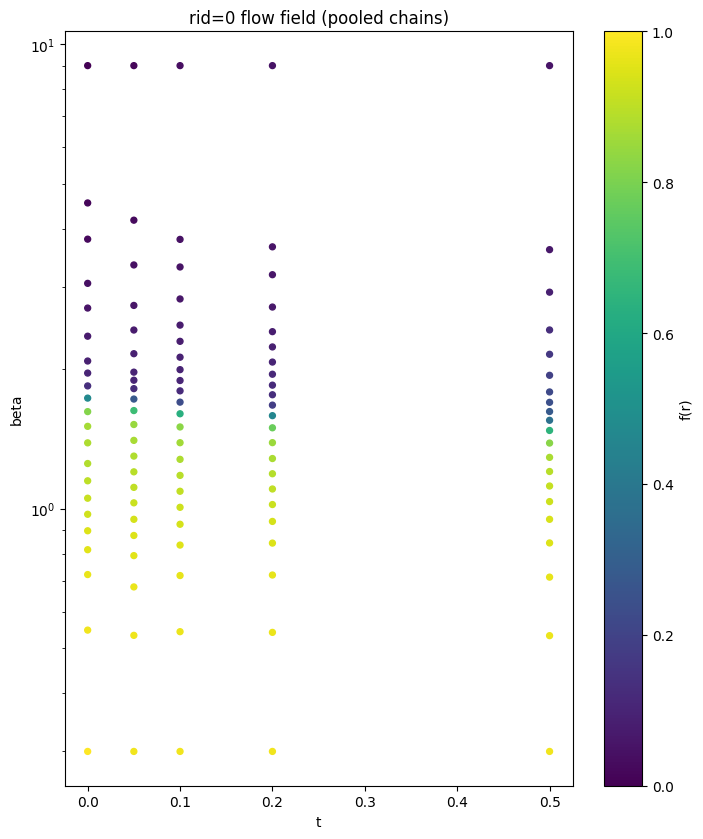

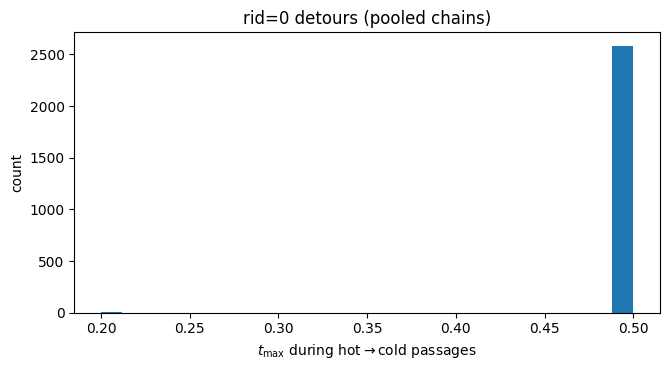

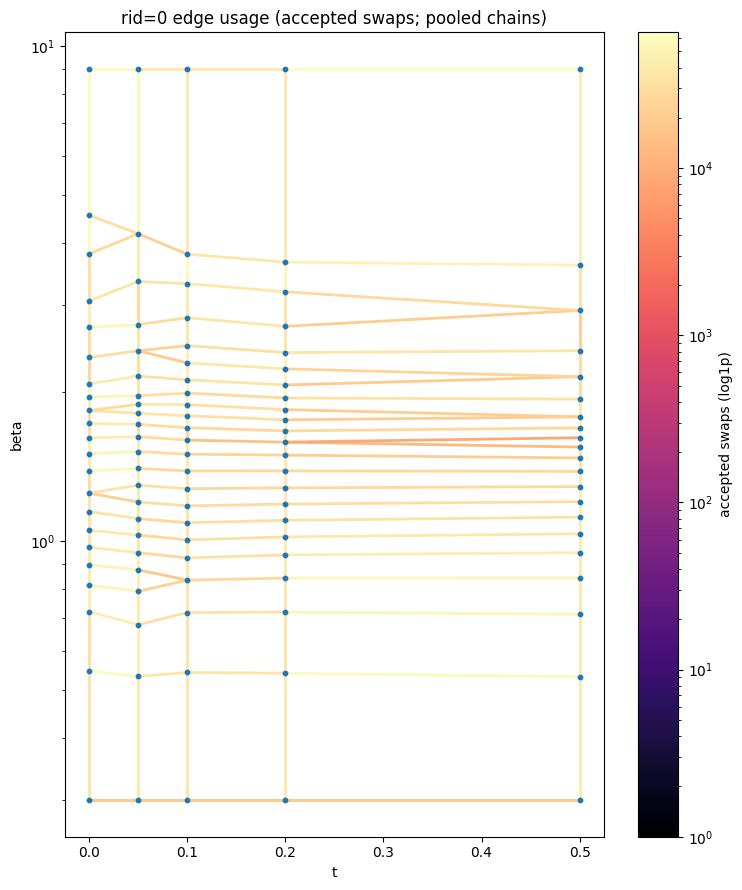

In [14]:
plot_flow_field(meta, out["flow"]["f"], title=f"rid={rid} flow field (pooled chains)")
plot_detour_hist(out["passage"]["pooled"]["tmax_hc"], title=f"rid={rid} detours (pooled chains)")

plot_edge_usage(meta,
                out["edges"]["counts_v"],
                counts_h=out["edges"]["counts_h"],
                title=f"rid={rid} edge usage (accepted swaps; pooled chains)")

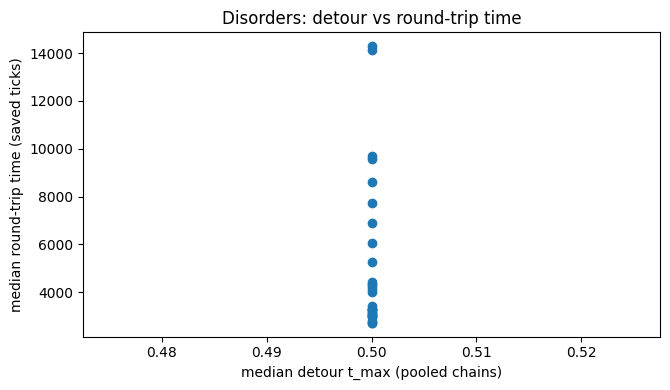

In [15]:
summary = pt2d_analyze_all(meta, results, hot_idx, cold_idx, burn_in=0.0)
plot_summary_detour_vs_rt(summary)

Text(0, 0.5, 'median round trip time')

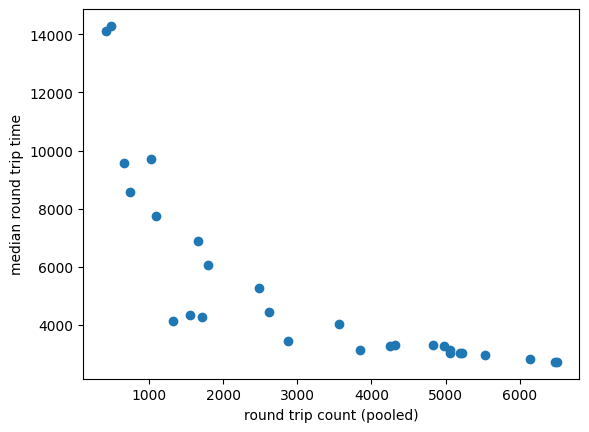

In [16]:
# after pt2d_analyze_all or per rid:
plt.scatter(summary["rt_cnt_pooled"], summary["rt_med_pooled"])
plt.xlabel("round trip count (pooled)")
plt.ylabel("median round trip time")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ============================================================
# 0) Meta + endpoints
# ============================================================

@dataclass(frozen=True)
class PT2DMeta:
    beta: np.ndarray      # (R,)
    t_grid: np.ndarray    # (B,)
    k_start: np.ndarray   # (B+1,)
    b_of_r: np.ndarray    # (R,)
    t_of_r: np.ndarray    # (R,)
    R: int
    B: int

def pt2d_meta(sys) -> PT2DMeta:
    beta   = np.asarray(sys.beta, dtype=np.float64)
    t_grid = np.asarray(sys.t_grid, dtype=np.float64)
    k_start = np.asarray(sys.k_start, dtype=np.int64)
    b_of_r = np.asarray(sys.b_of_r, dtype=np.int64)
    R = int(beta.shape[0])
    B = int(k_start.shape[0] - 1)
    t_of_r = t_grid[b_of_r]
    return PT2DMeta(beta=beta, t_grid=t_grid, k_start=k_start, b_of_r=b_of_r, t_of_r=t_of_r, R=R, B=B)

@dataclass(frozen=True)
class Ends:
    b0: int
    hot_idx: np.ndarray   # boxes in H0 (t=0 row)
    cold_idx: np.ndarray  # boxes in C0 (t=0 row)
    row0_boxes: np.ndarray

def pt2d_endpoints_row0(meta: PT2DMeta, *, b0=0, hot_k=0, cold_top=1) -> Ends:
    """
    Endpoints in the t=b0 row.
      H0: k=hot_k (default 0)
      C0: top 'cold_top' boxes (largest beta) in that row (default 1).
    """
    r0, r1 = int(meta.k_start[b0]), int(meta.k_start[b0+1])
    K0 = r1 - r0
    if not (0 <= hot_k < K0):
        raise ValueError("hot_k out of range in row0")
    cold_top = int(max(1, cold_top))
    cold_ks = np.arange(max(0, K0 - cold_top), K0, dtype=np.int64)

    hot_idx  = np.asarray([r0 + hot_k], dtype=np.int64)
    cold_idx = (r0 + cold_ks).astype(np.int64)
    row0_boxes = np.arange(r0, r1, dtype=np.int64)
    return Ends(b0=b0, hot_idx=hot_idx, cold_idx=cold_idx, row0_boxes=row0_boxes)

def _get_perm_ts(res):
    """
    Your TrialResult sometimes stores the permutation time series in I_ts or Ψ_ts.
    Must be shape (2, T, R): box->label permutation at each saved tick.
    """
    for name in ("I_ts", "Ψ_ts", "Psi_ts", "psi_ts"):
        if hasattr(res, name):
            X = getattr(res, name)
            if X is not None:
                X = np.asarray(X)
                if X.ndim == 3 and X.shape[0] == 2:
                    return X.astype(np.int64, copy=False)
    raise AttributeError("Could not find (2,T,R) permutation series in res (tried I_ts/Ψ_ts).")

def _burn_index(T, burn_in):
    if isinstance(burn_in, float):
        if not (0 <= burn_in < 1):
            raise ValueError("burn_in float must be in [0,1).")
        return int(np.floor(burn_in * T))
    return int(burn_in)


# ============================================================
# 1) Wall-clock + embedded RT and detour stats (per chain, pooled)
# ============================================================

def _metrics_one_chain(I_TR, meta: PT2DMeta, ends: Ends, *, burn_in=0.0, stride=3,
                       record_detours=True):
    """
    I_TR: (T,R) permutation snapshots (box->label).
    Uses endpoints H0,C0 in row b0.

    Returns arrays:
      rt_wall, tau_hc_wall, tau_ch_wall
      rt_emb0, tau_hc_emb0, tau_ch_emb0  (time counted only while label is in row0)
      tmax_hc, phi_hc   (detour summaries for H0->C0 passages)
    """
    I = np.asarray(I_TR, dtype=np.int64)
    T, R = I.shape
    t0 = max(0, min(_burn_index(T, burn_in), T-1))
    idxs = np.arange(t0, T, int(max(1, stride)), dtype=np.int64)

    hot_idx  = ends.hot_idx
    cold_idx = ends.cold_idx
    b0 = ends.b0
    b_of_r = meta.b_of_r
    t_of_r = meta.t_of_r

    # per-label state for wall-clock timings
    last_end = np.zeros(R, dtype=np.int8)    # +1 hot, -1 cold, 0 none
    last_t_wall = np.full(R, -1, dtype=np.int64)

    hot_start_wall = np.full(R, -1, dtype=np.int64)
    seen_cold = np.zeros(R, dtype=bool)

    # per-label embedded "time in row0"
    emb_clock = np.zeros(R, dtype=np.int64)
    last_t_emb = np.full(R, -1, dtype=np.int64)
    hot_start_emb = np.full(R, -1, dtype=np.int64)

    # detour tracking during H0->C0 passages
    active_hc = np.zeros(R, dtype=bool)
    off0_cnt  = np.zeros(R, dtype=np.int64)
    step_cnt  = np.zeros(R, dtype=np.int64)
    tmax      = np.full(R, -np.inf, dtype=np.float64)

    # outputs
    rt_wall, tau_hc_wall, tau_ch_wall = [], [], []
    rt_emb0, tau_hc_emb0, tau_ch_emb0 = [], [], []
    tmax_hc, phi_hc = [], []

    pos = np.empty(R, dtype=np.int64)  # label->box

    for tt in idxs:
        It = I[tt]

        # invert for b(label), t(label) and for embedded clock increments
        pos[It] = np.arange(R, dtype=np.int64)  # label -> box
        b_lab = b_of_r[pos]                     # label -> row index b
        t_lab = t_of_r[pos]                     # label -> t

        # embedded clock increments for labels currently in row0
        in0 = (b_lab == b0)
        emb_clock[in0] += 1

        # detour accumulation for active H0->C0 passages
        if record_detours and active_hc.any():
            a = np.flatnonzero(active_hc)
            step_cnt[a] += 1
            off0_cnt[a] += (b_lab[a] != b0)
            tmax[a] = np.maximum(tmax[a], t_lab[a])

        wH = It[hot_idx]
        wC = It[cold_idx]

        # ---- cold hits ----
        for w in np.ravel(wC):
            w = int(w)

            # one-way H->C (wall) measured by last_end timestamps
            if last_end[w] == +1 and last_t_wall[w] != -1:
                tau_hc_wall.append(tt - last_t_wall[w])
                # embedded version: use embedded clock difference
                if last_t_emb[w] != -1:
                    tau_hc_emb0.append(emb_clock[w] - last_t_emb[w])

            # round-trip bookkeeping: mark cold seen if a hot_start exists
            if hot_start_wall[w] != -1:
                seen_cold[w] = True

            # close detour stats at first cold hit after a hot start
            if record_detours and active_hc[w]:
                if step_cnt[w] > 0:
                    phi_hc.append(float(off0_cnt[w]) / float(step_cnt[w]))
                tmax_hc.append(float(tmax[w]))
                active_hc[w] = False
                off0_cnt[w] = 0
                step_cnt[w] = 0
                tmax[w] = -np.inf

            last_end[w] = -1
            last_t_wall[w] = tt
            last_t_emb[w] = emb_clock[w]

        # ---- hot hits ----
        for w in np.ravel(wH):
            w = int(w)

            # one-way C->H
            if last_end[w] == -1 and last_t_wall[w] != -1:
                tau_ch_wall.append(tt - last_t_wall[w])
                if last_t_emb[w] != -1:
                    tau_ch_emb0.append(emb_clock[w] - last_t_emb[w])

            # close round-trip if cold was seen since last hot start
            if hot_start_wall[w] != -1 and seen_cold[w]:
                rt_wall.append(tt - hot_start_wall[w])
                rt_emb0.append(emb_clock[w] - hot_start_emb[w])

            # (re)start
            hot_start_wall[w] = tt
            hot_start_emb[w]  = emb_clock[w]
            seen_cold[w] = False

            # (re)start detour tracking for H->C
            if record_detours:
                active_hc[w] = True
                off0_cnt[w] = 0
                step_cnt[w] = 0
                tmax[w] = t_lab[w]  # starting t (should be 0 if hot is in row0)

            last_end[w] = +1
            last_t_wall[w] = tt
            last_t_emb[w] = emb_clock[w]

    return dict(
        rt_wall=np.asarray(rt_wall, dtype=np.int64),
        tau_hc_wall=np.asarray(tau_hc_wall, dtype=np.int64),
        tau_ch_wall=np.asarray(tau_ch_wall, dtype=np.int64),
        rt_emb0=np.asarray(rt_emb0, dtype=np.int64),
        tau_hc_emb0=np.asarray(tau_hc_emb0, dtype=np.int64),
        tau_ch_emb0=np.asarray(tau_ch_emb0, dtype=np.int64),
        tmax_hc=np.asarray(tmax_hc, dtype=np.float64),
        phi_hc=np.asarray(phi_hc, dtype=np.float64),
        meta=dict(T=T, burn=t0, stride=stride)
    )

def pt2d_transport_metrics(res, meta: PT2DMeta, ends: Ends, *,
                          burn_in=0.0, stride=3, record_detours=True):
    """
    Returns per-chain metrics + pooled concatenations + robust summaries.
    """
    I2 = _get_perm_ts(res)  # (2,T,R)
    m0 = _metrics_one_chain(I2[0], meta, ends, burn_in=burn_in, stride=stride, record_detours=record_detours)
    m1 = _metrics_one_chain(I2[1], meta, ends, burn_in=burn_in, stride=stride, record_detours=record_detours)

    def cat(key, dtype):
        a = m0[key]; b = m1[key]
        if a.size and b.size: return np.concatenate([a, b]).astype(dtype, copy=False)
        if a.size: return a.astype(dtype, copy=False)
        if b.size: return b.astype(dtype, copy=False)
        return np.empty((0,), dtype=dtype)

    pooled = {k: cat(k, m0[k].dtype) for k in m0.keys() if k != "meta"}
    rtW = pooled["rt_wall"].astype(np.float64)
    rtE = pooled["rt_emb0"].astype(np.float64)

    frac = rtE / np.maximum(1.0, rtW)   # per-event in-row fraction
    p_med  = float(np.median(frac)) if frac.size else np.nan
    p_time = float(rtE.sum() / rtW.sum()) if rtW.size else np.nan

    def med(x): return float(np.median(x)) if x.size else np.nan
    def cnt(x): return int(x.size)

    summary = dict(
        rid=int(res.rid),
        # wall-clock
        rt_cnt_chain=[cnt(m0["rt_wall"]), cnt(m1["rt_wall"])],
        rt_med_chain=[med(m0["rt_wall"]), med(m1["rt_wall"])],
        rt_med_wall=med(pooled["rt_wall"]),
        # embedded row0
        rt_med_emb0=med(pooled["rt_emb0"]),
        p_med=p_med
        p_time = p_time
        # one-way
        tau_hc_med_wall=med(pooled["tau_hc_wall"]),
        tau_hc_med_emb0=med(pooled["tau_hc_emb0"]),
        # detours
        tmax_med=med(pooled["tmax_hc"]),
        phi_med=med(pooled["phi_hc"]),
        phi_mean=float(np.mean(pooled["phi_hc"])) if pooled["phi_hc"].size else np.nan,
        # helpful derived: "inflation factor" from detours
        inflation=med(pooled["rt_wall"]) / med(pooled["rt_emb0"]) if (pooled["rt_wall"].size and pooled["rt_emb0"].size and med(pooled["rt_emb0"])>0) else np.nan
    )

    return dict(per_chain=(m0, m1), pooled=pooled, summary=summary)


# ============================================================
# 2) 2D flow field f(r) using last-end labeling with endpoints H0,C0
# ============================================================

def pt2d_flow_field(res, meta: PT2DMeta, ends: Ends, *, burn_in=0.1, stride=3):
    """
    f[r] = P(last endpoint was hot | currently at node r), pooled over 2 chains.
    Endpoints are H0,C0 in row0.
    """
    I2 = _get_perm_ts(res)
    hot_idx, cold_idx = ends.hot_idx, ends.cold_idx

    def run_one(I_TR):
        I = np.asarray(I_TR, dtype=np.int64)
        T, R = I.shape
        t0 = max(0, min(_burn_index(T, burn_in), T-1))
        idxs = np.arange(t0, T, int(max(1, stride)), dtype=np.int64)

        labels = np.zeros(R, dtype=np.int8)     # per label: +1 hot, -1 cold, 0 unknown
        num = np.zeros(R, dtype=np.float64)     # per node r
        den = np.zeros(R, dtype=np.float64)

        for tt in idxs:
            It = I[tt]
            labels[It[hot_idx]]  = +1
            labels[It[cold_idx]] = -1

            st = labels[It]      # state of occupant at each node r
            known = (st != 0)
            den[known] += 1.0
            num[known] += (st[known] == +1)

        return num, den

    num0, den0 = run_one(I2[0])
    num1, den1 = run_one(I2[1])
    num = num0 + num1
    den = den0 + den1

    f = np.full(meta.R, np.nan, dtype=np.float64)
    m = den > 0
    f[m] = num[m] / den[m]

    # row0 profile (ordered by increasing beta index along row0)
    row0 = ends.row0_boxes
    f_row0 = f[row0]
    return dict(f=f, den=den, f_row0=f_row0, row0_boxes=row0)


# ============================================================
# 3) Empirical transition kernel on nodes + committor (optional)
# ============================================================

def pt2d_transition_counts(res, meta: PT2DMeta, *, burn_in=0.1, stride=3, label_subsample=None):
    """
    Build empirical transition counts C[u,v] from label trajectories at macro-step stride.
    Implementation: invert permutation to label positions and count (pos_t -> pos_{t+1}) per label.

    Returns:
      counts: dict u -> dict v -> count
      visits: (R,) visitation counts (for pi estimate)
    """
    I2 = _get_perm_ts(res)  # (2,T,R)
    R = meta.R
    pos_t = np.empty(R, dtype=np.int64)
    pos_n = np.empty(R, dtype=np.int64)

    counts = {}  # sparse dict-of-dicts
    visits = np.zeros(R, dtype=np.int64)

    def add(u, v, w=1):
        d = counts.get(u)
        if d is None:
            d = {}
            counts[u] = d
        d[v] = d.get(v, 0) + w

    for chain in (0, 1):
        I = I2[chain]
        T = I.shape[0]
        t0 = max(0, min(_burn_index(T, burn_in), T-1))
        idxs = np.arange(t0, T, int(max(1, stride)), dtype=np.int64)
        if idxs.size < 2:
            continue

        # choose which labels to include
        labels = np.arange(R, dtype=np.int64)
        if label_subsample is not None:
            labels = np.asarray(label_subsample, dtype=np.int64)

        for a in range(idxs.size - 1):
            tA, tB = int(idxs[a]), int(idxs[a+1])
            IA = I[tA]; IB = I[tB]
            pos_t[IA] = np.arange(R, dtype=np.int64)
            pos_n[IB] = np.arange(R, dtype=np.int64)

            u = pos_t[labels]
            v = pos_n[labels]

            # visits for pi
            np.add.at(visits, u, 1)

            # sparse counts
            for uu, vv in zip(u, v):
                add(int(uu), int(vv), 1)

    return counts, visits

def _normalize_counts_to_P(counts, R):
    """
    counts: dict u -> dict v -> count
    returns P: dict u -> (vs, ps) arrays normalized
    """
    P = {}
    for u, d in counts.items():
        vs = np.fromiter(d.keys(), dtype=np.int64)
        cs = np.fromiter(d.values(), dtype=np.float64)
        s = cs.sum()
        if s > 0:
            P[int(u)] = (vs, cs / s)
    return P

def pt2d_committor(P, R, hot_set, cold_set, *, tol=1e-10, max_iter=20000, omega=1.0):
    """
    Solve q = P q with boundary conditions q=1 on hot_set, q=0 on cold_set.
    Iterative Gauss-Seidel / SOR on sparse P.
    """
    hot = np.zeros(R, dtype=bool); hot[np.asarray(list(hot_set), dtype=np.int64)] = True
    cold = np.zeros(R, dtype=bool); cold[np.asarray(list(cold_set), dtype=np.int64)] = True
    free = ~(hot | cold)

    q = np.zeros(R, dtype=np.float64)
    q[hot] = 1.0
    q[cold] = 0.0

    free_idx = np.flatnonzero(free)
    for it in range(max_iter):
        maxdiff = 0.0
        for u in free_idx:
            if u not in P:
                continue
            vs, ps = P[u]
            val = float(np.dot(ps, q[vs]))
            new = (1 - omega) * q[u] + omega * val
            diff = abs(new - q[u])
            if diff > maxdiff:
                maxdiff = diff
            q[u] = new
        if maxdiff < tol:
            break
    return q

def pt2d_committor_from_data(res, meta: PT2DMeta, ends: Ends, *,
                             burn_in=0.1, stride=3, label_subsample=None):
    counts, visits = pt2d_transition_counts(res, meta, burn_in=burn_in, stride=stride,
                                            label_subsample=label_subsample)
    P = _normalize_counts_to_P(counts, meta.R)
    hot_set = set(map(int, ends.hot_idx))
    cold_set = set(map(int, ends.cold_idx))
    q = pt2d_committor(P, meta.R, hot_set, cold_set)
    pi = visits.astype(np.float64)
    pi = pi / pi.sum() if pi.sum() > 0 else pi
    return dict(P=P, q=q, pi=pi, visits=visits)


# ============================================================
# 4) Batch over disorders + plots
# ============================================================

def pt2d_analyze_all(results, sys, *, b0=0, hot_k=0, cold_top=1,
                     burn_in=0.1, stride=3, record_detours=True):
    """
    Returns a summary dict of arrays, one entry per disorder.
    """
    meta = pt2d_meta(sys)
    ends = pt2d_endpoints_row0(meta, b0=b0, hot_k=hot_k, cold_top=cold_top)

    out = {
        "rid": [],
        "rt_med_wall": [],
        "rt_med_emb0": [],
        "inflation": [],
        "phi_med": [],
        "tmax_med": [],
        "rt_cnt_total": [],
    }

    for res in results:
        m = pt2d_transport_metrics(res, meta, ends, burn_in=burn_in, stride=stride, record_detours=record_detours)
        s = m["summary"]
        out["rid"].append(int(res.rid))
        out["rt_med_wall"].append(s["rt_med_wall"])
        out["rt_med_emb0"].append(s["rt_med_emb0"])
        out["inflation"].append(s["inflation"])
        out["phi_med"].append(s["phi_med"])
        out["tmax_med"].append(s["tmax_med"])
        out["rt_cnt_total"].append(int(sum(s["rt_cnt_chain"])))

    for k in list(out.keys()):
        out[k] = np.asarray(out[k])
    out["meta"] = meta
    out["ends"] = ends
    return out

def plot_rt_wall_vs_emb0(summary, *, title=None):
    x = summary["rt_med_emb0"]
    y = summary["rt_med_wall"]
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median RT embedded in t=0 (row0-time units)")
    ax.set_ylabel("median RT wall-clock (macro-step units)")
    ax.set_title(title or "Wall-clock vs embedded t=0 round trips")
    plt.tight_layout(); plt.show()

def plot_detour_phi_vs_rt(summary, *, title=None):
    x = summary["phi_med"]
    y = summary["rt_med_wall"]
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median detour fraction φ (H0→C0)")
    ax.set_ylabel("median wall-clock RT (macro-step units)")
    ax.set_title(title or "Detour usage vs wall-clock RT")
    plt.yscale("log")
    plt.tight_layout(); plt.show()

def plot_row0_flow(res, sys, *, b0=0, hot_k=0, cold_top=1, burn_in=0.1, stride=3, title=None):
    meta = pt2d_meta(sys)
    ends = pt2d_endpoints_row0(meta, b0=b0, hot_k=hot_k, cold_top=cold_top)
    F = pt2d_flow_field(res, meta, ends, burn_in=burn_in, stride=stride)

    row0 = ends.row0_boxes
    bet0 = meta.beta[row0]
    f0 = F["f_row0"]

    fig, ax = plt.subplots(figsize=(6.8, 4.0))
    ax.plot(np.arange(f0.size), f0, marker="o")
    ax.set_xlabel("k index along t=0 ladder (increasing β)")
    ax.set_ylabel("f on row0")
    ax.set_title(title or f"rid={int(res.rid)} row0 flow profile f")
    plt.tight_layout(); plt.show()
    return F

def plot_row0_committor(res, sys, *, b0=0, hot_k=0, cold_top=1, burn_in=0.1, stride=3, title=None):
    meta = pt2d_meta(sys)
    ends = pt2d_endpoints_row0(meta, b0=b0, hot_k=hot_k, cold_top=cold_top)
    C = pt2d_committor_from_data(res, meta, ends, burn_in=burn_in, stride=stride)

    row0 = ends.row0_boxes
    q0 = C["q"][row0]

    fig, ax = plt.subplots(figsize=(6.8, 4.0))
    ax.plot(np.arange(q0.size), q0, marker="o")
    ax.set_xlabel("k index along t=0 ladder (increasing β)")
    ax.set_ylabel("committor q on row0")
    ax.set_title(title or f"rid={int(res.rid)} row0 committor q")
    plt.tight_layout(); plt.show()
    return C


In [10]:
meta = pt2d_meta(sys2)
ends = pt2d_endpoints_row0(meta, b0=0, hot_k=0, cold_top=2)  # cold_top=2 is often more stable


{'rid': 0, 'rt_cnt_chain': [1218, 1253], 'rt_med_chain': [5497.5, 5235.0], 'rt_med_wall': 5364.0, 'rt_med_emb0': 336.0, 'tau_hc_med_wall': 825.0, 'tau_hc_med_emb0': 46.0, 'tmax_med': 0.5, 'phi_med': 0.8342967244701349, 'phi_mean': 0.831605124848246, 'inflation': 15.964285714285714}


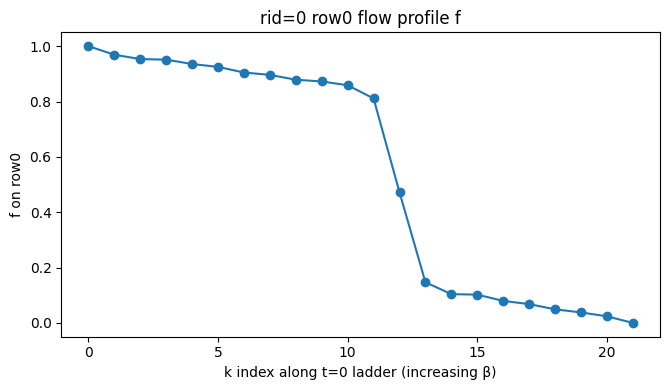

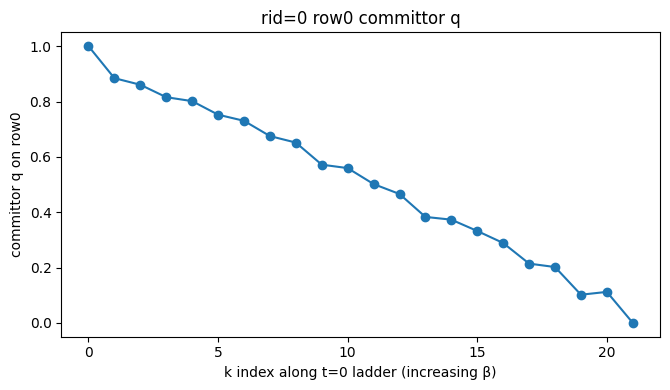

{'rid': 1, 'rt_cnt_chain': [351, 345], 'rt_med_chain': [9762.0, 9021.0], 'rt_med_wall': 9270.0, 'rt_med_emb0': 661.5, 'tau_hc_med_wall': 859.5, 'tau_hc_med_emb0': 47.0, 'tmax_med': 0.5, 'phi_med': 0.8354430379746836, 'phi_mean': 0.8335417638245403, 'inflation': 14.013605442176871}


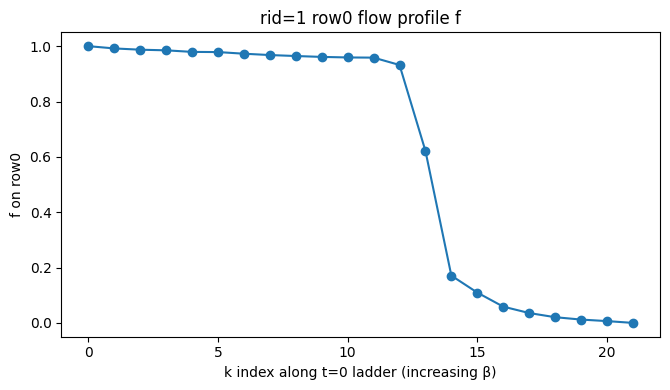

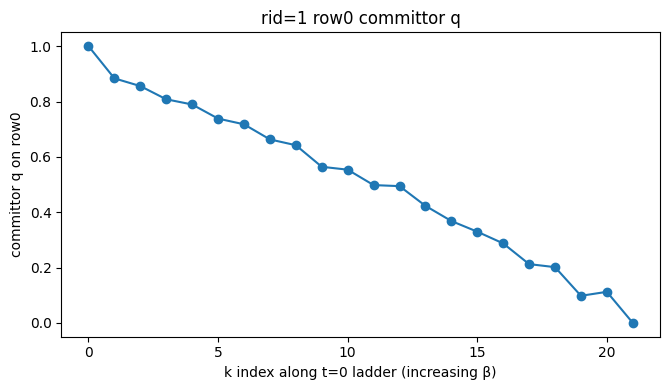

{'rid': 2, 'rt_cnt_chain': [1397, 1376], 'rt_med_chain': [4434.0, 4461.0], 'rt_med_wall': 4446.0, 'rt_med_emb0': 293.0, 'tau_hc_med_wall': 831.0, 'tau_hc_med_emb0': 48.0, 'tmax_med': 0.5, 'phi_med': 0.8256880733944955, 'phi_mean': 0.8235617991964208, 'inflation': 15.174061433447099}


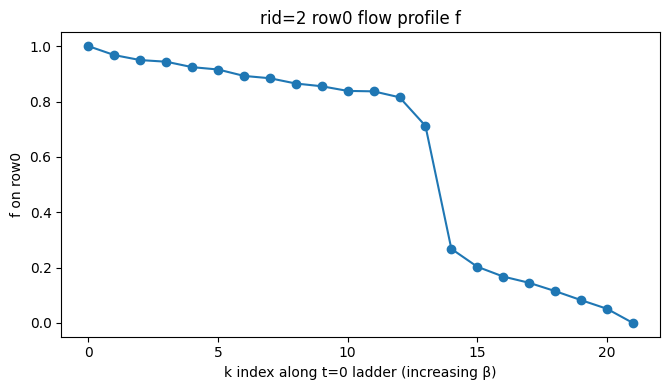

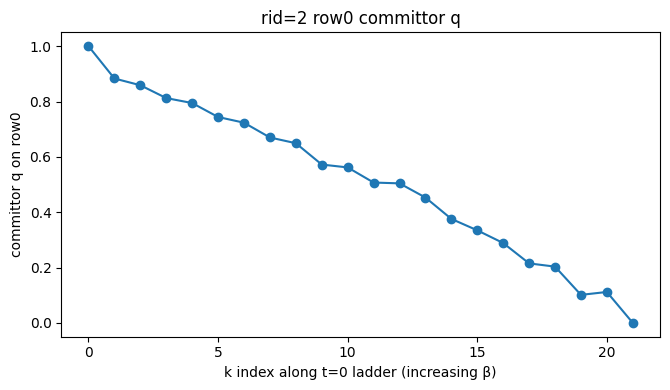

{'rid': 3, 'rt_cnt_chain': [515, 514], 'rt_med_chain': [10098.0, 9487.5], 'rt_med_wall': 9801.0, 'rt_med_emb0': 568.0, 'tau_hc_med_wall': 939.0, 'tau_hc_med_emb0': 50.0, 'tmax_med': 0.5, 'phi_med': 0.844311377245509, 'phi_mean': 0.8420926468475919, 'inflation': 17.255281690140844}


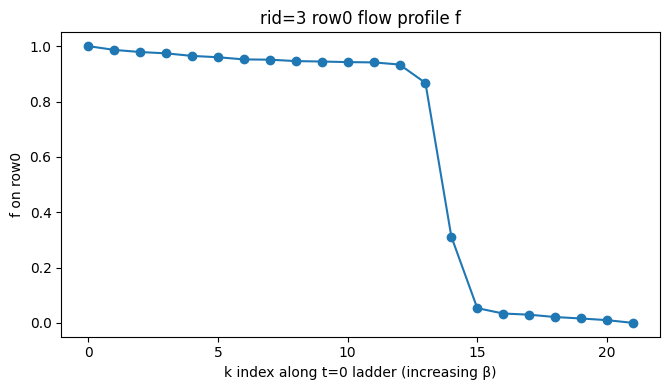

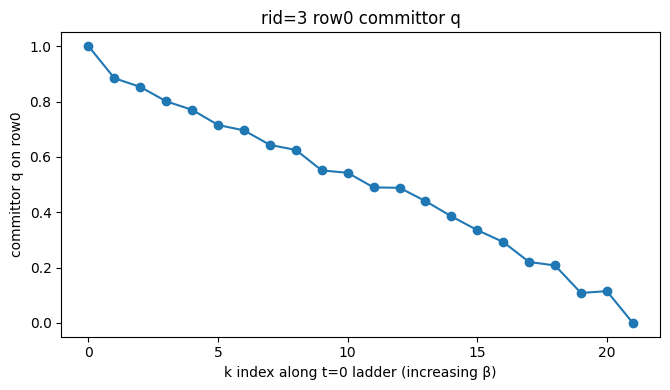

{'rid': 4, 'rt_cnt_chain': [638, 642], 'rt_med_chain': [7401.0, 7519.5], 'rt_med_wall': 7486.5, 'rt_med_emb0': 436.5, 'tau_hc_med_wall': 912.0, 'tau_hc_med_emb0': 50.0, 'tmax_med': 0.5, 'phi_med': 0.837696335078534, 'phi_mean': 0.8348425277483974, 'inflation': 17.151202749140893}


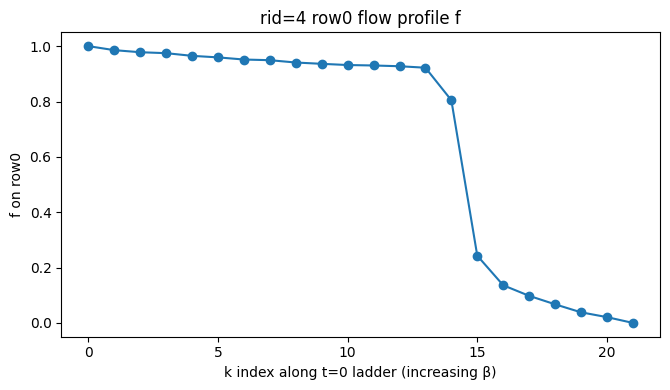

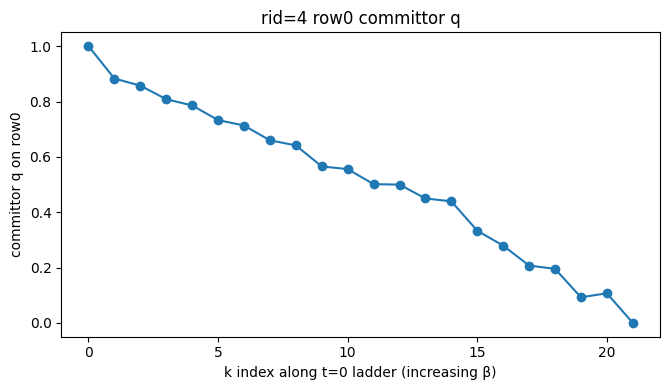

{'rid': 5, 'rt_cnt_chain': [220, 205], 'rt_med_chain': [13383.0, 14319.0], 'rt_med_wall': 13845.0, 'rt_med_emb0': 795.0, 'tau_hc_med_wall': 963.0, 'tau_hc_med_emb0': 54.0, 'tmax_med': 0.5, 'phi_med': 0.8387666235141815, 'phi_mean': 0.8424476477697594, 'inflation': 17.41509433962264}


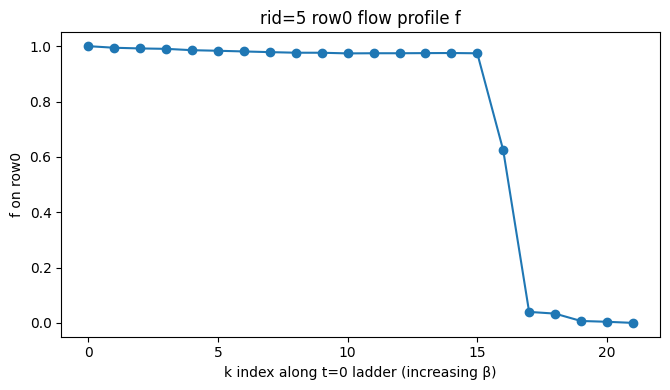

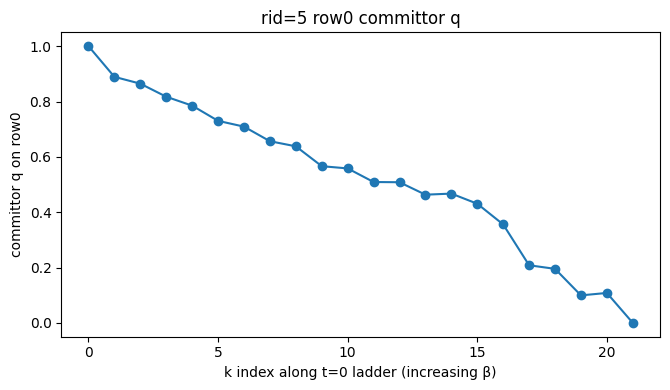

{'rid': 6, 'rt_cnt_chain': [3058, 3042], 'rt_med_chain': [2838.0, 2905.5], 'rt_med_wall': 2868.0, 'rt_med_emb0': 190.0, 'tau_hc_med_wall': 666.0, 'tau_hc_med_emb0': 40.0, 'tmax_med': 0.5, 'phi_med': 0.8222222222222222, 'phi_mean': 0.8178956706261613, 'inflation': 15.094736842105263}


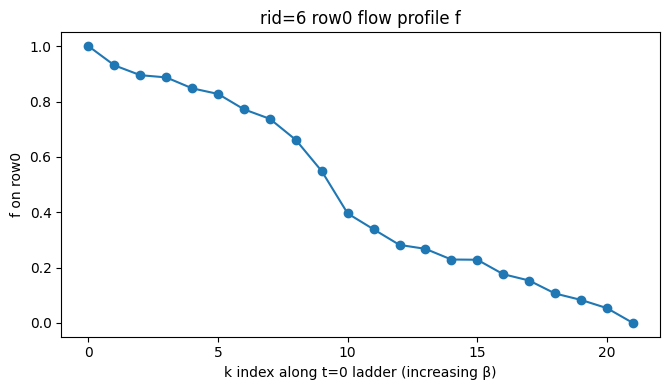

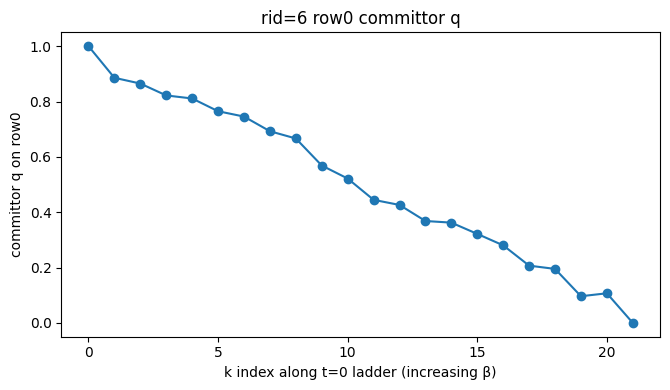

{'rid': 7, 'rt_cnt_chain': [2643, 2631], 'rt_med_chain': [3150.0, 3159.0], 'rt_med_wall': 3150.0, 'rt_med_emb0': 209.0, 'tau_hc_med_wall': 735.0, 'tau_hc_med_emb0': 45.0, 'tmax_med': 0.5, 'phi_med': 0.8164251207729468, 'phi_mean': 0.8148117670458314, 'inflation': 15.07177033492823}


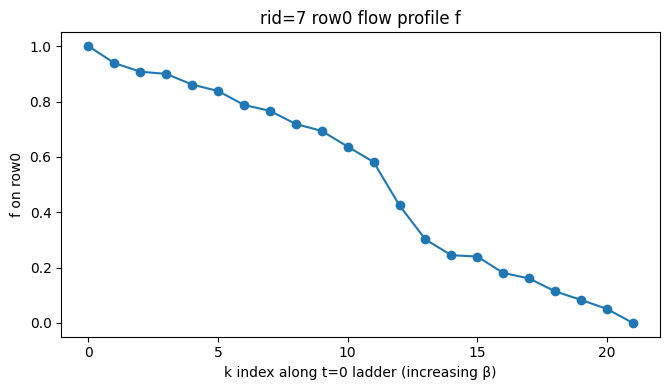

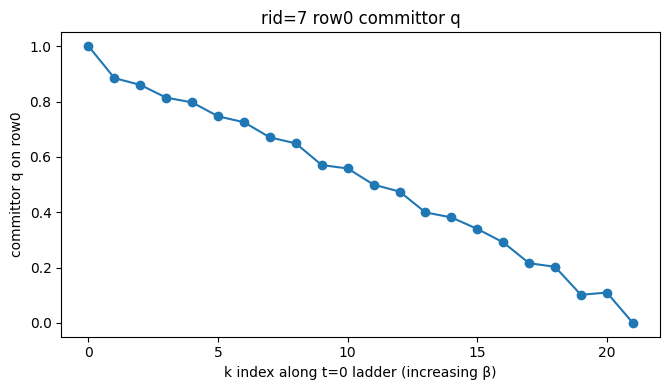

{'rid': 8, 'rt_cnt_chain': [2742, 2815], 'rt_med_chain': [3087.0, 2958.0], 'rt_med_wall': 3021.0, 'rt_med_emb0': 200.0, 'tau_hc_med_wall': 723.0, 'tau_hc_med_emb0': 44.0, 'tmax_med': 0.5, 'phi_med': 0.8189415041782729, 'phi_mean': 0.8141579601811715, 'inflation': 15.105}


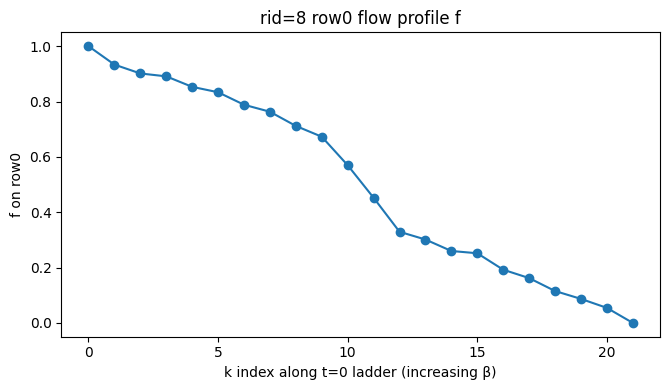

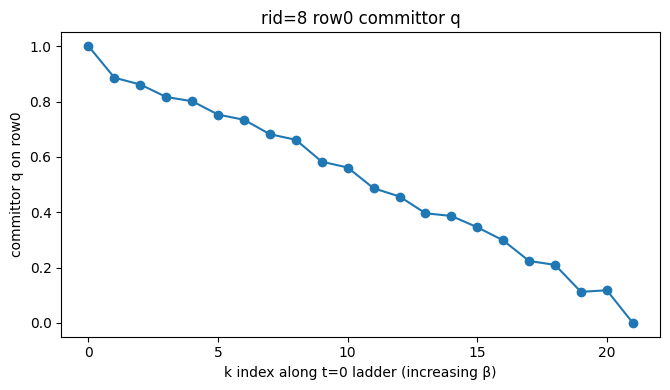

{'rid': 9, 'rt_cnt_chain': [605, 594], 'rt_med_chain': [5796.0, 6028.5], 'rt_med_wall': 5934.0, 'rt_med_emb0': 295.0, 'tau_hc_med_wall': 1122.0, 'tau_hc_med_emb0': 54.0, 'tmax_med': 0.5, 'phi_med': 0.8574951934631099, 'phi_mean': 0.8520069238611879, 'inflation': 20.115254237288134}


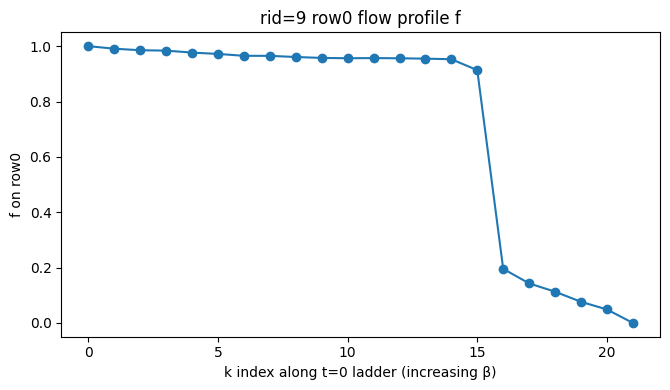

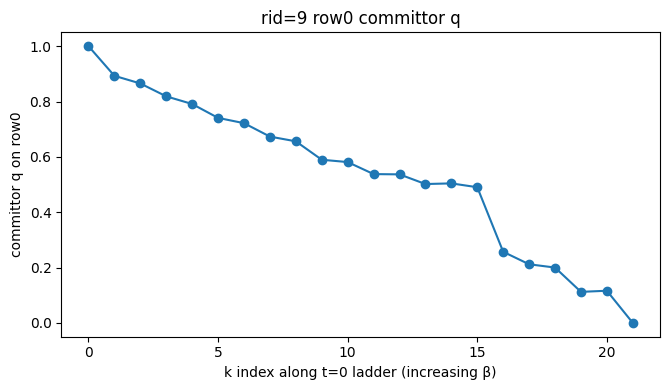

{'rid': 10, 'rt_cnt_chain': [2509, 2464], 'rt_med_chain': [3360.0, 3375.0], 'rt_med_wall': 3363.0, 'rt_med_emb0': 216.0, 'tau_hc_med_wall': 792.0, 'tau_hc_med_emb0': 47.0, 'tmax_med': 0.5, 'phi_med': 0.8240343347639485, 'phi_mean': 0.8197260799104397, 'inflation': 15.569444444444445}


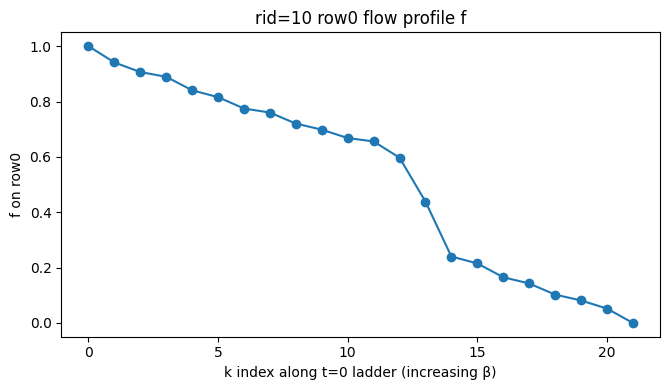

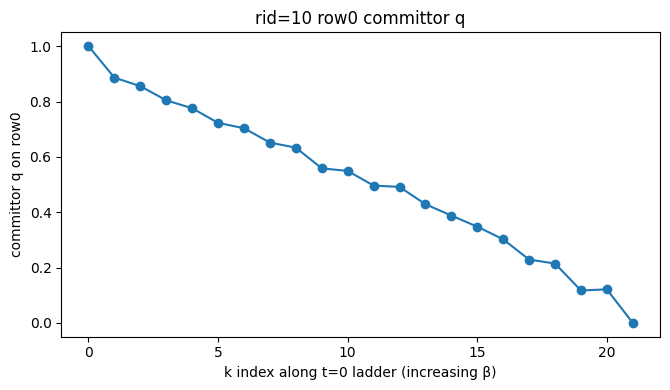

{'rid': 11, 'rt_cnt_chain': [2199, 2205], 'rt_med_chain': [3537.0, 3336.0], 'rt_med_wall': 3403.5, 'rt_med_emb0': 233.5, 'tau_hc_med_wall': 759.0, 'tau_hc_med_emb0': 47.0, 'tmax_med': 0.5, 'phi_med': 0.8110749185667753, 'phi_mean': 0.8093890411272896, 'inflation': 14.576017130620984}


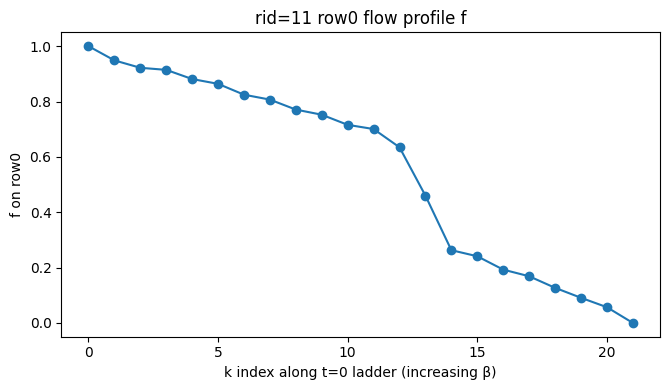

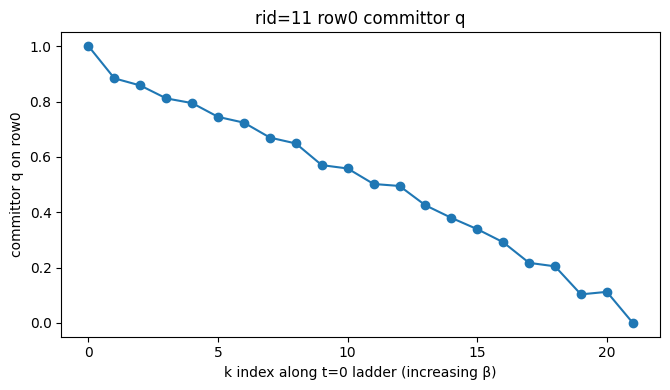

{'rid': 12, 'rt_cnt_chain': [2470, 2431], 'rt_med_chain': [3358.5, 3384.0], 'rt_med_wall': 3369.0, 'rt_med_emb0': 224.0, 'tau_hc_med_wall': 766.5, 'tau_hc_med_emb0': 47.0, 'tmax_med': 0.5, 'phi_med': 0.8184788595153364, 'phi_mean': 0.8150922434525749, 'inflation': 15.040178571428571}


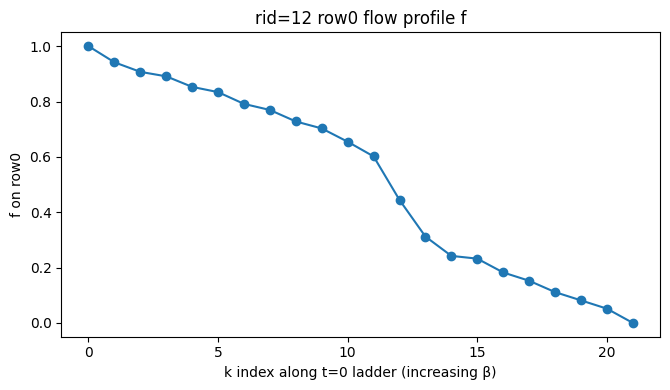

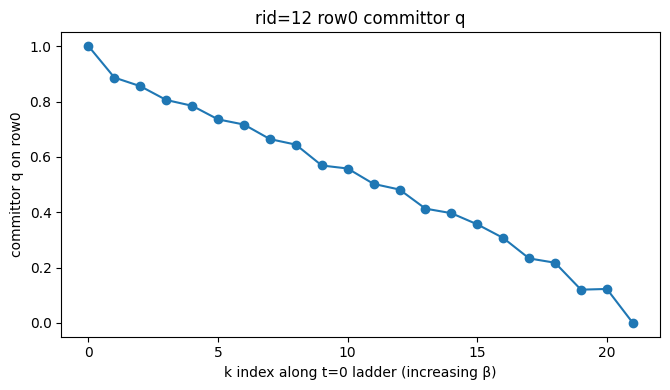

{'rid': 13, 'rt_cnt_chain': [2515, 2528], 'rt_med_chain': [3285.0, 3178.5], 'rt_med_wall': 3222.0, 'rt_med_emb0': 212.0, 'tau_hc_med_wall': 702.0, 'tau_hc_med_emb0': 42.0, 'tmax_med': 0.5, 'phi_med': 0.8217391304347826, 'phi_mean': 0.8160302489472309, 'inflation': 15.19811320754717}


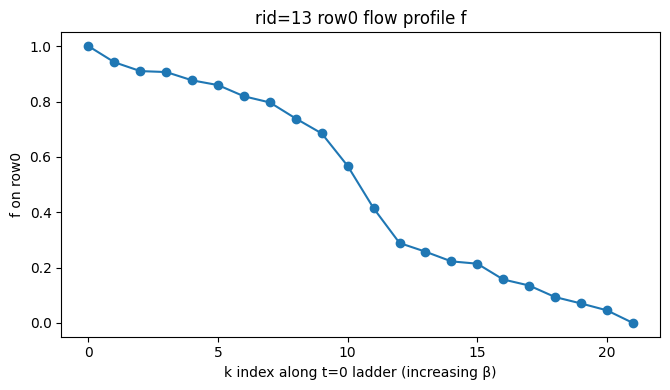

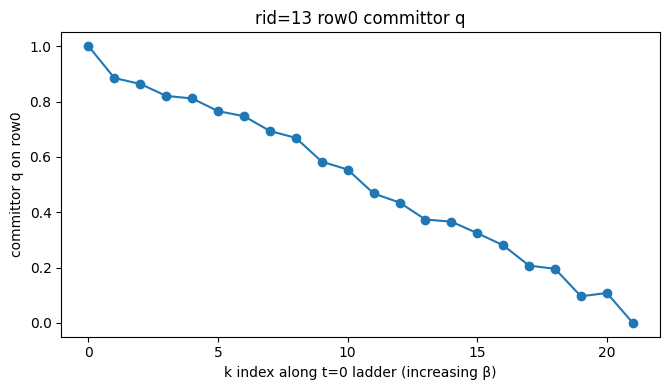

{'rid': 14, 'rt_cnt_chain': [983, 1022], 'rt_med_chain': [3906.0, 3801.0], 'rt_med_wall': 3861.0, 'rt_med_emb0': 246.0, 'tau_hc_med_wall': 981.0, 'tau_hc_med_emb0': 58.0, 'tmax_med': 0.5, 'phi_med': 0.821505376344086, 'phi_mean': 0.8200099588071382, 'inflation': 15.695121951219512}


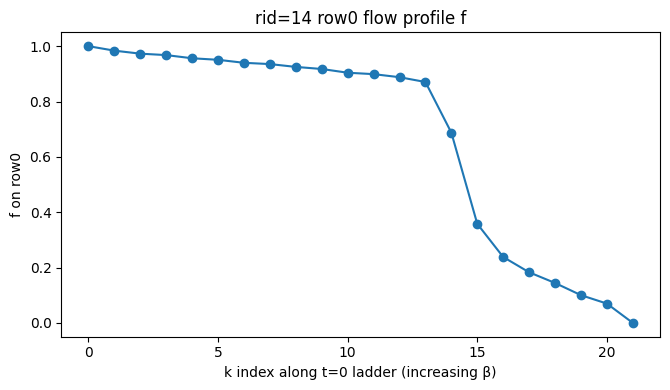

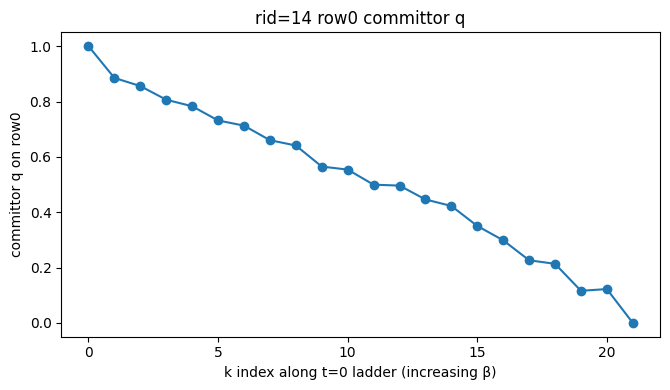

{'rid': 15, 'rt_cnt_chain': [837, 839], 'rt_med_chain': [6825.0, 7110.0], 'rt_med_wall': 6964.5, 'rt_med_emb0': 455.0, 'tau_hc_med_wall': 799.5, 'tau_hc_med_emb0': 44.0, 'tmax_med': 0.5, 'phi_med': 0.8326816279954355, 'phi_mean': 0.8325582300896338, 'inflation': 15.306593406593407}


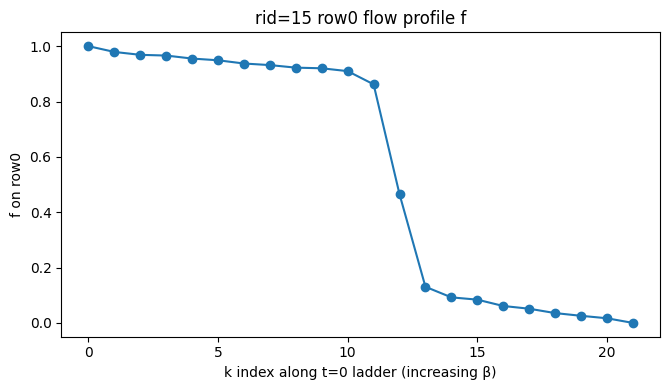

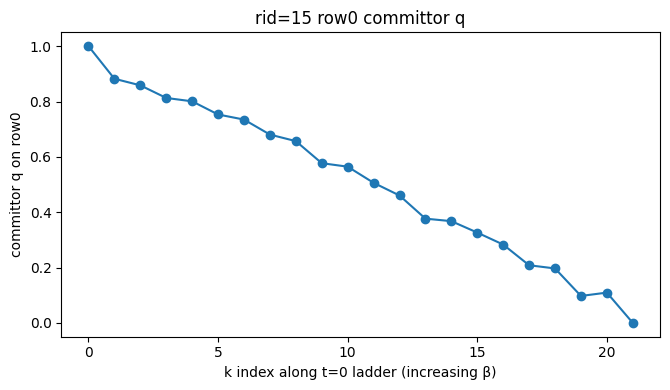

{'rid': 16, 'rt_cnt_chain': [2721, 2686], 'rt_med_chain': [3090.0, 3100.5], 'rt_med_wall': 3093.0, 'rt_med_emb0': 205.0, 'tau_hc_med_wall': 753.0, 'tau_hc_med_emb0': 45.0, 'tmax_med': 0.5, 'phi_med': 0.8210835005402068, 'phi_mean': 0.8175918117272575, 'inflation': 15.08780487804878}


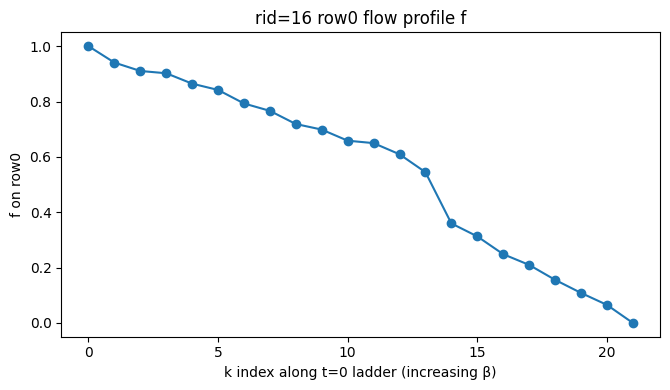

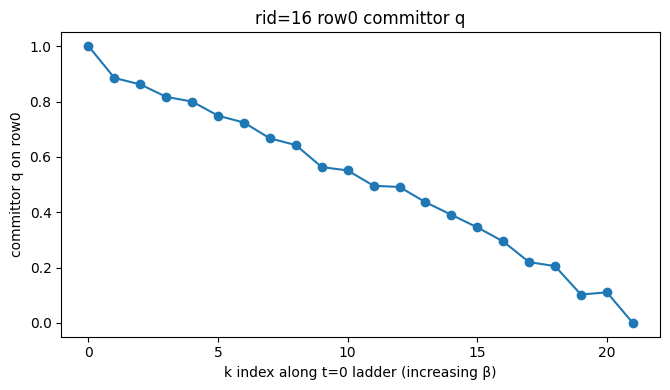

{'rid': 17, 'rt_cnt_chain': [288, 270], 'rt_med_chain': [12292.5, 13968.0], 'rt_med_wall': 13164.0, 'rt_med_emb0': 808.0, 'tau_hc_med_wall': 876.0, 'tau_hc_med_emb0': 45.0, 'tmax_med': 0.5, 'phi_med': 0.8489341983317887, 'phi_mean': 0.8432386947092112, 'inflation': 16.292079207920793}


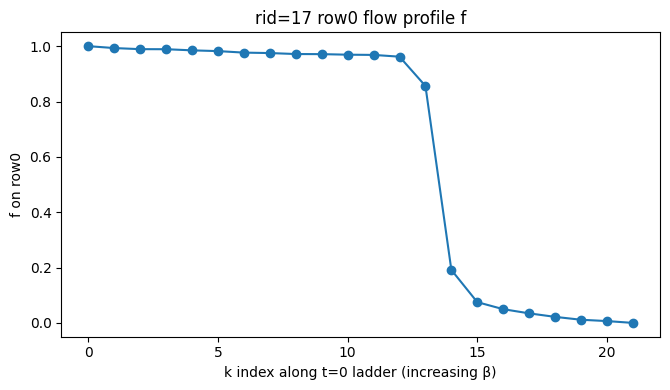

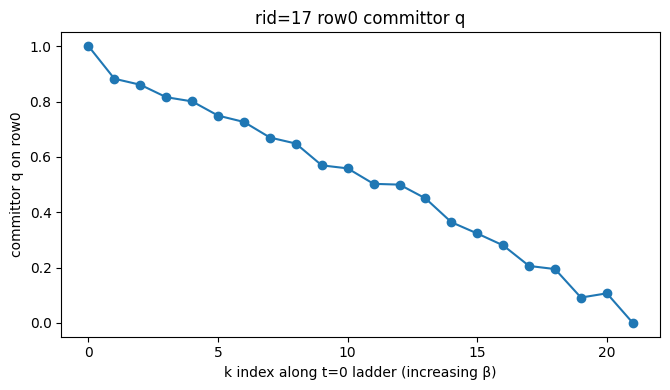

{'rid': 18, 'rt_cnt_chain': [3267, 3229], 'rt_med_chain': [2793.0, 2775.0], 'rt_med_wall': 2781.0, 'rt_med_emb0': 183.5, 'tau_hc_med_wall': 696.0, 'tau_hc_med_emb0': 42.0, 'tmax_med': 0.5, 'phi_med': 0.8191489361702128, 'phi_mean': 0.8154919548442764, 'inflation': 15.155313351498638}


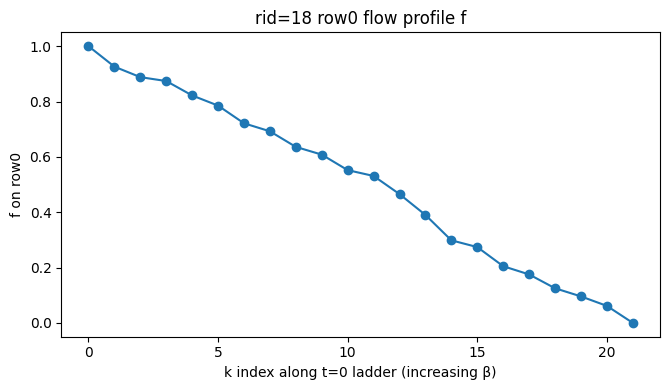

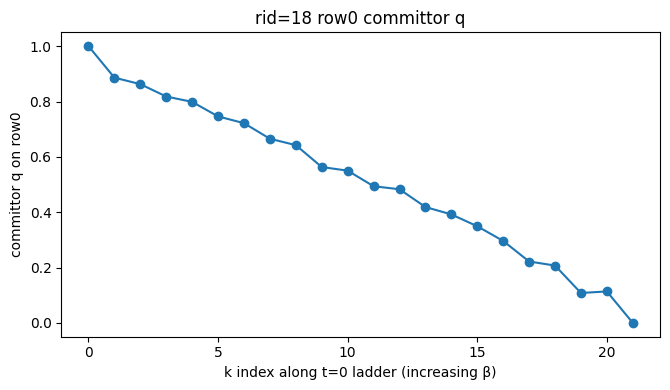

{'rid': 19, 'rt_cnt_chain': [3270, 3228], 'rt_med_chain': [2769.0, 2809.5], 'rt_med_wall': 2787.0, 'rt_med_emb0': 183.0, 'tau_hc_med_wall': 684.0, 'tau_hc_med_emb0': 41.0, 'tmax_med': 0.5, 'phi_med': 0.8215910736075779, 'phi_mean': 0.8163418790741739, 'inflation': 15.229508196721312}


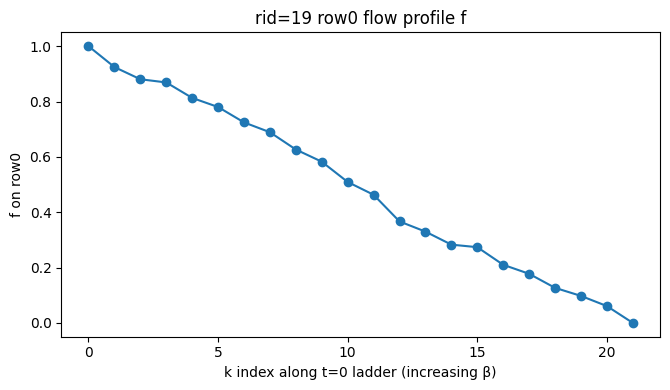

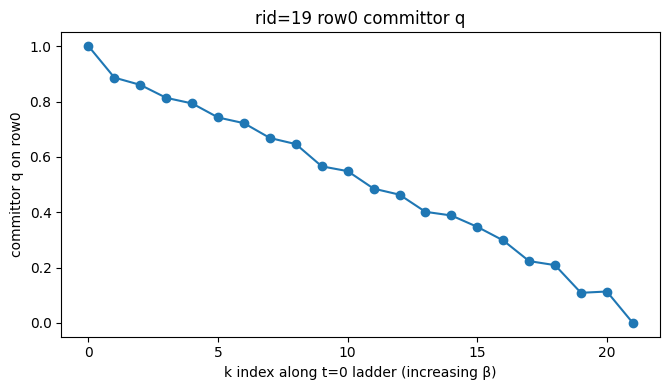

{'rid': 20, 'rt_cnt_chain': [865, 925], 'rt_med_chain': [6432.0, 5931.0], 'rt_med_wall': 6180.0, 'rt_med_emb0': 366.0, 'tau_hc_med_wall': 957.0, 'tau_hc_med_emb0': 51.0, 'tmax_med': 0.5, 'phi_med': 0.8346839546191248, 'phi_mean': 0.8366986850018736, 'inflation': 16.885245901639344}


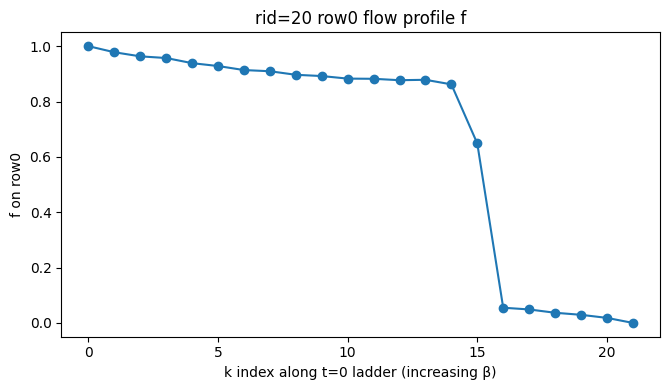

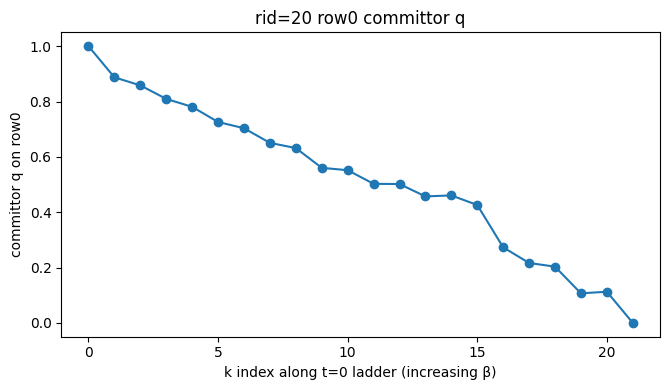

{'rid': 21, 'rt_cnt_chain': [1586, 1540], 'rt_med_chain': [3469.5, 3396.0], 'rt_med_wall': 3439.5, 'rt_med_emb0': 233.0, 'tau_hc_med_wall': 942.0, 'tau_hc_med_emb0': 56.0, 'tmax_med': 0.5, 'phi_med': 0.8157894736842105, 'phi_mean': 0.815057296801208, 'inflation': 14.761802575107296}


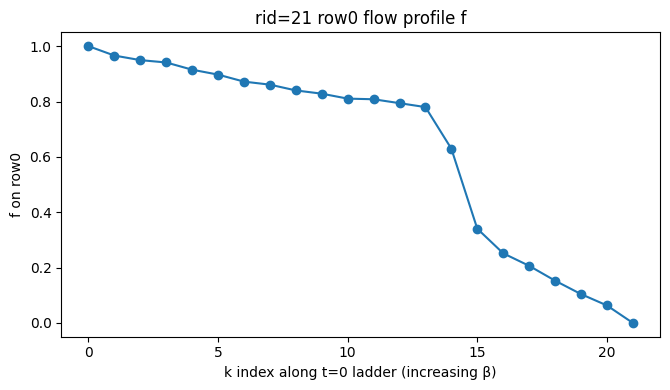

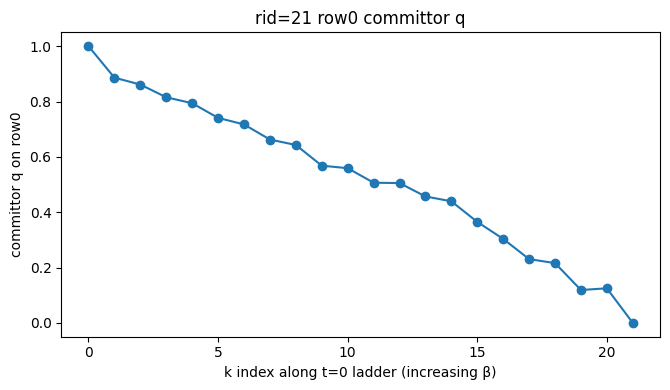

{'rid': 22, 'rt_cnt_chain': [1928, 1830], 'rt_med_chain': [3943.5, 3972.0], 'rt_med_wall': 3951.0, 'rt_med_emb0': 254.0, 'tau_hc_med_wall': 786.0, 'tau_hc_med_emb0': 46.0, 'tmax_med': 0.5, 'phi_med': 0.8274111675126904, 'phi_mean': 0.8226133683399561, 'inflation': 15.55511811023622}


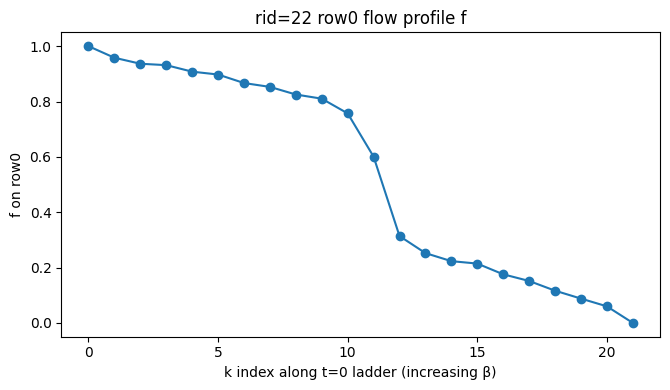

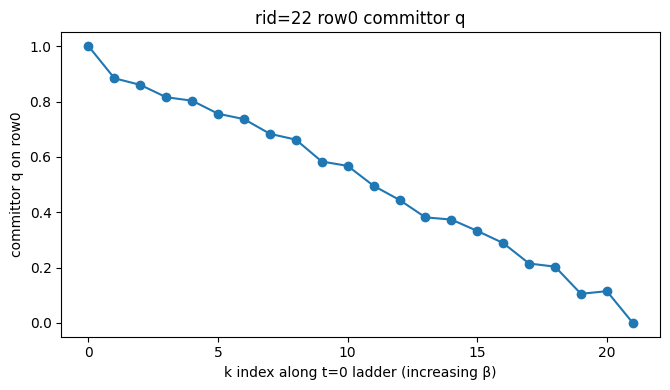

{'rid': 23, 'rt_cnt_chain': [2052, 2130], 'rt_med_chain': [3061.5, 3001.5], 'rt_med_wall': 3034.5, 'rt_med_emb0': 205.0, 'tau_hc_med_wall': 813.0, 'tau_hc_med_emb0': 51.0, 'tmax_med': 0.5, 'phi_med': 0.8125, 'phi_mean': 0.8104034895994014, 'inflation': 14.802439024390244}


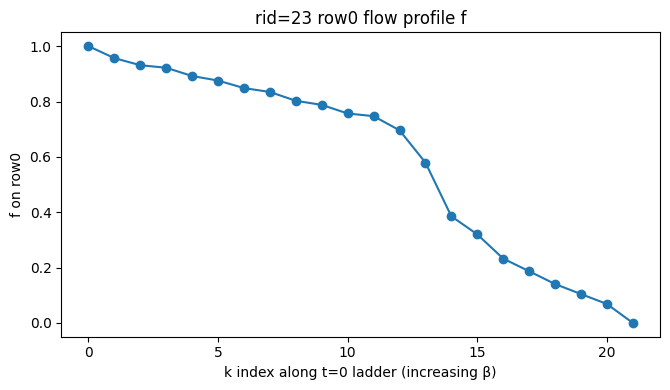

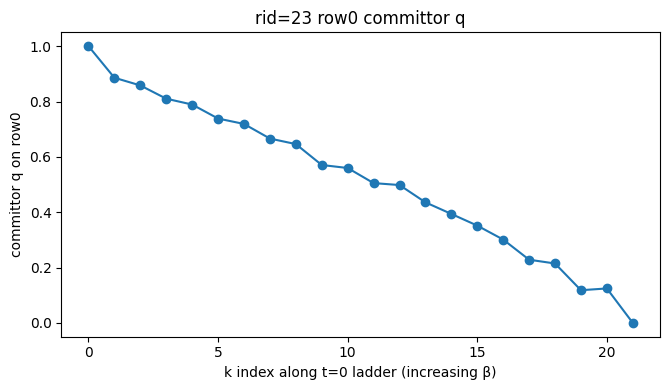

{'rid': 24, 'rt_cnt_chain': [2145, 2122], 'rt_med_chain': [3396.0, 3313.5], 'rt_med_wall': 3345.0, 'rt_med_emb0': 227.0, 'tau_hc_med_wall': 798.0, 'tau_hc_med_emb0': 47.0, 'tmax_med': 0.5, 'phi_med': 0.8174904942965779, 'phi_mean': 0.817434509671297, 'inflation': 14.73568281938326}


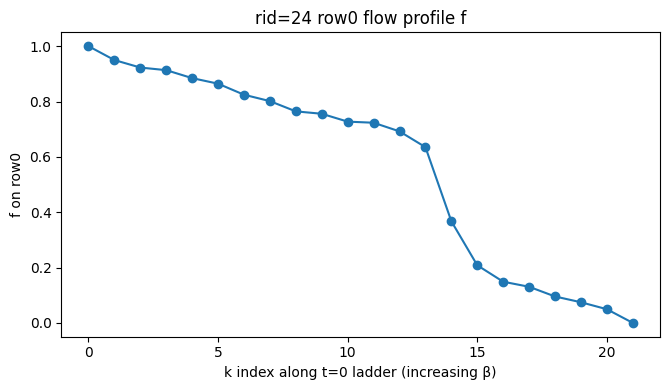

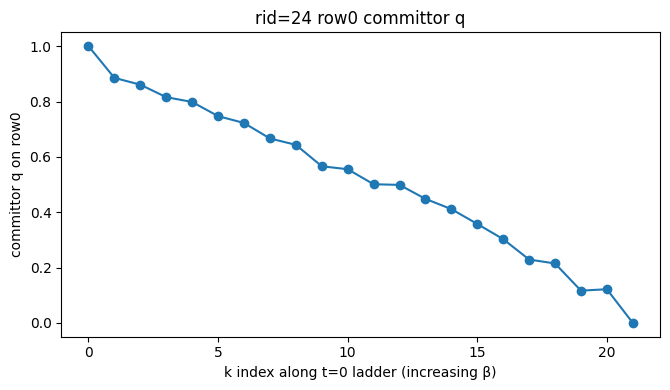

{'rid': 25, 'rt_cnt_chain': [1664, 1634], 'rt_med_chain': [2896.5, 2889.0], 'rt_med_wall': 2895.0, 'rt_med_emb0': 193.0, 'tau_hc_med_wall': 819.0, 'tau_hc_med_emb0': 50.0, 'tmax_med': 0.5, 'phi_med': 0.8172757475083057, 'phi_mean': 0.8164392537006204, 'inflation': 15.0}


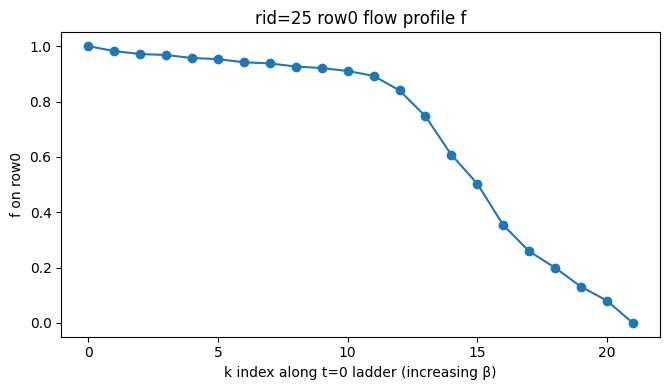

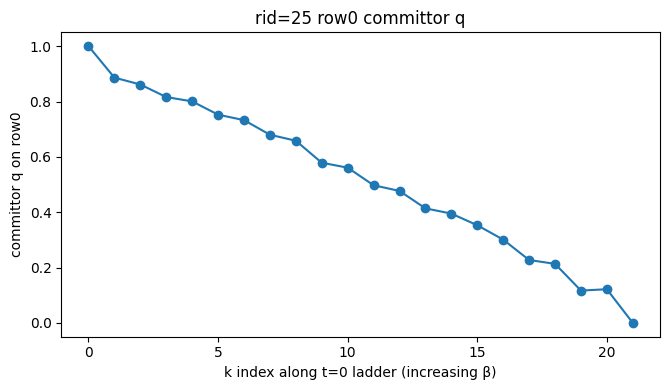

{'rid': 26, 'rt_cnt_chain': [1148, 1129], 'rt_med_chain': [3427.5, 3303.0], 'rt_med_wall': 3369.0, 'rt_med_emb0': 221.0, 'tau_hc_med_wall': 966.0, 'tau_hc_med_emb0': 59.0, 'tmax_med': 0.5, 'phi_med': 0.8152250567241062, 'phi_mean': 0.8165046946248296, 'inflation': 15.244343891402714}


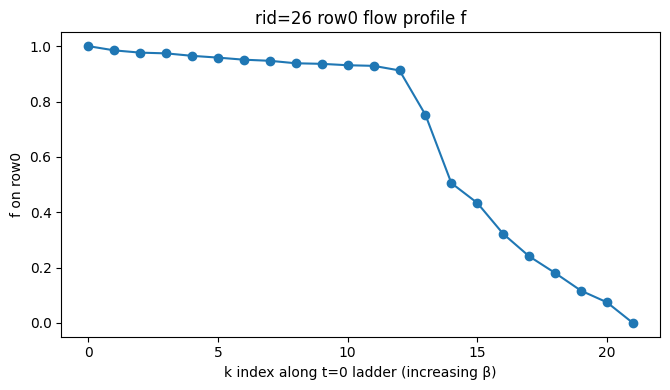

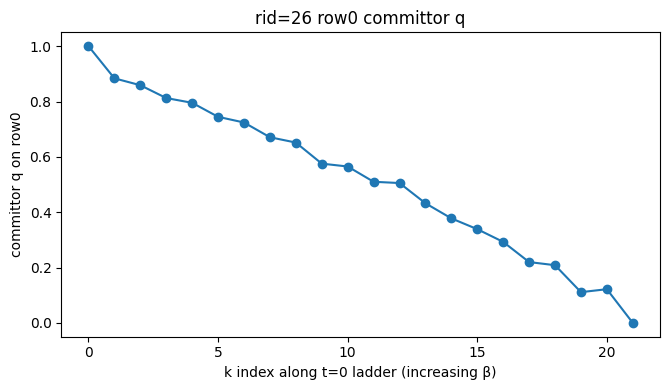

{'rid': 27, 'rt_cnt_chain': [2610, 2644], 'rt_med_chain': [3156.0, 3036.0], 'rt_med_wall': 3099.0, 'rt_med_emb0': 205.0, 'tau_hc_med_wall': 747.0, 'tau_hc_med_emb0': 45.0, 'tmax_med': 0.5, 'phi_med': 0.8203738154758444, 'phi_mean': 0.8159144785944819, 'inflation': 15.117073170731707}


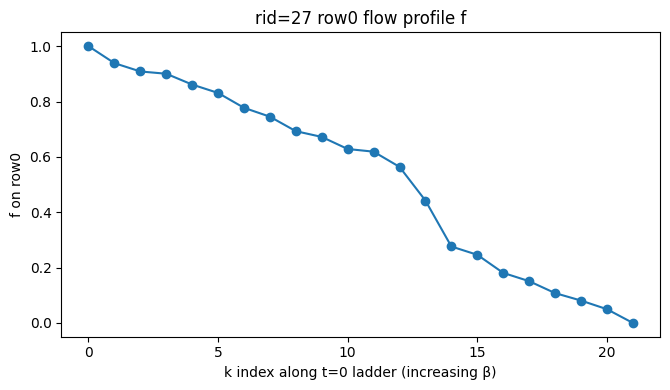

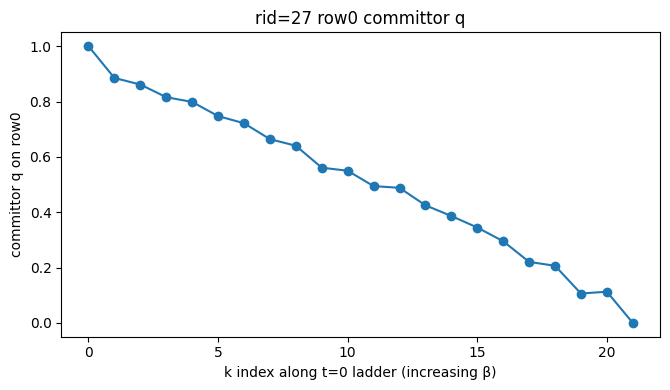

In [ ]:
for rid in range(2):
    res = next(r for r in results if r.rid == rid)

    M = pt2d_transport_metrics(res, meta, ends, burn_in=0., stride=3, record_detours=True)
    print(M["summary"])

    F = pt2d_flow_field(res, meta, ends, burn_in=0., stride=3)
    plot_row0_flow(res, sys2, burn_in=0., stride=3)

    # Optional: committor from empirical transition kernel (more "rigorous", needs enough stats)
    plot_row0_committor(res, sys2, burn_in=0., stride=3)


In [23]:
for b0 in range(sys2.B):
    S = pt2d_analyze_all(results, sys2, b0=b0, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
    p_in = np.nanmedian(S["rt_med_emb0"] / np.maximum(1, S["rt_med_wall"]))
    print("b0", b0, "t=", sys2.t_grid[b0], "median p_in =", p_in, "slope~", 1/max(p_in,1e-12))


b0 0 t= 0.0 median p_in = 0.19779095036164446 slope~ 5.055843041208823
b0 1 t= 0.05 median p_in = 0.20349988630587557 slope~ 4.914007659428984
b0 2 t= 0.1 median p_in = 0.21243582315324536 slope~ 4.707303999658417
b0 3 t= 0.2 median p_in = 0.20919273069134497 slope~ 4.780280828569793
b0 4 t= 0.5 median p_in = 0.17225660416072086 slope~ 5.805292661330816


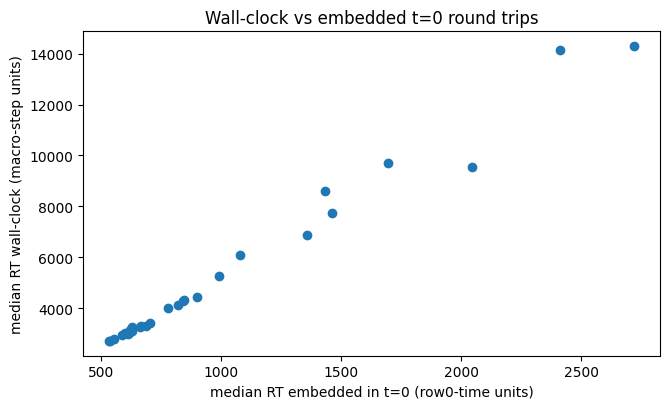

In [18]:
S = pt2d_analyze_all(results, sys2, b0=0, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
plot_rt_wall_vs_emb0(S)      # shows "inflation" due to detours


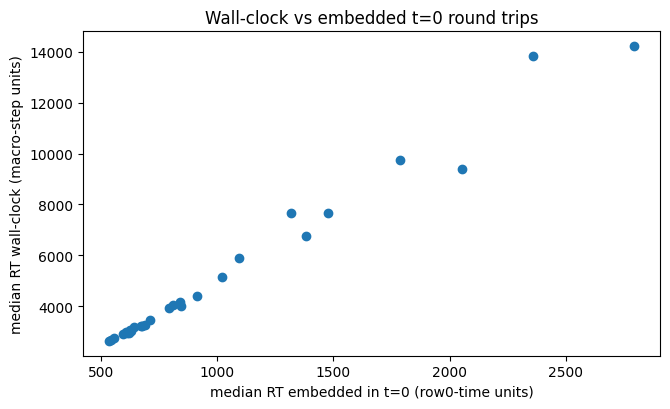

In [19]:
S = pt2d_analyze_all(results, sys2, b0=1, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
plot_rt_wall_vs_emb0(S)      # shows "inflation" due to detours


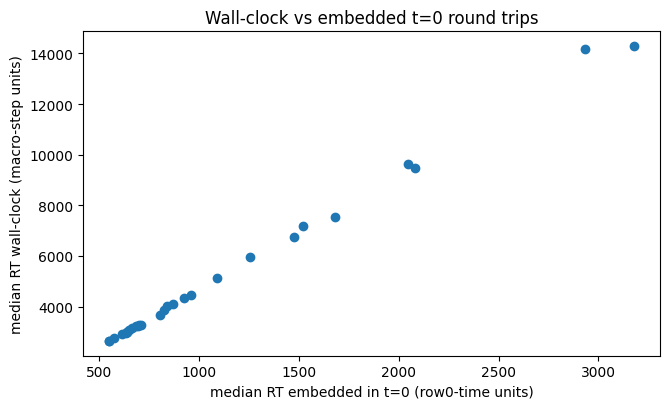

In [21]:
S = pt2d_analyze_all(results, sys2, b0=2, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
plot_rt_wall_vs_emb0(S)      # shows "inflation" due to detours


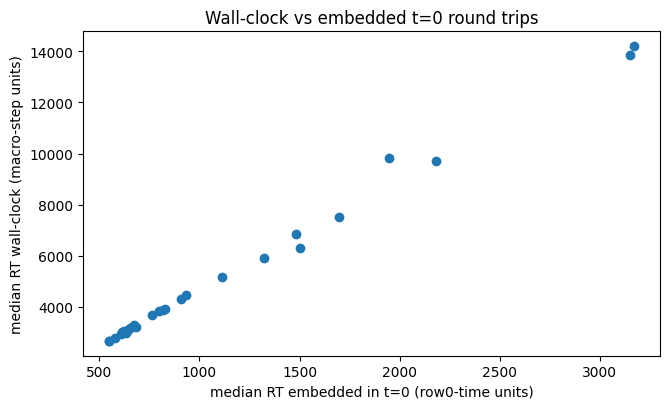

In [22]:
S = pt2d_analyze_all(results, sys2, b0=3, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
plot_rt_wall_vs_emb0(S)      # shows "inflation" due to detours

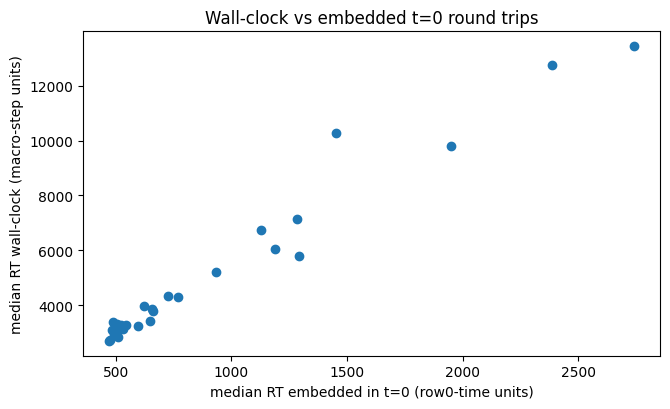

In [20]:
S = pt2d_analyze_all(results, sys2, b0=4, hot_k=0, cold_top=1, burn_in=0.0, stride=1)
plot_rt_wall_vs_emb0(S)      # shows "inflation" due to detours

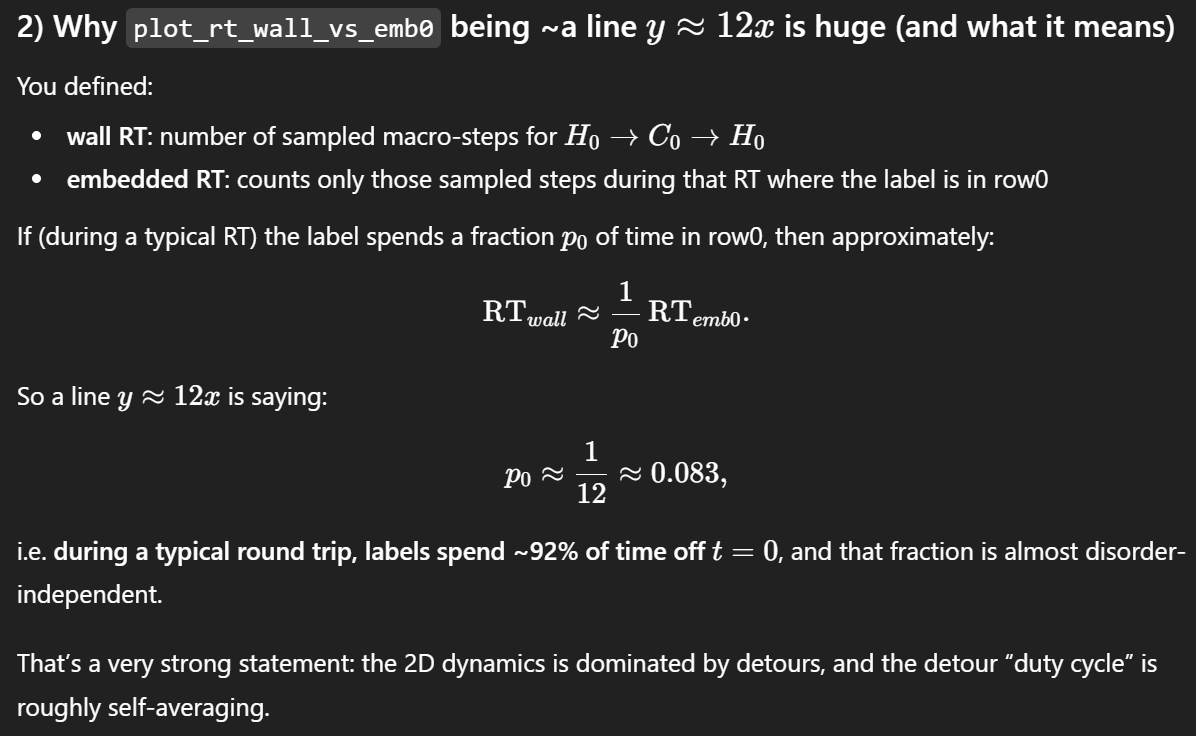

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Utilities (reuse your existing pt2d_meta, pt2d_endpoints_row0, _get_perm_ts, _burn_index)
# ------------------------------------------------------------

def _row0_bounds(meta, ends):
    """Return (r0, r1, K0) for the row0 ladder."""
    b0 = ends.b0
    r0, r1 = int(meta.k_start[b0]), int(meta.k_start[b0 + 1])
    return r0, r1, (r1 - r0)

def _sample_indices(T, burn_in, stride):
    t0 = max(0, min(_burn_index(T, burn_in), T - 1))
    stride = int(max(1, stride))
    return np.arange(t0, T, stride, dtype=np.int64)

# ============================================================
# 1) Round-trip detours: phi_RT and tmax_RT for H0->C0->H0
# ============================================================

def pt2d_roundtrip_detours(res, meta, ends, *, burn_in=0.1, stride=3):
    """
    Compute detour usage over FULL round trips H0->C0->H0 (row0 endpoints).

    Outputs are pooled over 2 chains:
      phi_rt: fraction of steps off row0 during the full RT
      tmax_rt: max t reached during the full RT
      rt_wall: wall-clock RT length in sampled ticks (stride units)
    """
    I2 = _get_perm_ts(res)  # (2,T,R)
    R = meta.R
    b0 = ends.b0
    hot_idx = np.asarray(ends.hot_idx, dtype=np.int64)
    cold_idx = np.asarray(ends.cold_idx, dtype=np.int64)

    b_of_r = np.asarray(meta.b_of_r, dtype=np.int64)
    t_of_r = np.asarray(meta.t_of_r, dtype=np.float64)

    out_phi, out_tmax, out_rt = [], [], []
    pos = np.empty(R, dtype=np.int64)

    for chain in (0, 1):
        I = I2[chain]
        T = I.shape[0]
        idxs = _sample_indices(T, burn_in, stride)

        # stage per label:
        # 0 inactive, 1 started at hot (H->C leg), 2 has reached cold (C->H leg)
        stage = np.zeros(R, dtype=np.int8)

        # accumulators for FULL RT
        step_cnt = np.zeros(R, dtype=np.int64)
        off_cnt  = np.zeros(R, dtype=np.int64)
        tmax     = np.full(R, -np.inf, dtype=np.float64)

        # start time (wall-clock) for RT
        t_start = np.full(R, -1, dtype=np.int64)

        for tt in idxs:
            It = I[tt]
            pos[It] = np.arange(R, dtype=np.int64)  # label -> box
            b_lab = b_of_r[pos]                     # label -> row index
            t_lab = t_of_r[pos]                     # label -> t

            # advance detour counters for active labels (stage 1 or 2)
            active = (stage != 0)
            if active.any():
                a = np.flatnonzero(active)
                step_cnt[a] += 1
                off_cnt[a]  += (b_lab[a] != b0)
                tmax[a]      = np.maximum(tmax[a], t_lab[a])

            # observe which labels are at hot/cold ENDPOINTS (sets)
            wH = np.ravel(It[hot_idx])
            wC = np.ravel(It[cold_idx])

            # cold hit: promote stage 1 -> stage 2
            for w in wC:
                w = int(w)
                if stage[w] == 1:
                    stage[w] = 2

            # hot hit: either start or close RT
            for w in wH:
                w = int(w)
                if stage[w] == 0:
                    # start a new RT
                    stage[w] = 1
                    t_start[w] = tt
                    step_cnt[w] = 0
                    off_cnt[w] = 0
                    tmax[w] = t_lab[w]
                elif stage[w] == 2:
                    # close a FULL RT
                    rt_len = tt - t_start[w]
                    if step_cnt[w] > 0:
                        out_phi.append(float(off_cnt[w]) / float(step_cnt[w]))
                    else:
                        out_phi.append(np.nan)
                    out_tmax.append(float(tmax[w]))
                    out_rt.append(int(rt_len))

                    # reset
                    stage[w] = 1       # restart at hot immediately (like 1D logic)
                    t_start[w] = tt
                    step_cnt[w] = 0
                    off_cnt[w] = 0
                    tmax[w] = t_lab[w]

    return dict(
        phi_rt=np.asarray(out_phi, dtype=np.float64),
        tmax_rt=np.asarray(out_tmax, dtype=np.float64),
        rt_wall=np.asarray(out_rt, dtype=np.int64),
    )

def plot_phiRT_vs_rtwall(det, *, title=None):
    x = det["phi_rt"]
    y = det["rt_wall"]
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("phi_RT (fraction off row0 during full H0->C0->H0)")
    ax.set_ylabel("RT_wall (sampled ticks; stride units)")
    ax.set_title(title or "Full round-trip detour fraction vs wall-clock RT")
    plt.tight_layout(); plt.show()

# ============================================================
# 2) Embedded row0 kernel on k (only when label is in row0)
# ============================================================

def pt2d_row0_embedded_kernel(res, meta, ends, *, burn_in=0.1, stride=3):
    """
    Build empirical transition matrix on row0 index k (0..K0-1),
    using the embedded chain: only consecutive visits of a label to row0 are counted.

    Returns:
      C (K0,K0) counts, P (K0,K0) row-stochastic, visits (K0,)
    """
    I2 = _get_perm_ts(res)  # (2,T,R)
    R = meta.R
    b0 = ends.b0

    b_of_r = np.asarray(meta.b_of_r, dtype=np.int64)

    r0, r1, K0 = _row0_bounds(meta, ends)
    pos = np.empty(R, dtype=np.int64)

    # last seen k in row0 per label; -1 means "not currently in embedded chain"
    last_k = np.full(R, -1, dtype=np.int64)

    C = np.zeros((K0, K0), dtype=np.int64)
    visits = np.zeros(K0, dtype=np.int64)

    for chain in (0, 1):
        I = I2[chain]
        T = I.shape[0]
        idxs = _sample_indices(T, burn_in, stride)

        last_k.fill(-1)

        for tt in idxs:
            It = I[tt]
            pos[It] = np.arange(R, dtype=np.int64)  # label -> box
            box = pos                               # alias

            # labels currently in row0
            in0 = (b_of_r[box] == b0)
            labels0 = np.flatnonzero(in0)
            if labels0.size == 0:
                continue

            # k position along row0 for those labels
            k_now = box[labels0] - r0  # since row0 boxes are contiguous [r0,r1)
            # update visits
            np.add.at(visits, k_now, 1)

            # count embedded transitions: last_k[w] -> k_now (only if last_k[w]!=-1)
            lk = last_k[labels0]
            have_prev = (lk >= 0)
            if have_prev.any():
                u = lk[have_prev]
                v = k_now[have_prev]
                # accumulate counts
                for uu, vv in zip(u, v):
                    C[int(uu), int(vv)] += 1

            # update last_k for labels in row0
            last_k[labels0] = k_now

            # labels not in row0: keep their last_k as-is?  NO.
            # For embedded chain we WANT to break continuity when leaving row0.
            labels_out = np.flatnonzero(~in0)
            if labels_out.size:
                last_k[labels_out] = -1

    # normalize
    P = np.zeros_like(C, dtype=np.float64)
    row_sum = C.sum(axis=1)
    m = row_sum > 0
    P[m] = C[m] / row_sum[m, None]
    return dict(C=C, P=P, visits=visits)

def committor_on_row0(P, hot_ks, cold_ks, *, tol=1e-12, max_iter=20000, omega=1.0):
    """
    Solve q = P q on free nodes with q=1 on hot_ks and q=0 on cold_ks.
    """
    P = np.asarray(P, dtype=np.float64)
    K0 = P.shape[0]
    hot = np.zeros(K0, dtype=bool); hot[np.asarray(hot_ks, dtype=np.int64)] = True
    cold = np.zeros(K0, dtype=bool); cold[np.asarray(cold_ks, dtype=np.int64)] = True
    free = ~(hot | cold)

    q = np.zeros(K0, dtype=np.float64)
    q[hot] = 1.0
    q[cold] = 0.0

    free_idx = np.flatnonzero(free)
    for it in range(max_iter):
        maxdiff = 0.0
        for k in free_idx:
            val = float(P[k] @ q)
            new = (1 - omega) * q[k] + omega * val
            diff = abs(new - q[k])
            if diff > maxdiff:
                maxdiff = diff
            q[k] = new
        if maxdiff < tol:
            break
    return q

def plot_row0_committor_embedded(res, sys, *, b0=0, hot_k=0, cold_top=1, burn_in=0.1, stride=3, title=None):
    meta = pt2d_meta(sys)
    ends = pt2d_endpoints_row0(meta, b0=b0, hot_k=hot_k, cold_top=cold_top)
    K = int(_row0_bounds(meta, ends)[2])

    ker = pt2d_row0_embedded_kernel(res, meta, ends, burn_in=burn_in, stride=stride)
    P = ker["P"]

    hot_ks = [int(hot_k)]
    cold_ks = list(range(max(0, K - int(cold_top)), K))
    q = committor_on_row0(P, hot_ks, cold_ks)

    fig, ax = plt.subplots(figsize=(6.8, 4.0))
    ax.plot(np.arange(K), q, marker="o")
    ax.set_xlabel("k along row0 (increasing beta)")
    ax.set_ylabel("embedded committor q_emb(k)")
    ax.set_title(title or f"rid={int(res.rid)} embedded row0 committor")
    plt.tight_layout(); plt.show()
    return dict(kernel=ker, q=q)

# ============================================================
# 3) Batch plots you probably want next
# ============================================================

def pt2d_add_phiRT_to_summary(results, sys, *, b0=0, hot_k=0, cold_top=1, burn_in=0.1, stride=3):
    meta = pt2d_meta(sys)
    ends = pt2d_endpoints_row0(meta, b0=b0, hot_k=hot_k, cold_top=cold_top)

    rid = []
    phiRT_med = []
    rtwall_med = []
    for res in results:
        det = pt2d_roundtrip_detours(res, meta, ends, burn_in=burn_in, stride=stride)
        rid.append(int(res.rid))
        phiRT_med.append(float(np.nanmedian(det["phi_rt"])) if det["phi_rt"].size else np.nan)
        rtwall_med.append(float(np.median(det["rt_wall"])) if det["rt_wall"].size else np.nan)

    return dict(rid=np.asarray(rid), phiRT_med=np.asarray(phiRT_med), rtwall_med=np.asarray(rtwall_med))

def plot_phiRTmed_vs_rtwallmed(S2, *, title=None,annotate_rid = True):
    x = S2["phiRT_med"]; y = S2["rtwall_med"]
    m = np.isfinite(x) & np.isfinite(y)
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x[m], y[m], marker="o", linestyle="none")
    if annotate_rid:
        ann_kwargs = {} 
        annotate_points(ax, x, y, S2["rid"], **ann_kwargs)
    ax.set_xlabel("median phi_RT per disorder")
    ax.set_ylabel("median RT_wall per disorder")
    ax.set_title(title or "Disorders: median full-RT detour fraction vs median wall RT")
    plt.tight_layout(); plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def annotate_points(ax, x, y, labels, *, fontsize=8, dx=2, dy=2, alpha=0.9):
    """
    Annotate each (x[i], y[i]) with labels[i].
    dx, dy are pixel offsets (so labels don't sit exactly on the marker).
    """
    x = np.asarray(x); y = np.asarray(y)
    labels = np.asarray(labels)
    m = np.isfinite(x) & np.isfinite(y)
    for xi, yi, lab in zip(x[m], y[m], labels[m]):
        ax.annotate(str(lab), (xi, yi),
                    textcoords="offset points", xytext=(dx, dy),
                    ha="left", va="bottom",
                    fontsize=fontsize, alpha=alpha)

def plot_detour_phi_vs_rt(summary, *, title=None, annotate_rid=False, ann_kwargs=None):
    x = summary["phi_med"]
    y = summary["rt_med_wall"]
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median detour fraction φ (H0→C0)")
    ax.set_ylabel("median wall-clock RT (macro-step units)")
    ax.set_title(title or "Detour usage vs wall-clock RT")

    if annotate_rid:
        ann_kwargs = {} if ann_kwargs is None else dict(ann_kwargs)
        annotate_points(ax, x, y, summary["rid"], **ann_kwargs)

    plt.tight_layout(); plt.show()

def plot_rt_wall_vs_emb0(summary, *, title=None, annotate_rid=False, ann_kwargs=None):
    x = summary["rt_med_emb0"]
    y = summary["rt_med_wall"]
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median RT embedded in t=0 (row0-time units)")
    ax.set_ylabel("median RT wall-clock (macro-step units)")
    ax.set_title(title or "Wall-clock vs embedded t=0 round trips")

    if annotate_rid:
        ann_kwargs = {} if ann_kwargs is None else dict(ann_kwargs)
        annotate_points(ax, x, y, summary["rid"], **ann_kwargs)

    plt.tight_layout(); plt.show()


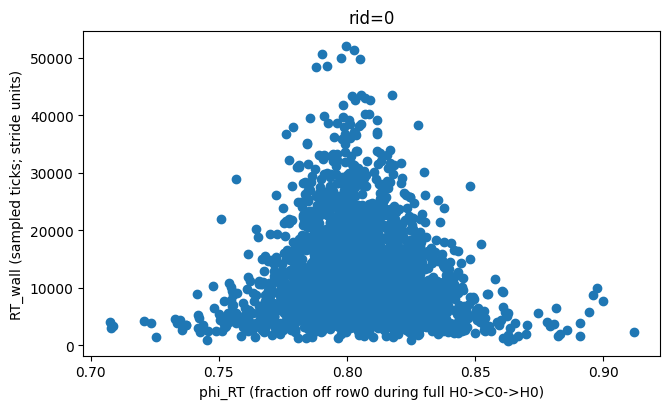

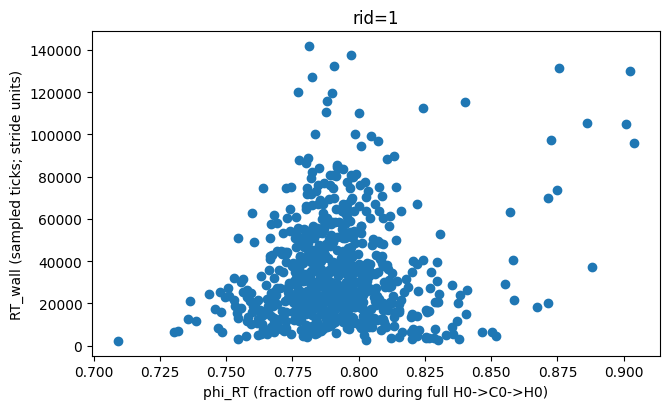

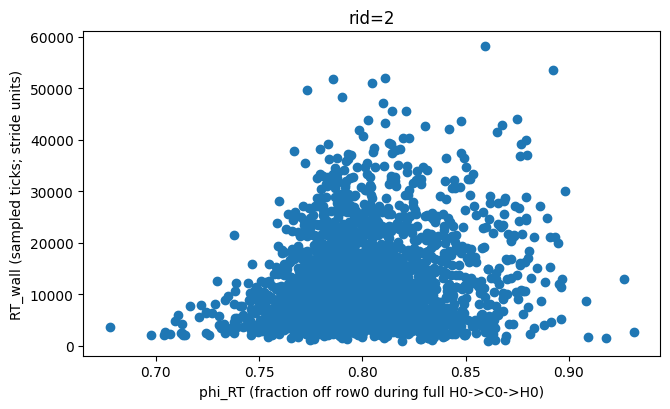

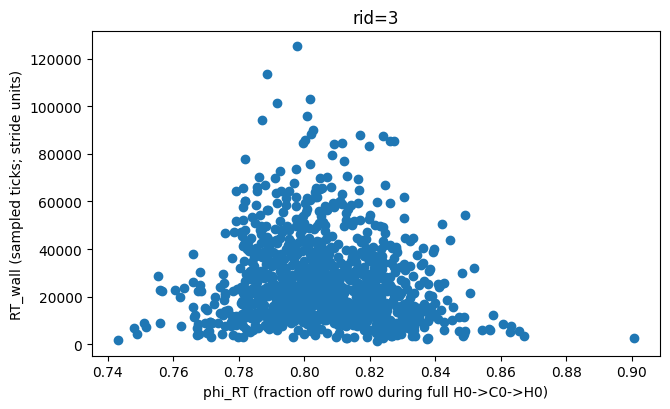

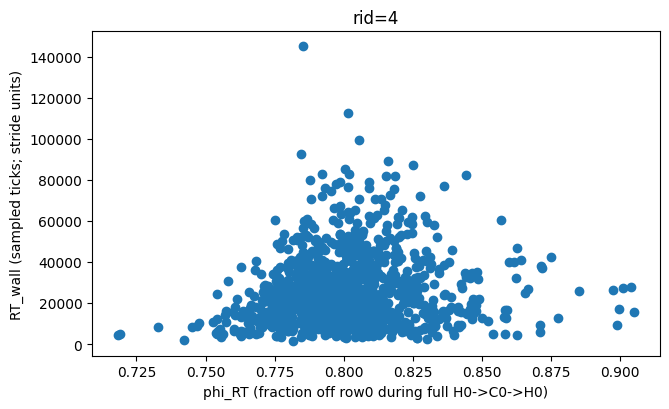

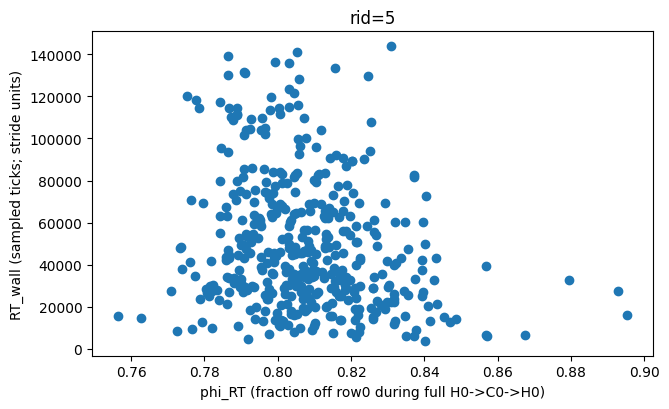

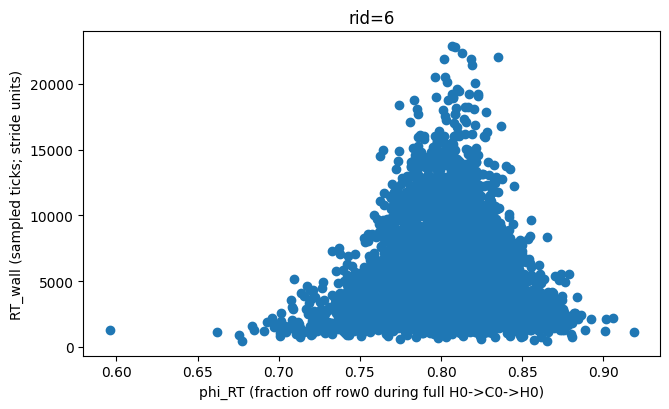

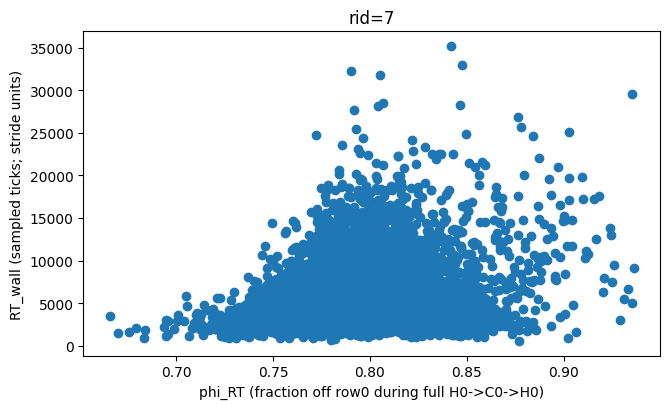

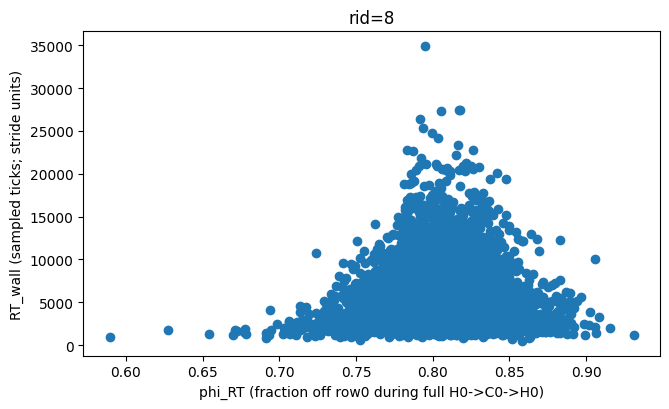

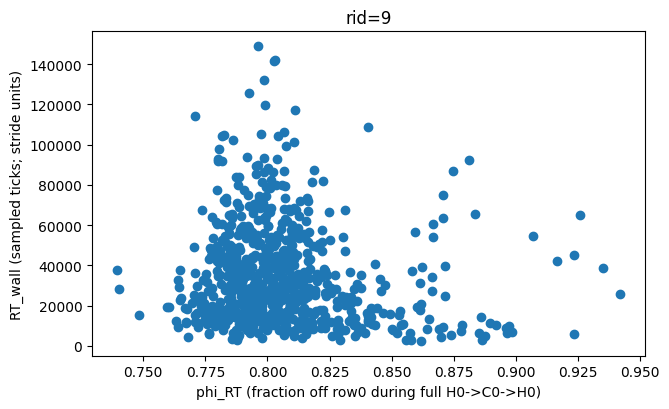

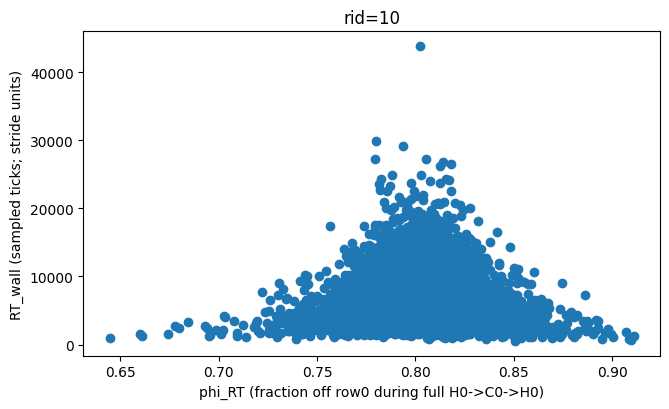

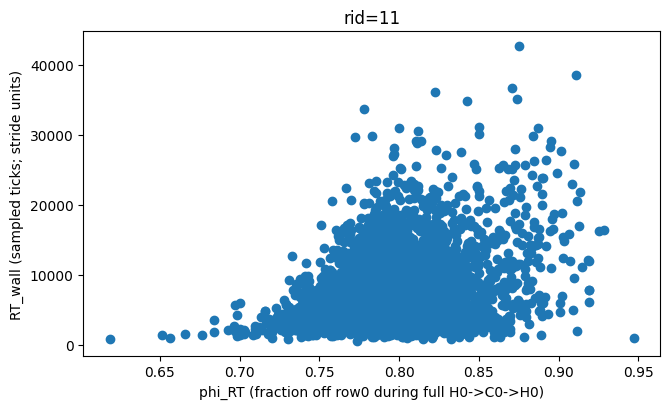

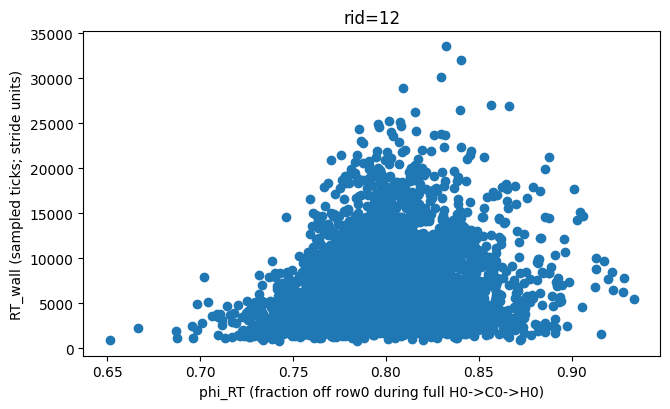

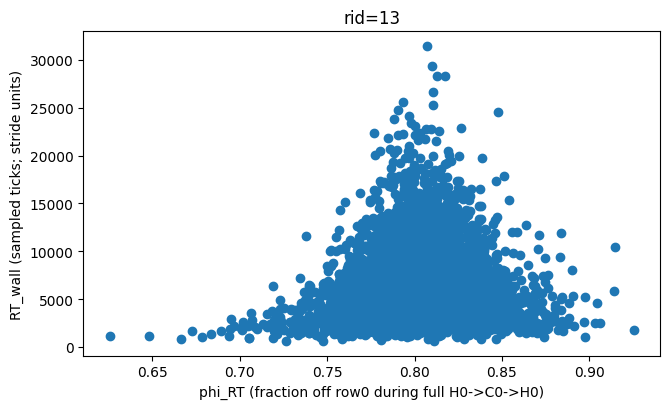

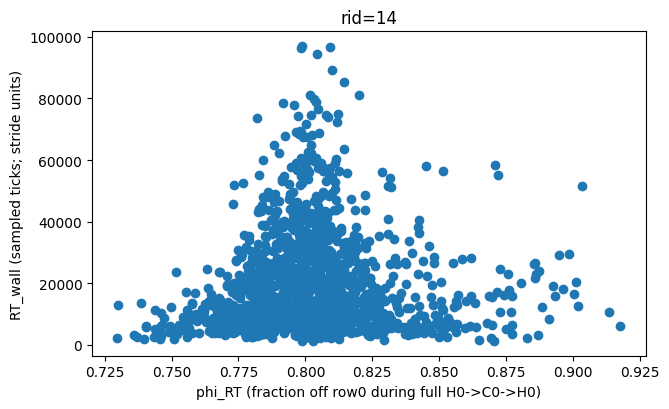

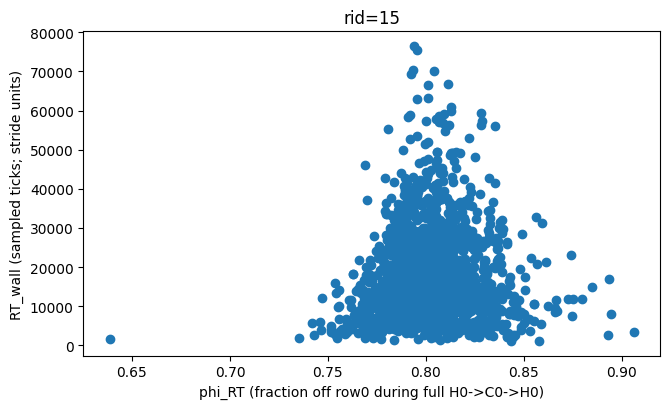

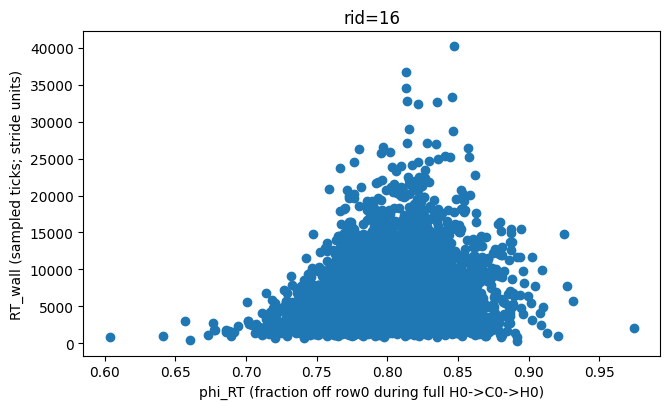

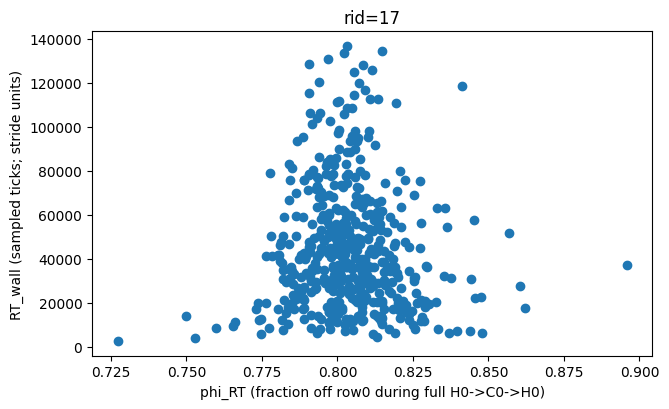

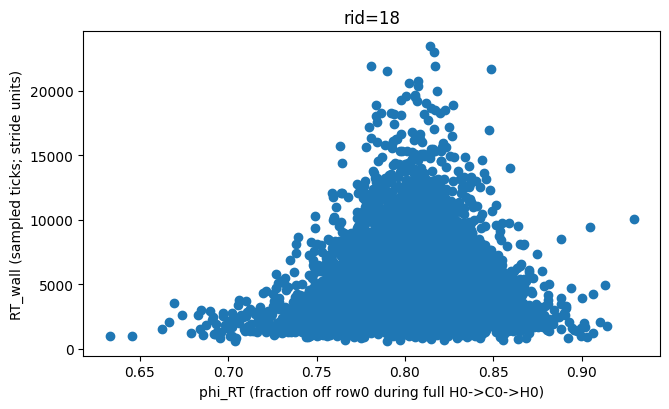

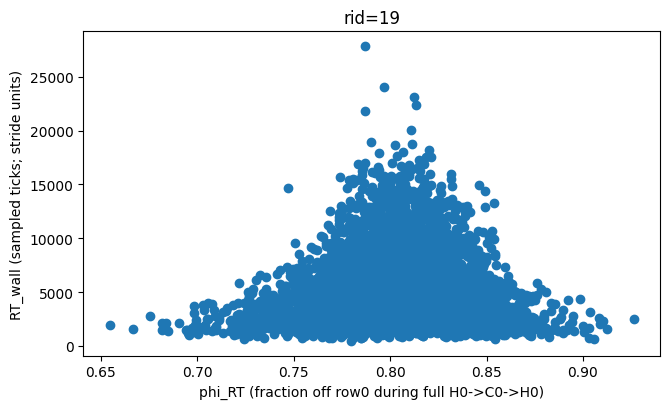

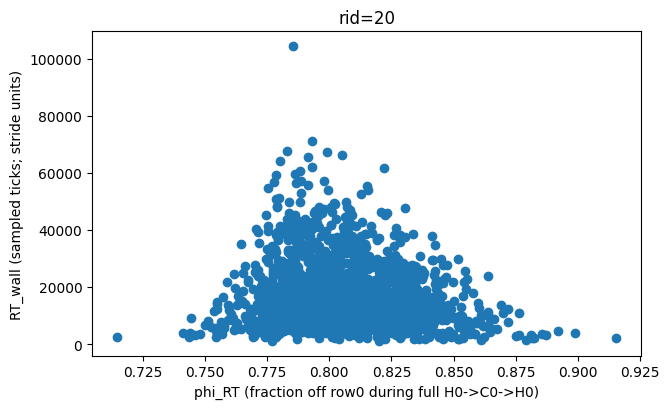

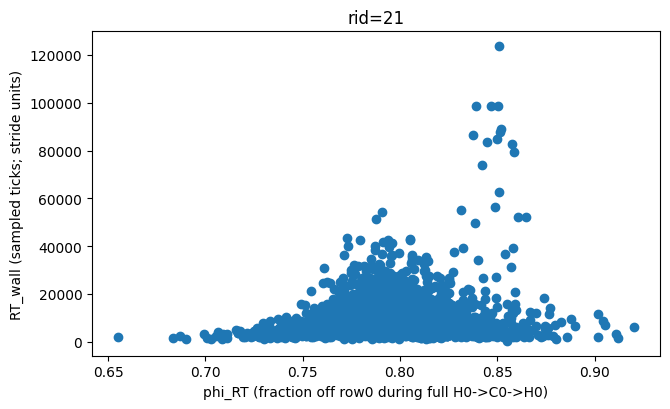

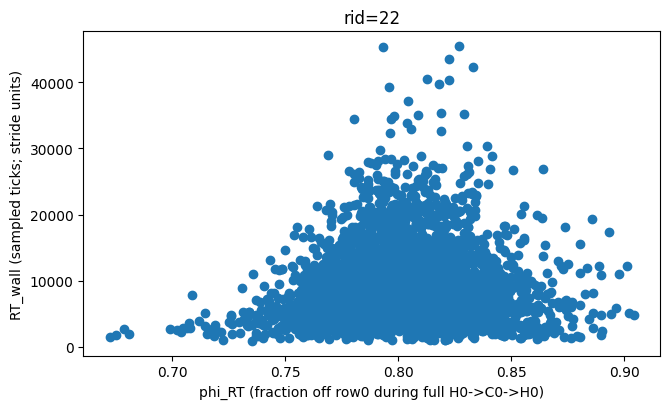

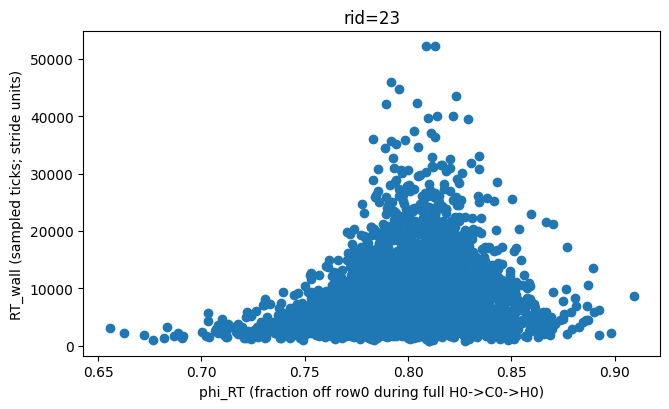

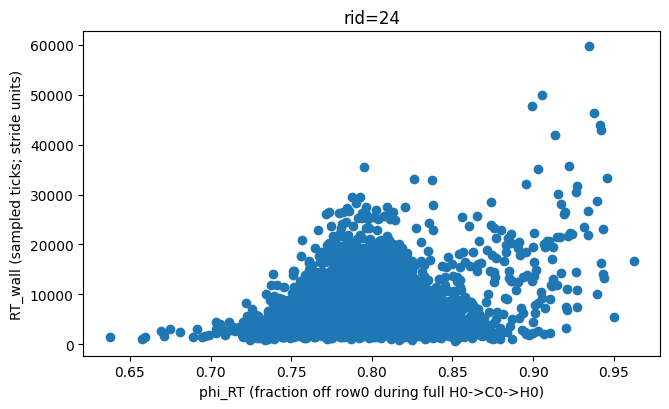

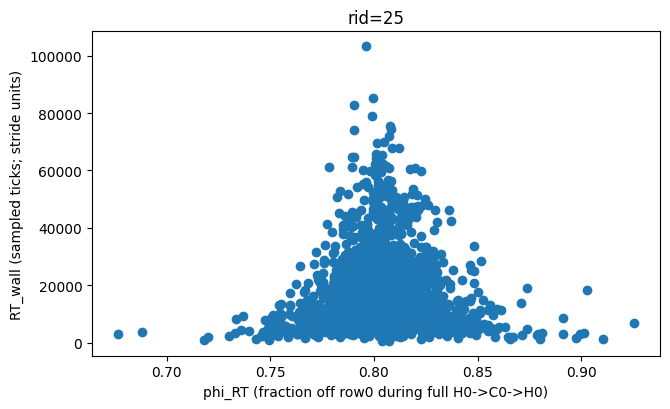

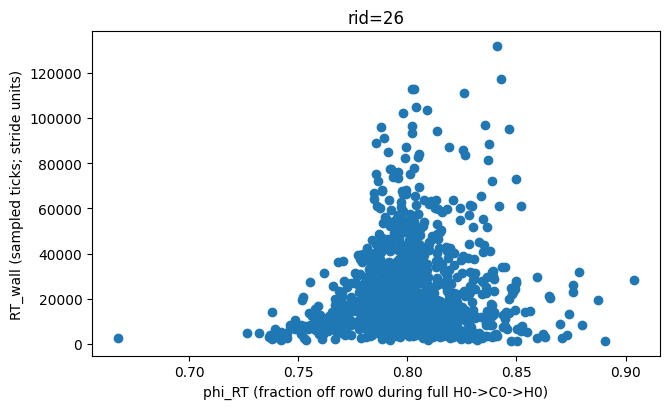

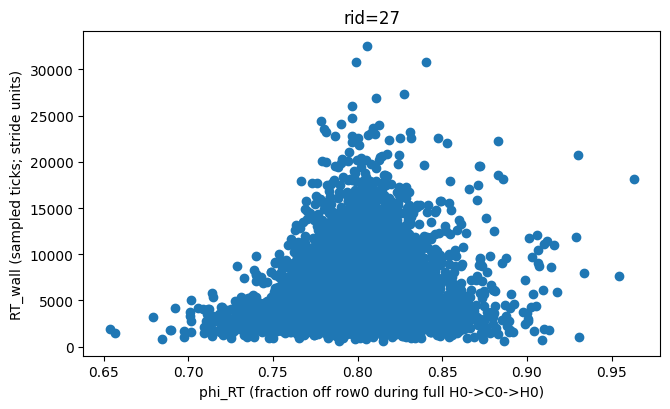

In [42]:
meta = pt2d_meta(sys2)
ends = pt2d_endpoints_row0(meta, b0=0, hot_k=0, cold_top=1)

for rid in range(28):
    res = next(r for r in results if r.rid == rid)

    det = pt2d_roundtrip_detours(res, meta, ends, burn_in=0.0, stride=3)
    plot_phiRT_vs_rtwall(det, title=f"rid={rid}")


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def detour_clt_diagnostics(det, *, stride=3, n_bins=12, min_per_bin=50, title=None):
    """
    CLT-style diagnostics for phi_RT = X/N where X counts off-row0 ticks in a round trip.
    We only have phi_RT and rt_wall; we reconstruct N ≈ rt_wall/stride.

    det: dict from pt2d_roundtrip_detours with keys:
         - "phi_rt": (M,) float
         - "rt_wall": (M,) int

    stride: same stride you used when generating det (e.g. 3 for macro-step sampling).
    """

    phi = np.asarray(det["phi_rt"], dtype=np.float64)
    rt  = np.asarray(det["rt_wall"], dtype=np.float64)

    m = np.isfinite(phi) & np.isfinite(rt) & (rt > 0)
    phi = phi[m]
    rt  = rt[m]

    # Reconstruct number of Bernoulli trials (ticks sampled during RT)
    N = np.maximum(1.0, np.rint(rt / float(stride)))  # approximate but good for large RT

    # Reconstruct X (integer off-row0 count) from phi and N
    X = np.rint(phi * N)

    # Global p-hat (pooled, weighted by N)
    p_hat = float(X.sum() / N.sum()) if N.sum() > 0 else np.nan
    eps = 1e-12
    p_hat = min(max(p_hat, eps), 1.0 - eps)  # avoid 0/1 degeneracy

    # z-score under Binomial(N, p_hat)
    sigma = np.sqrt(p_hat * (1.0 - p_hat) / N)
    z = (phi - p_hat) / sigma

    # ------------------------------------------------------------
    # Plot 1: scatter phi vs N (or vs rt)
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(phi, N, marker="o", linestyle="none")
    ax.axvline(p_hat, linestyle="--")
    ax.set_xlabel("phi_RT (fraction off row0 during full RT)")
    ax.set_ylabel(f"N ≈ rt_wall/stride (stride={stride})")
    ax.set_title(title or "phi_RT vs N (RT-level)")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # Plot 2: std(phi | N-bin) vs 1/sqrt(N) + prediction
    # ------------------------------------------------------------
    # log-bins in N
    Nmin, Nmax = float(np.min(N)), float(np.max(N))
    edges = np.logspace(np.log10(max(1.0, Nmin)), np.log10(Nmax), n_bins + 1)

    x_inv_sqrt = []
    y_std = []
    y_pred = []
    counts = []

    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        sel = (N >= lo) & (N < hi)
        if np.sum(sel) < min_per_bin:
            continue
        Ni = float(np.median(N[sel]))
        std_phi = float(np.std(phi[sel], ddof=1))
        pred = float(np.sqrt(p_hat * (1.0 - p_hat) / Ni))
        x_inv_sqrt.append(1.0 / np.sqrt(Ni))
        y_std.append(std_phi)
        y_pred.append(pred)
        counts.append(int(np.sum(sel)))

    x_inv_sqrt = np.asarray(x_inv_sqrt)
    y_std = np.asarray(y_std)
    y_pred = np.asarray(y_pred)

    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(x_inv_sqrt, y_std, marker="o", linestyle="none", label="observed std(phi | bin)")
    ax.plot(x_inv_sqrt, y_pred, marker="o", linestyle="-", label="pred sqrt(p(1-p)/N)")
    ax.set_xlabel("1/sqrt(N) (bin median)")
    ax.set_ylabel("std(phi_RT)")
    ax.set_title("CLT scaling check")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # Plot 3: histogram of z with N(0,1) overlay
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.hist(z, bins=60, density=True)

    # Standard normal overlay
    zz = np.linspace(np.nanmin(z), np.nanmax(z), 400)
    pdf = np.exp(-0.5 * zz**2) / np.sqrt(2.0 * np.pi)
    ax.plot(zz, pdf, linestyle="--")

    ax.set_xlabel("z = (phi - p_hat)/sqrt(p_hat(1-p_hat)/N)")
    ax.set_ylabel("density")
    ax.set_title(f"z-hist (p_hat={p_hat:.4f})")
    plt.tight_layout()
    plt.show()

    return dict(
        p_hat=p_hat,
        N=N,
        X=X,
        z=z,
        bins=dict(edges=edges, inv_sqrtN=x_inv_sqrt, std_phi=y_std, pred=y_pred, counts=np.asarray(counts)),
    )


In [46]:
def add_tau_int_estimate(out_clt):
    inv = out_clt["bins"]["inv_sqrtN"]
    std_obs = out_clt["bins"]["std_phi"]
    pred = out_clt["bins"]["pred"]
    tau = (std_obs / pred)**2
    return inv, tau


In [55]:
def pt2d_roundtrip_detours(res, meta, ends, *, burn_in=0.1, stride=3):
    I2 = _get_perm_ts(res)
    R = meta.R
    b0 = ends.b0
    hot_idx  = np.asarray(ends.hot_idx, dtype=np.int64)
    cold_idx = np.asarray(ends.cold_idx, dtype=np.int64)
    b_of_r   = np.asarray(meta.b_of_r, dtype=np.int64)
    t_of_r   = np.asarray(meta.t_of_r, dtype=np.float64)

    out_phi, out_tmax, out_rt = [], [], []
    out_N, out_X = [], []   # <-- NEW

    pos = np.empty(R, dtype=np.int64)

    for chain in (0, 1):
        I = I2[chain]
        T = I.shape[0]
        idxs = _sample_indices(T, burn_in, stride)

        stage   = np.zeros(R, dtype=np.int8)
        step_cnt = np.zeros(R, dtype=np.int64)
        off_cnt  = np.zeros(R, dtype=np.int64)
        tmax     = np.full(R, -np.inf, dtype=np.float64)
        t_start  = np.full(R, -1, dtype=np.int64)

        for tt in idxs:
            It = I[tt]
            pos[It] = np.arange(R, dtype=np.int64)
            b_lab = b_of_r[pos]
            t_lab = t_of_r[pos]

            active = (stage != 0)
            if active.any():
                a = np.flatnonzero(active)
                step_cnt[a] += 1
                off_cnt[a]  += (b_lab[a] != b0)
                tmax[a]      = np.maximum(tmax[a], t_lab[a])

            wH = np.ravel(It[hot_idx])
            wC = np.ravel(It[cold_idx])

            for w in wC:
                w = int(w)
                if stage[w] == 1:
                    stage[w] = 2

            for w in wH:
                w = int(w)
                if stage[w] == 0:
                    stage[w] = 1
                    t_start[w] = tt
                    step_cnt[w] = 0
                    off_cnt[w] = 0
                    tmax[w] = t_lab[w]
                elif stage[w] == 2:
                    rt_len = tt - t_start[w]
                    Nw = int(step_cnt[w])
                    Xw = int(off_cnt[w])

                    out_rt.append(int(rt_len))
                    out_N.append(Nw)                  # <-- NEW
                    out_X.append(Xw)                  # <-- NEW
                    out_phi.append(Xw / max(1, Nw))
                    out_tmax.append(float(tmax[w]))

                    stage[w] = 1
                    t_start[w] = tt
                    step_cnt[w] = 0
                    off_cnt[w] = 0


def clt_bins_tau(det, *, stride=3, n_bins=12, min_per_bin=80):
    phi = np.asarray(det["phi_rt"], dtype=np.float64)

    if "N_ticks" in det:
        N = np.asarray(det["N_ticks"], dtype=np.float64)
    else:
        rt = np.asarray(det["rt_wall"], dtype=np.float64)
        N = np.maximum(1.0, np.rint(rt / float(stride)))  # proxy

    m = np.isfinite(phi) & (N > 0)
    phi = phi[m]; N = N[m]

    # log bins in N
    edges = np.logspace(np.log10(np.min(N)), np.log10(np.max(N)), n_bins + 1)

    inv_sqrtN = []
    tau_est   = []
    std_obs   = []
    pred0     = []   # sqrt(p(1-p)/N) without tau
    counts    = []

    for i in range(n_bins):
        sel = (N >= edges[i]) & (N < edges[i+1])
        if np.sum(sel) < min_per_bin:
            continue

        Ni = float(np.median(N[sel]))

        # bin-wise p_hat (weighted by N via counts X ≈ phi*N)
        X = np.rint(phi[sel] * N[sel])
        p = float(X.sum() / N[sel].sum())
        p = min(max(p, 1e-12), 1 - 1e-12)

        var_phi = float(np.var(phi[sel], ddof=1))
        base = p * (1 - p) / Ni

        tau = var_phi / base if base > 0 else np.nan

        inv_sqrtN.append(1.0 / np.sqrt(Ni))
        tau_est.append(tau)
        std_obs.append(np.sqrt(var_phi))
        pred0.append(np.sqrt(base))
        counts.append(int(np.sum(sel)))

    return dict(
        inv_sqrtN=np.asarray(inv_sqrtN),
        tau_est=np.asarray(tau_est),
        std_obs=np.asarray(std_obs),
        pred0=np.asarray(pred0),
        counts=np.asarray(counts),
        edges=edges
    )

def plot_tau_vs_inv_sqrtN(tb, *, title=None):
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(tb["inv_sqrtN"], tb["tau_est"], marker="o", linestyle="none")
    ax.set_xlabel("1/sqrt(N) (bin median)")
    ax.set_ylabel("tau_int estimate (bin-wise)")
    ax.set_title(title or "Estimated tau_int vs 1/sqrt(N)")
    plt.tight_layout(); plt.show()


In [52]:
def fit_var_A_over_N_plus_B(det, *, n_bins=12, min_per_bin=80):
    phi = np.asarray(det["phi_rt"], dtype=np.float64)
    N   = np.asarray(det["N_ticks"], dtype=np.float64)
    m = np.isfinite(phi) & (N > 0)
    phi = phi[m]; N = N[m]

    edges = np.logspace(np.log10(np.min(N)), np.log10(np.max(N)), n_bins + 1)
    xs, ys = [], []
    for i in range(n_bins):
        sel = (N >= edges[i]) & (N < edges[i+1])
        if np.sum(sel) < min_per_bin: 
            continue
        Ni = float(np.median(N[sel]))
        var_phi = float(np.var(phi[sel], ddof=1))
        xs.append(1.0 / Ni)
        ys.append(var_phi)

    xs = np.asarray(xs); ys = np.asarray(ys)
    # linear fit: ys ≈ A*xs + B
    A, B = np.polyfit(xs, ys, 1)
    return dict(A=A, B=B, xs=xs, ys=ys)

def plot_var_fit(fit, *, title=None):
    xs, ys = fit["xs"], fit["ys"]
    A, B = fit["A"], fit["B"]
    xx = np.linspace(xs.min(), xs.max(), 200)
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.plot(xs, ys, marker="o", linestyle="none", label="binned var(phi)")
    ax.plot(xx, A*xx + B, linestyle="--", label=f"fit: A/N + B (B={B:.2e})")
    ax.set_xlabel("1/N (bin median)")
    ax.set_ylabel("var(phi_RT)")
    ax.set_title(title or "Variance decomposition: A/N + B")
    ax.legend()
    plt.tight_layout(); plt.show()


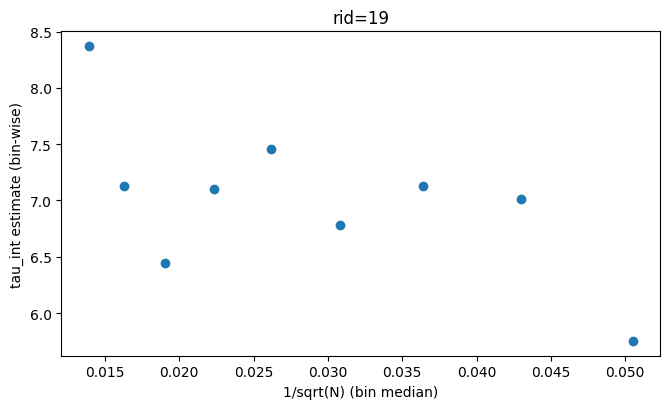

In [60]:
det = pt2d_roundtrip_detours(res, meta, ends, burn_in=0.0, stride=3)
tb = clt_bins_tau(det, n_bins=12, min_per_bin=80)
plot_tau_vs_inv_sqrtN(tb, title=f"rid={rid}")

In [56]:
tb = clt_bins_tau(det, n_bins=12, min_per_bin=80)
plot_tau_vs_inv_sqrtN(tb, title=f"rid={rid}")


TypeError: 'NoneType' object is not subscriptable

In [58]:
det = pt2d_roundtrip_detours(res, meta, ends, burn_in=0.0, stride=3)
print(type(det), det.keys() if det is not None else None)
print("n_events =", 0 if det is None else len(det["phi_rt"]))

<class 'NoneType'> None
n_events = 0


In [57]:
print(det)


None


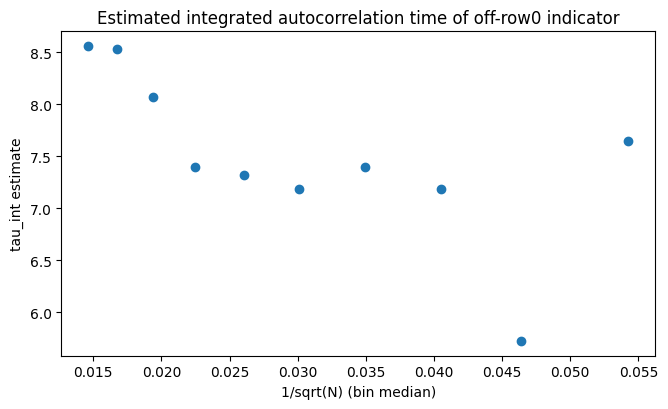

In [47]:
inv, tau = add_tau_int_estimate(out)
plt.figure(figsize=(6.8,4.2))
plt.plot(inv, tau, marker="o", linestyle="none")
plt.xlabel("1/sqrt(N) (bin median)")
plt.ylabel("tau_int estimate")
plt.title("Estimated integrated autocorrelation time of off-row0 indicator")
plt.tight_layout(); plt.show()


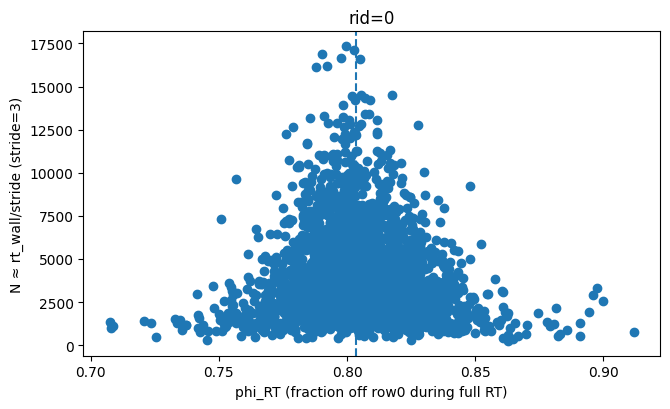

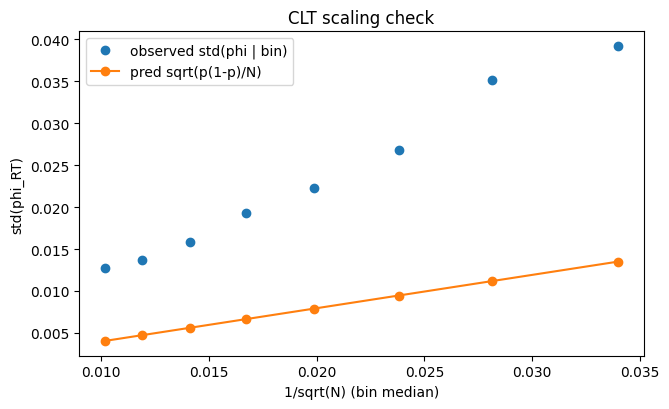

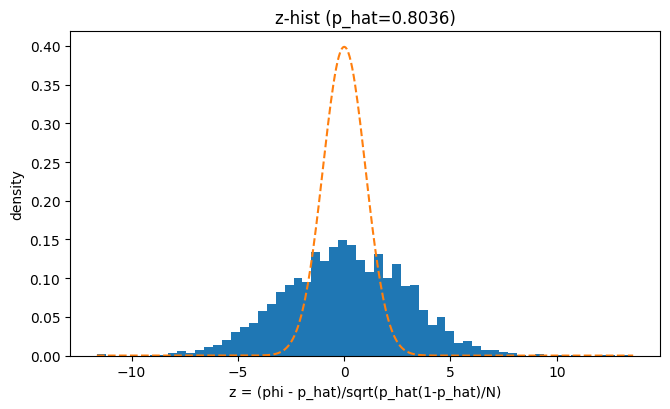

p_hat = 0.8036478008500775


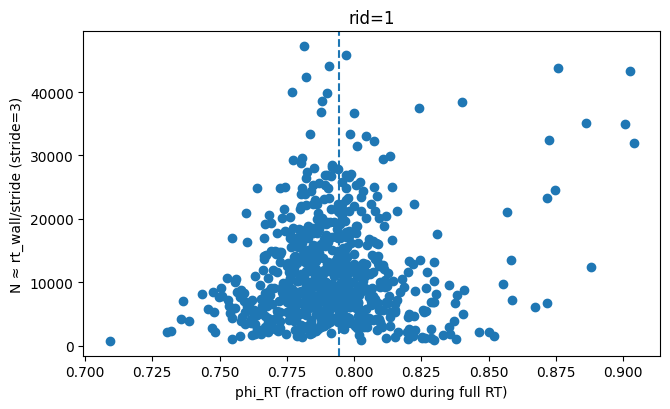

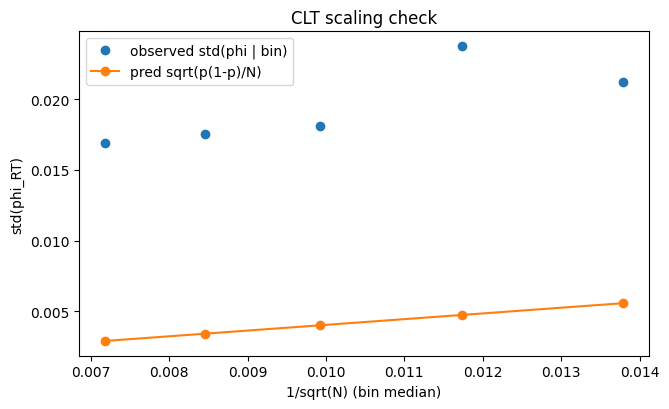

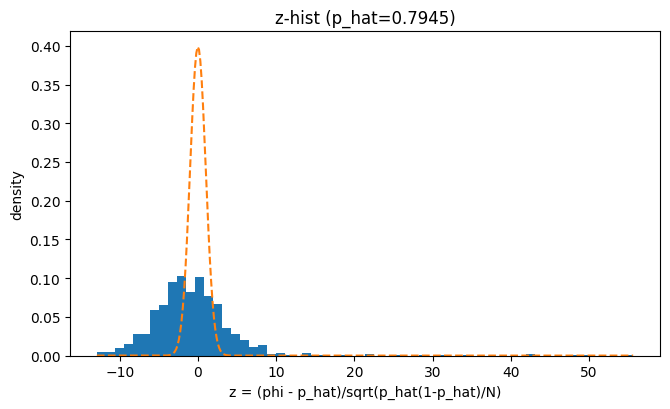

p_hat = 0.7944946595764167


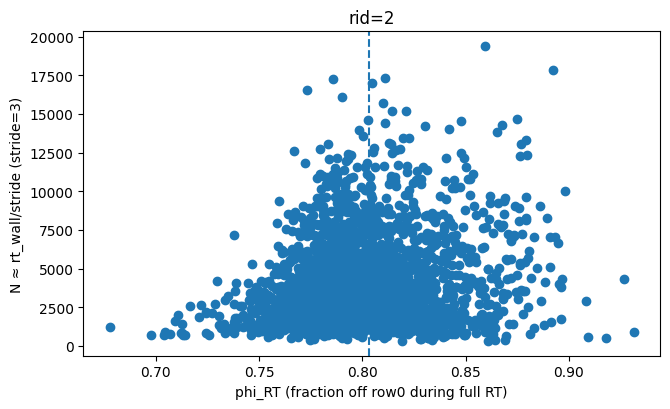

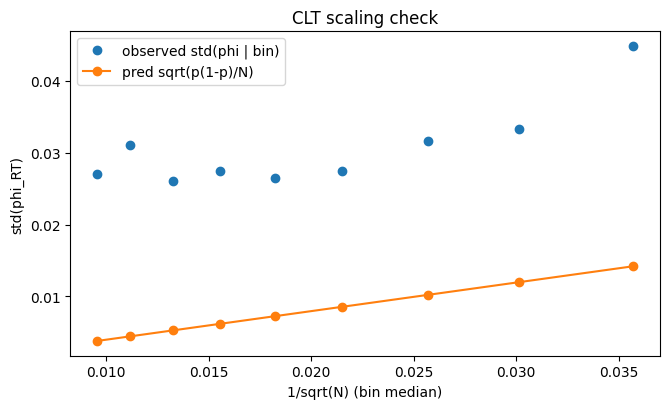

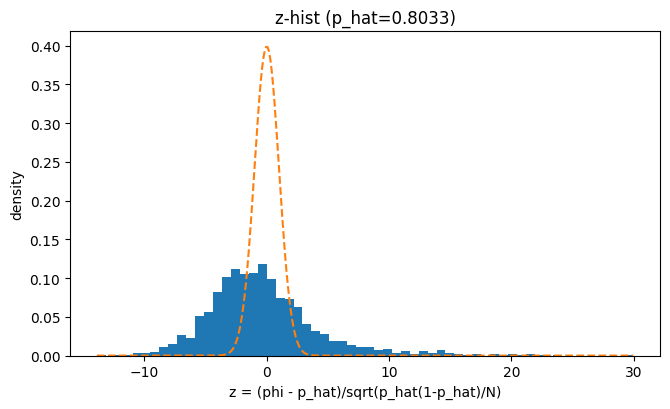

p_hat = 0.8033008523844639


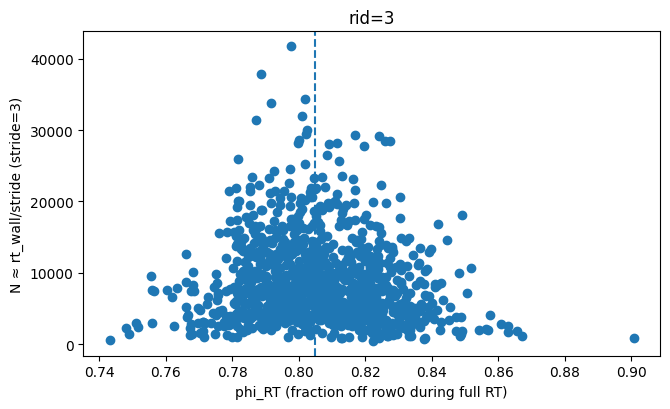

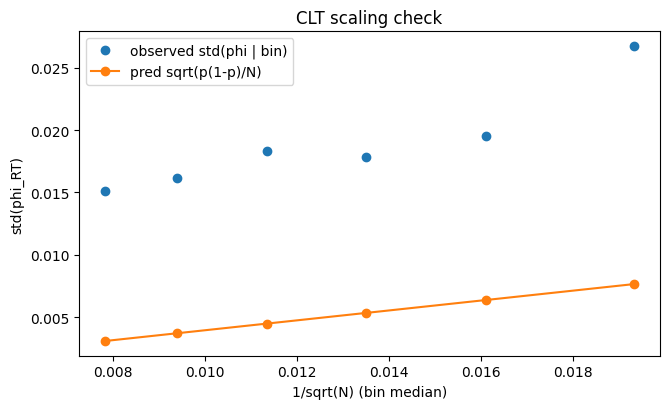

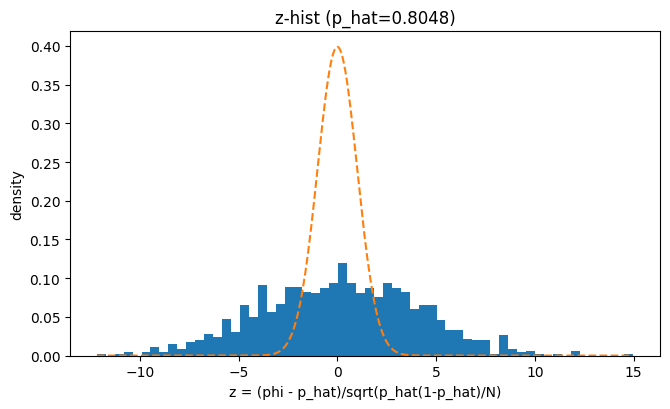

p_hat = 0.8047862650384346


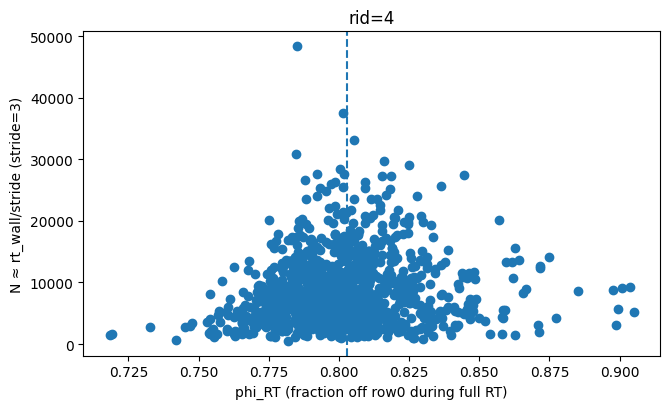

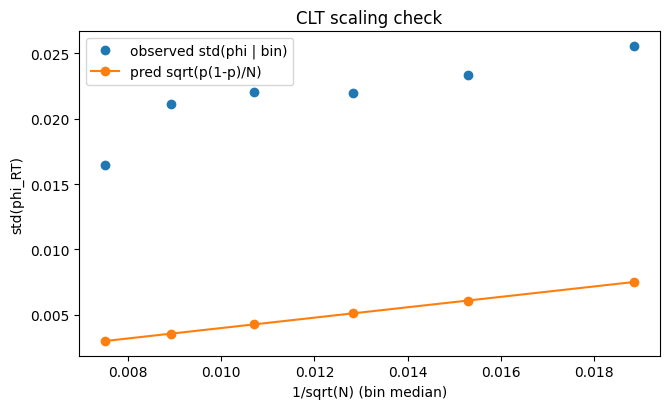

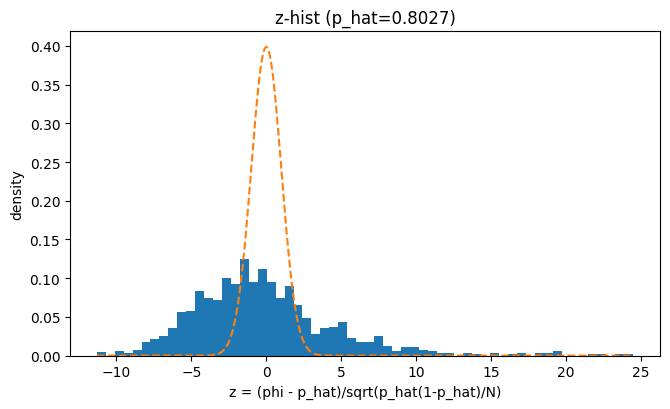

p_hat = 0.8027425142032112


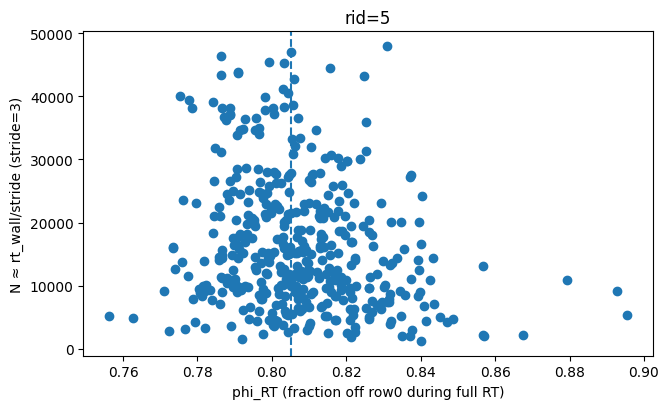

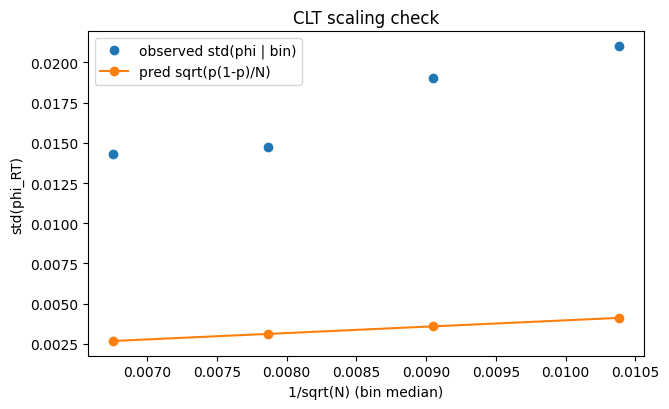

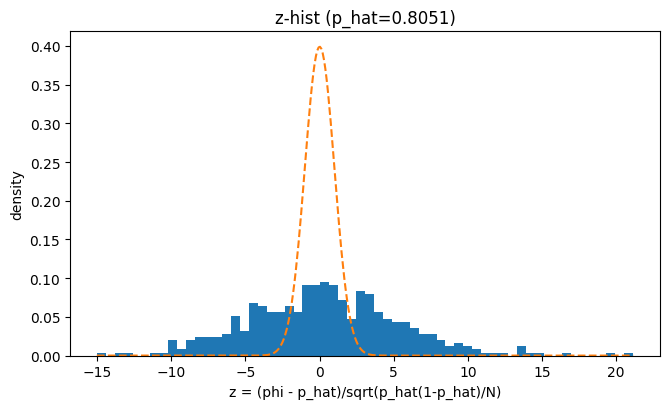

p_hat = 0.8050548047095725


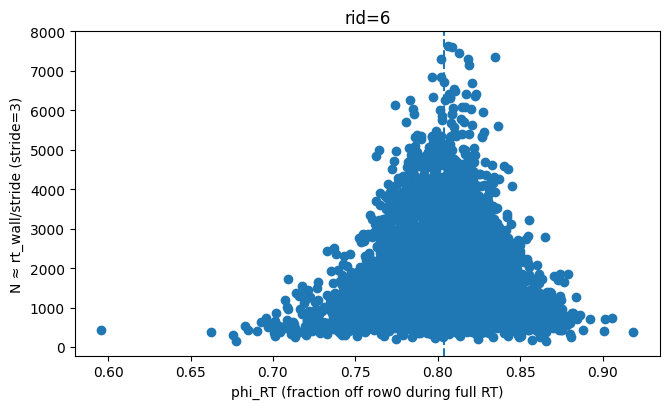

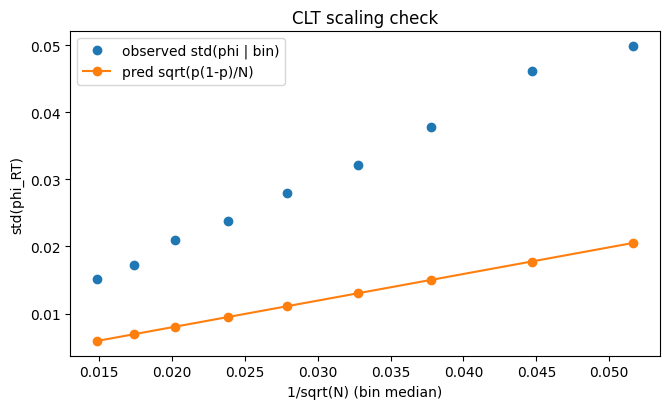

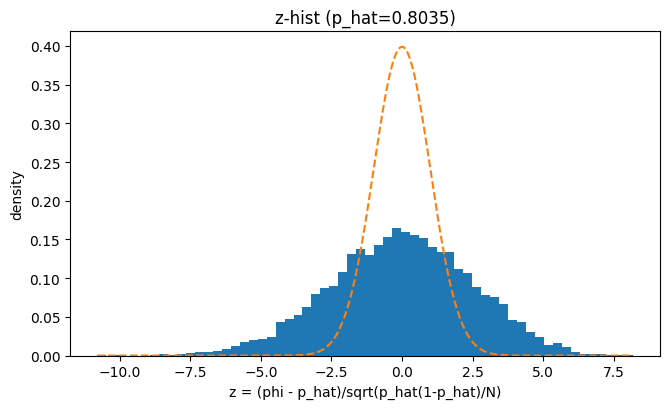

p_hat = 0.8035403648138306


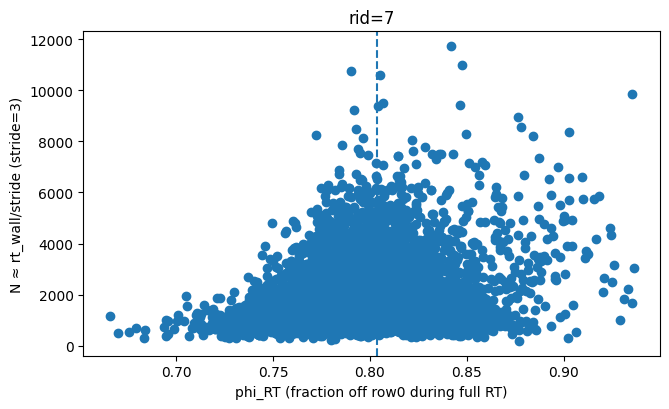

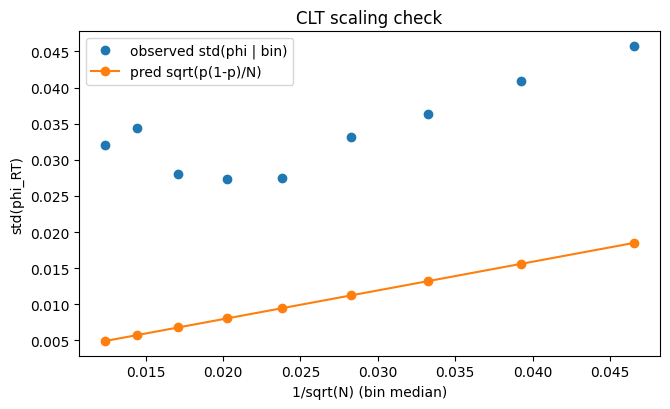

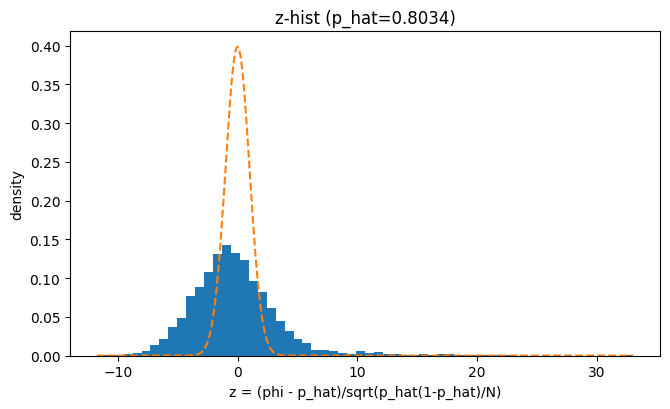

p_hat = 0.8033771109736556


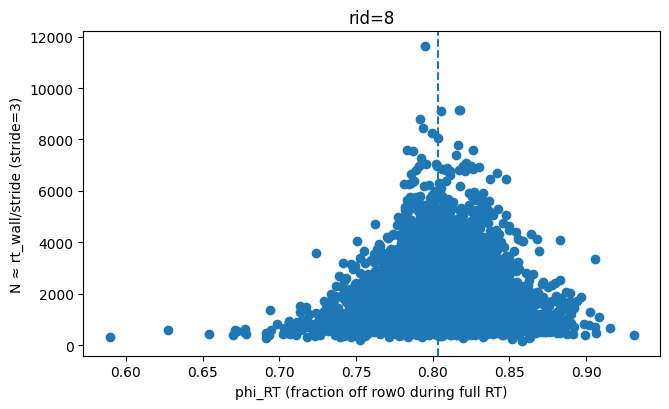

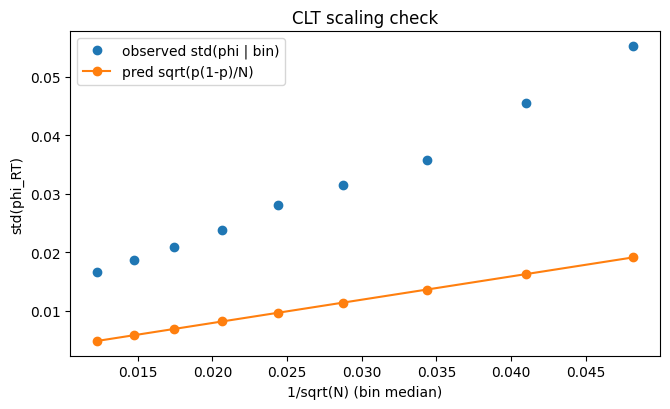

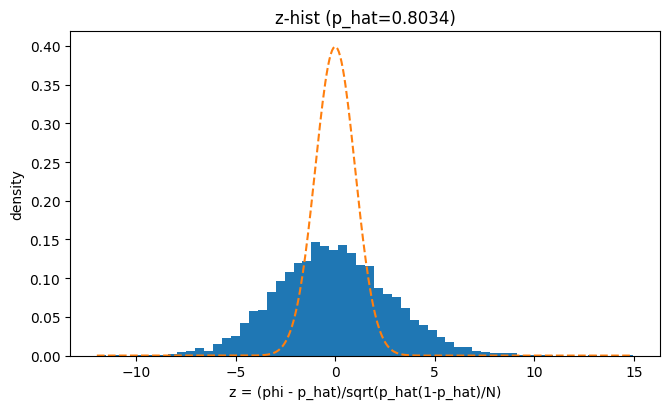

p_hat = 0.8033913163925968


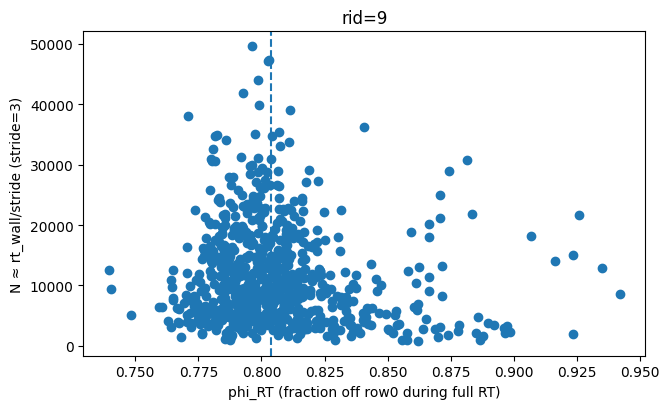

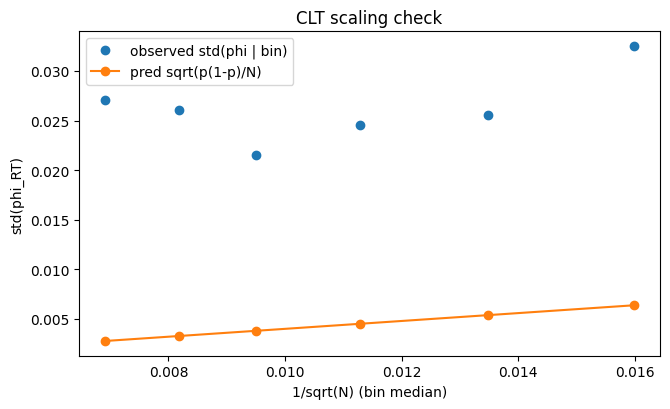

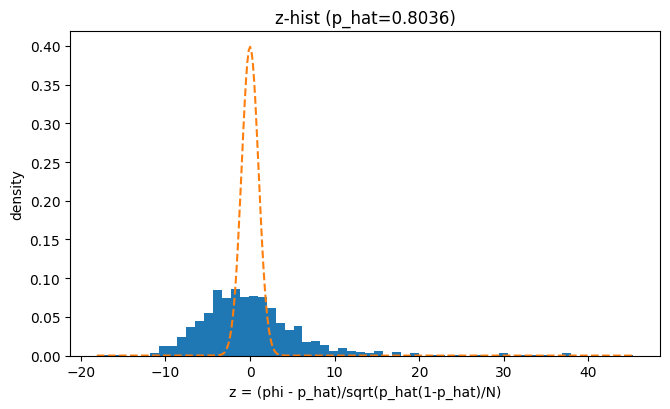

p_hat = 0.8036239482211601


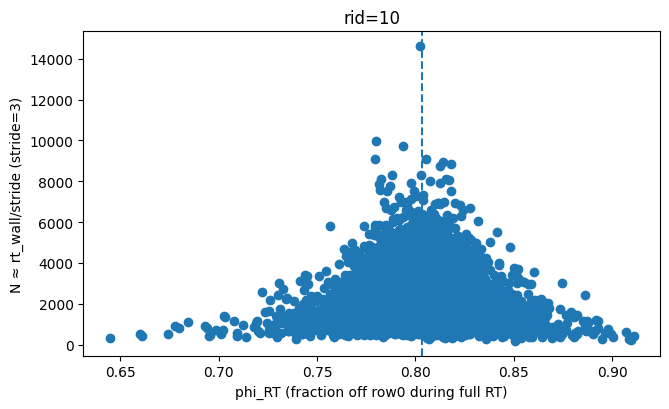

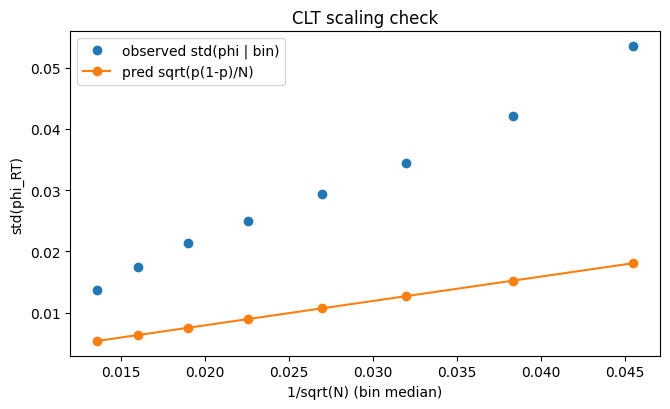

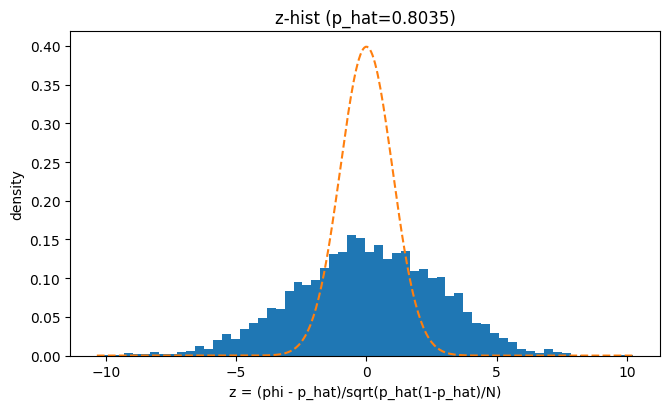

p_hat = 0.803506105073573


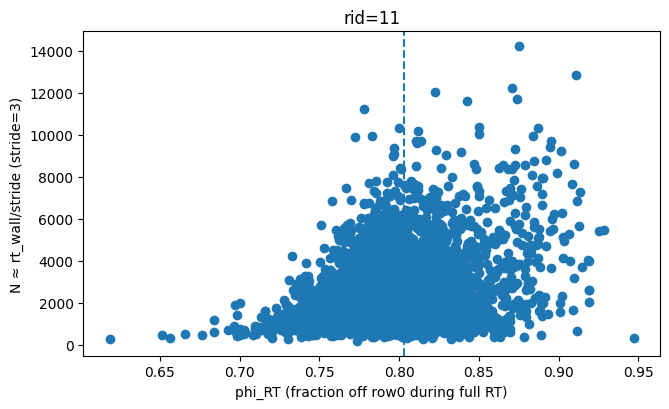

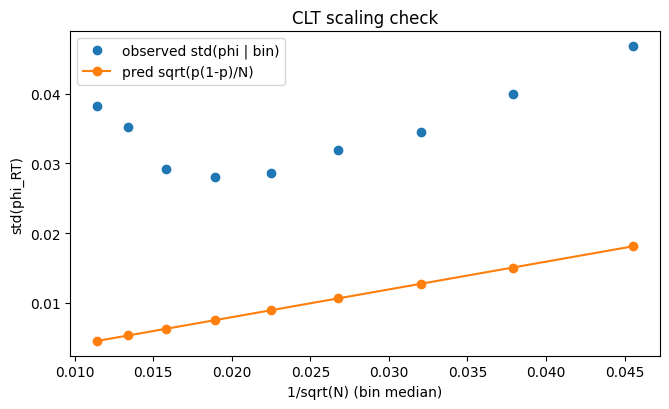

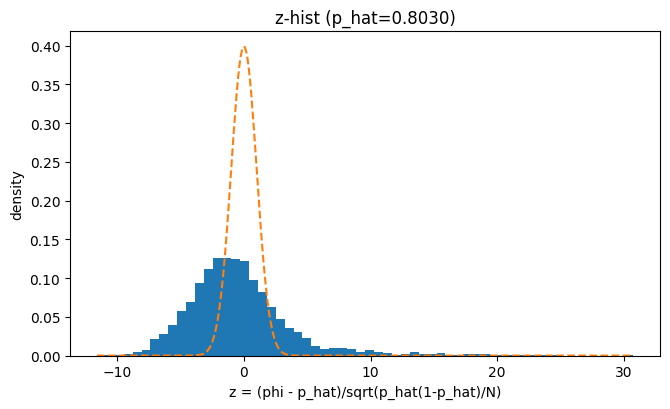

p_hat = 0.8029672077421073


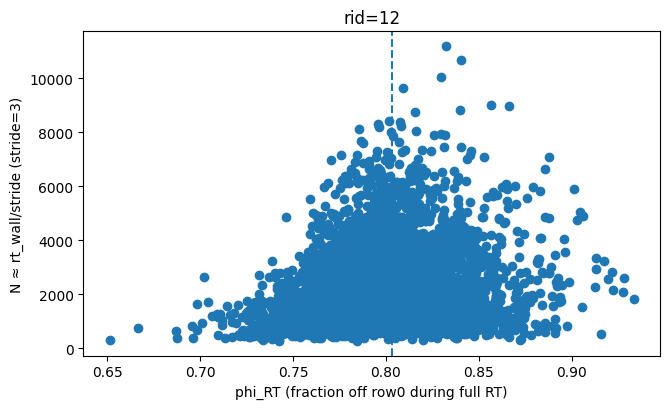

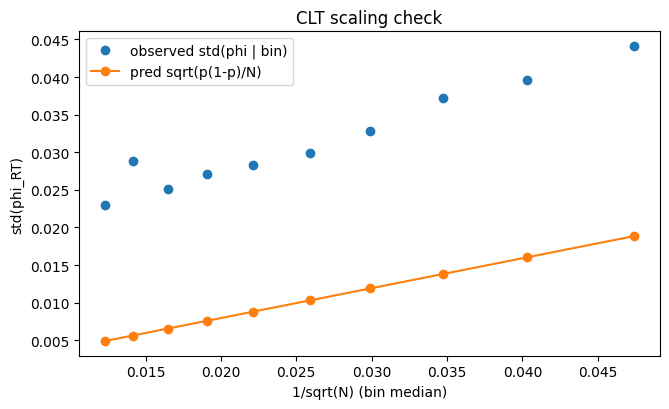

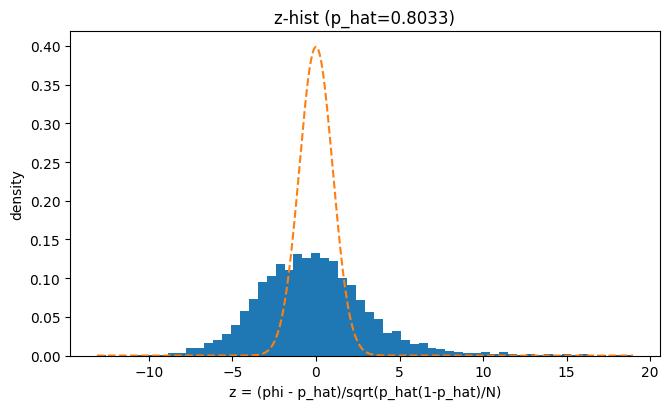

p_hat = 0.8033302418756145


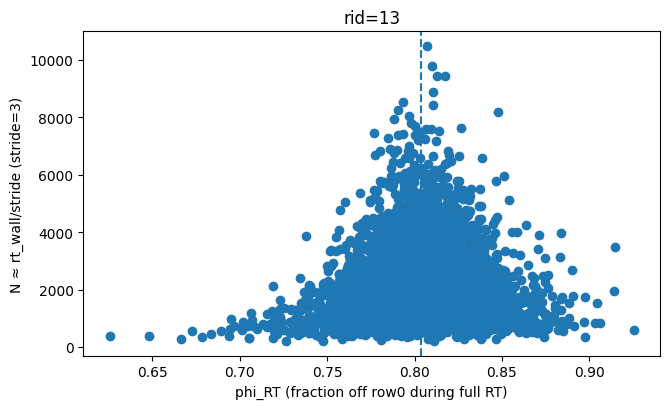

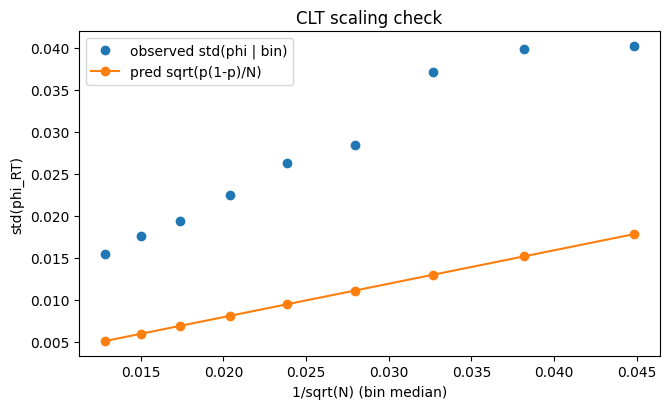

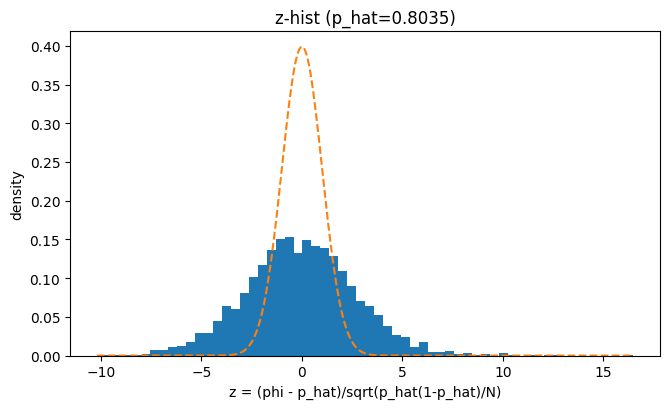

p_hat = 0.8034955322811687


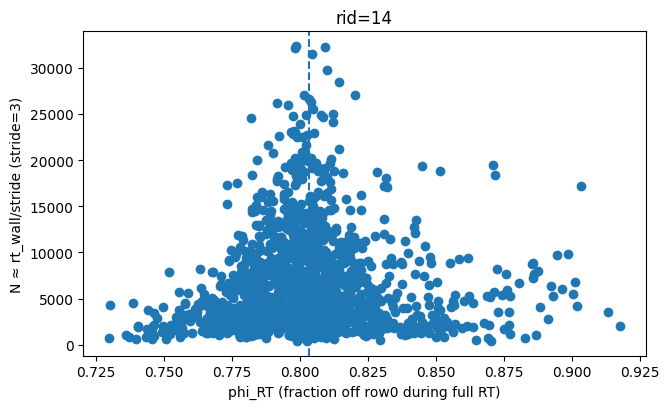

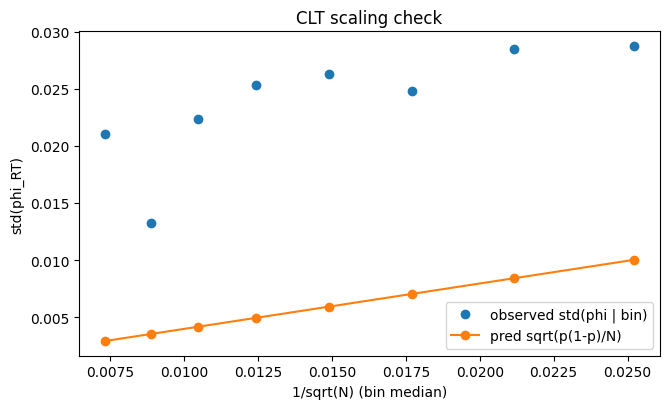

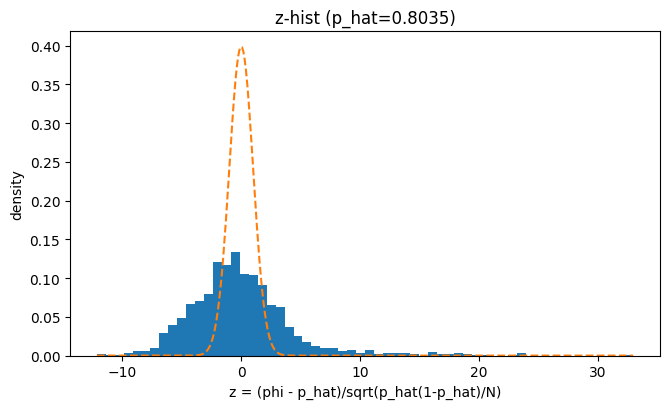

p_hat = 0.8034704081267442


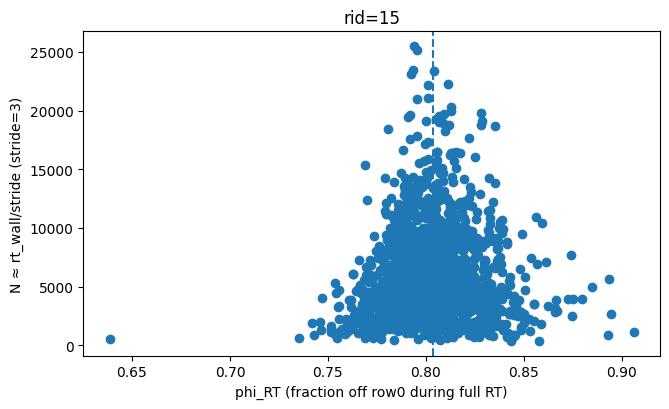

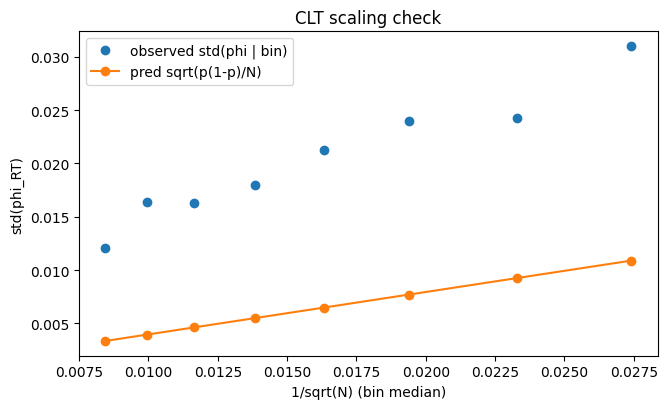

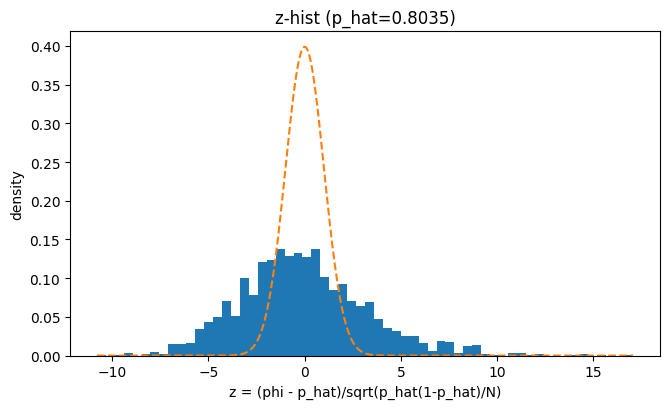

p_hat = 0.8034855333227835


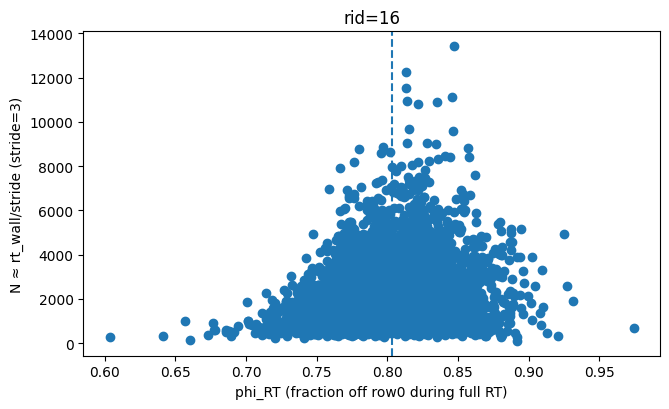

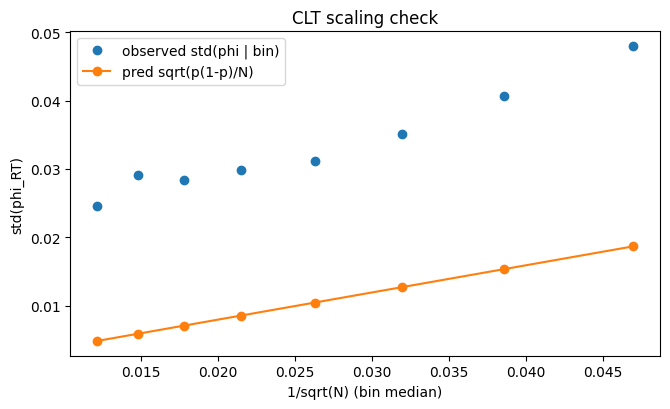

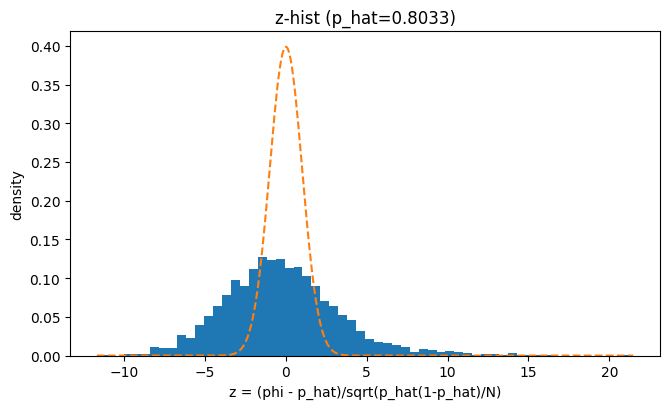

p_hat = 0.8032766535511221


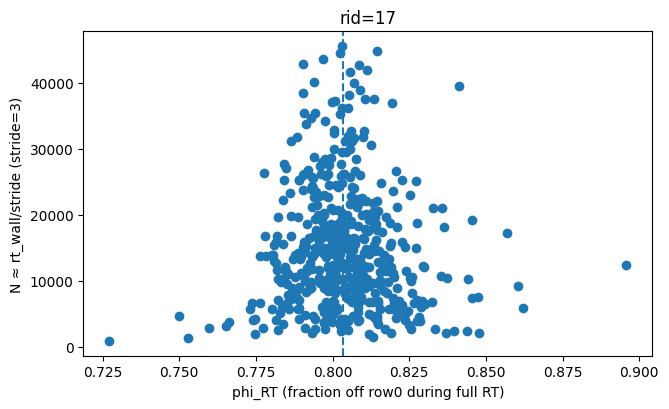

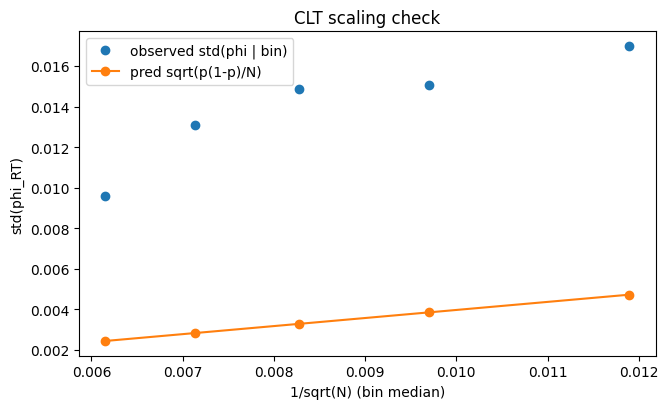

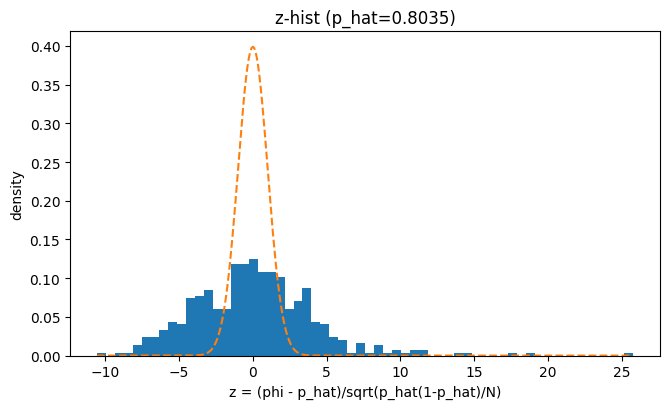

p_hat = 0.8035275772832554


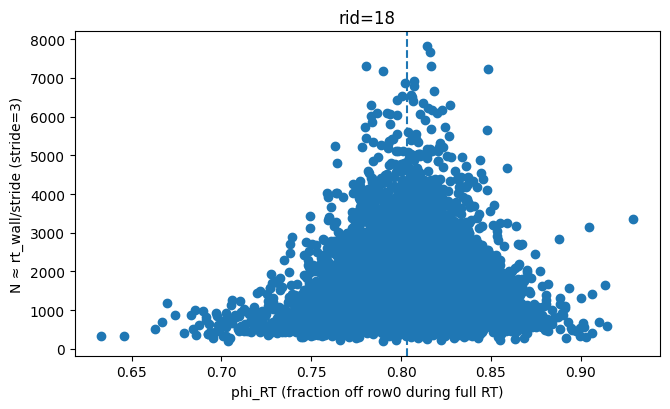

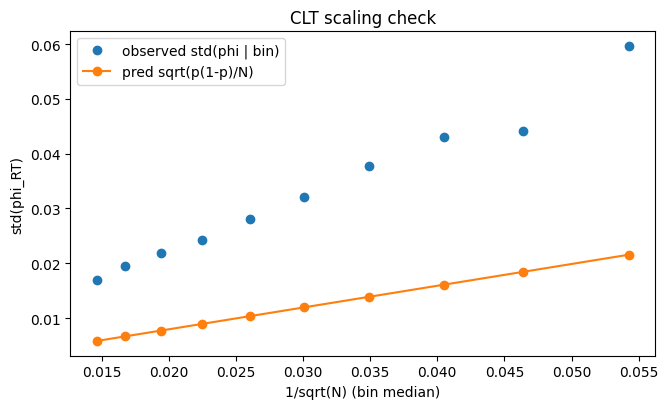

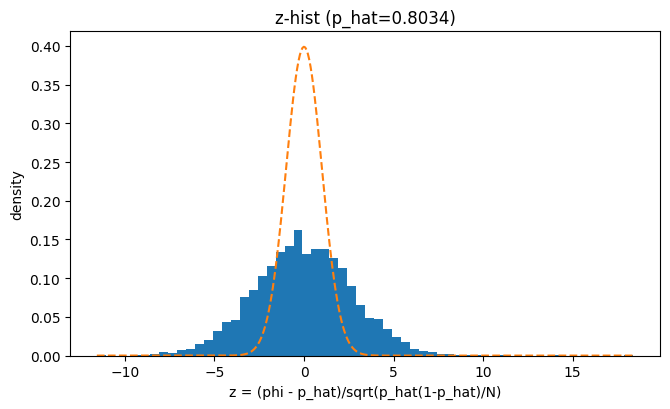

p_hat = 0.8034432558401109


KeyboardInterrupt: 

In [45]:
for rid in range(28):
    res = next(r for r in results if r.rid == rid)
    det = pt2d_roundtrip_detours(res, meta, ends, burn_in=0.0, stride=3)

    out = detour_clt_diagnostics(det, stride=3, title=f"rid={rid}")
    print("p_hat =", out["p_hat"])


In [26]:
S2 = pt2d_add_phiRT_to_summary(results, sys2, burn_in=0.0, stride=1)


NameError: name 'annotate_points' is not defined

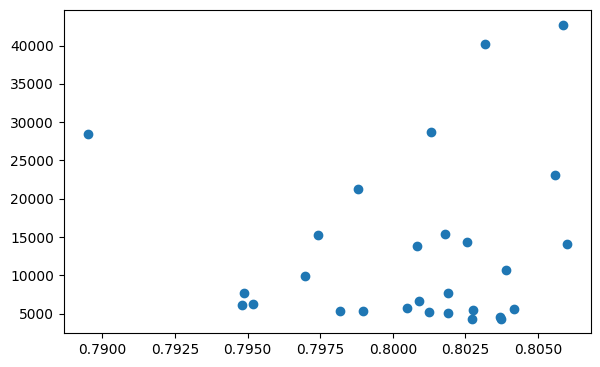

In [27]:

plot_phiRTmed_vs_rtwallmed(S2)


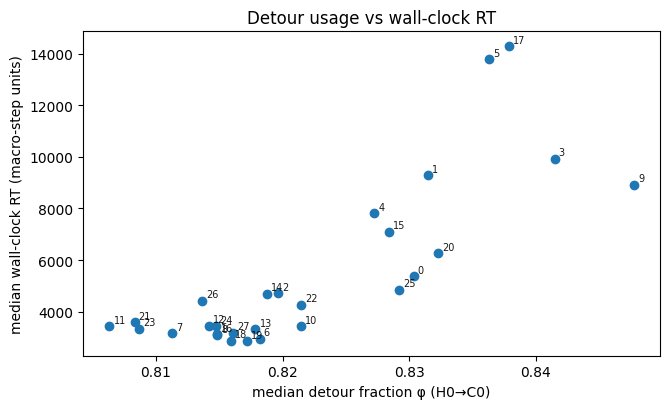

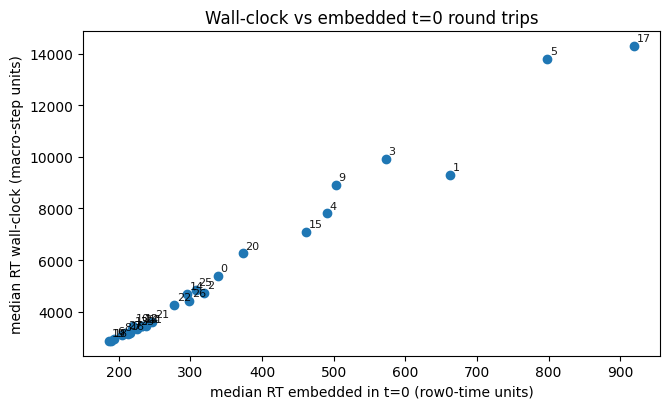

In [36]:
plot_detour_phi_vs_rt(S, annotate_rid=True, ann_kwargs=dict(fontsize=7, dx=3, dy=1))
plot_rt_wall_vs_emb0(S, annotate_rid=True)


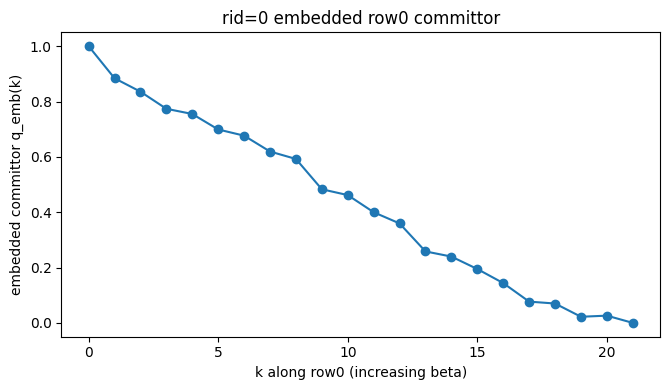

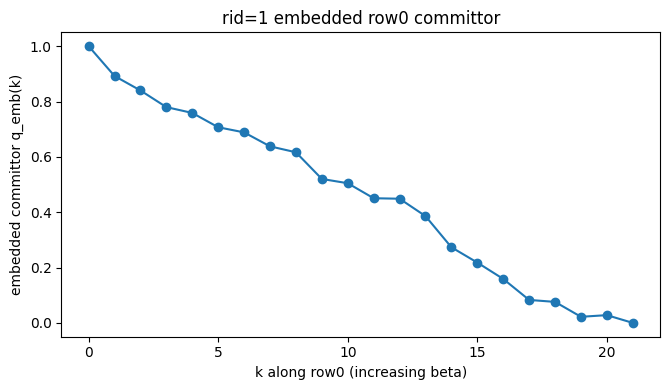

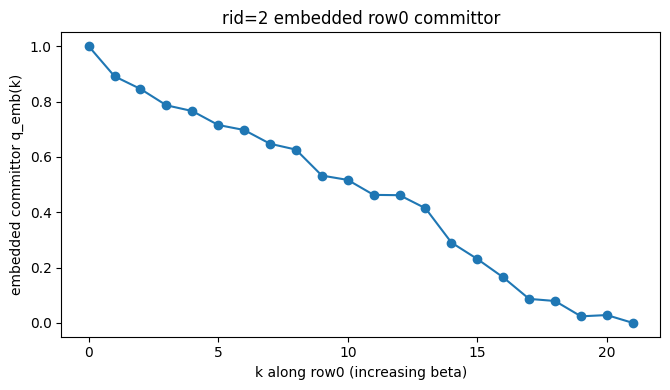

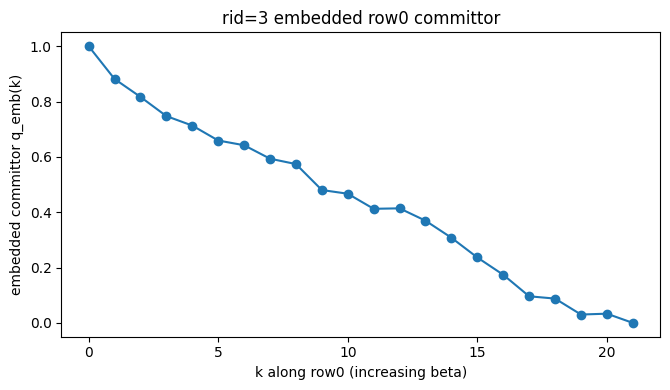

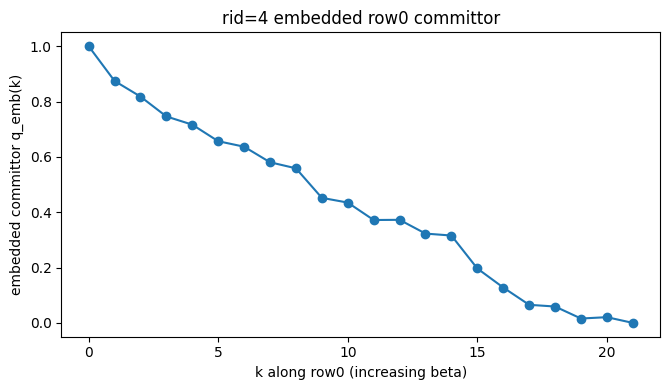

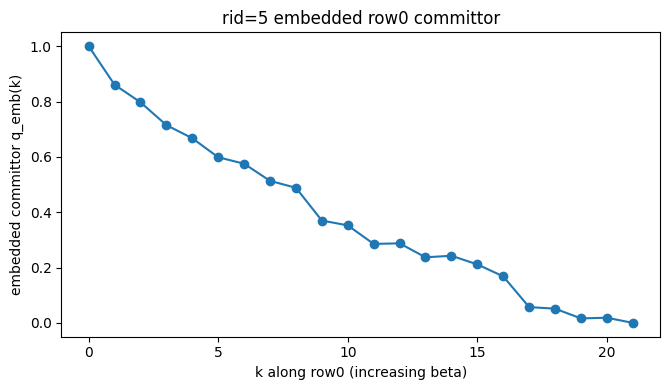

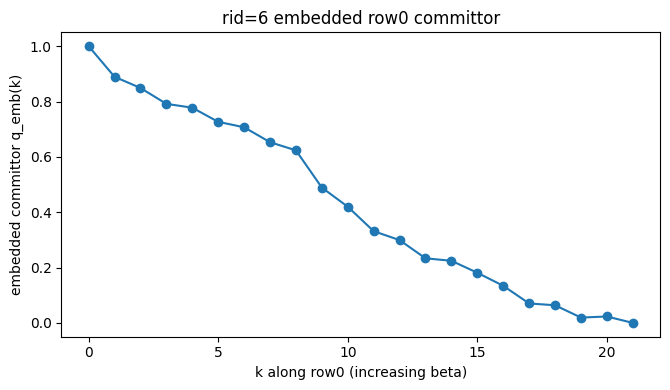

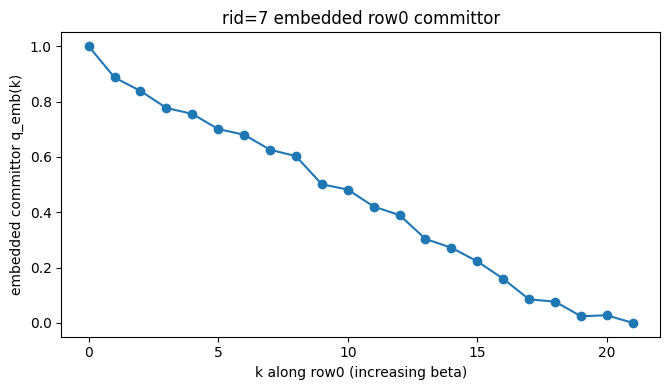

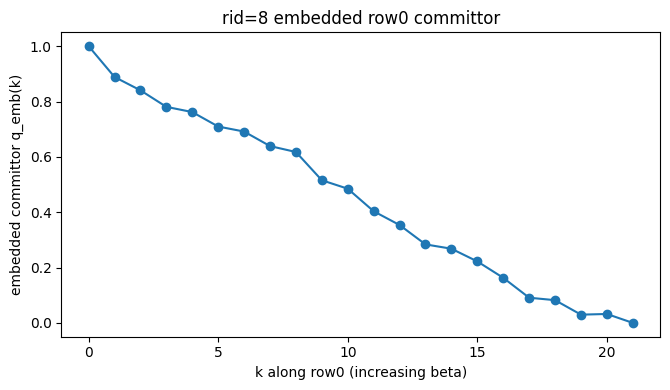

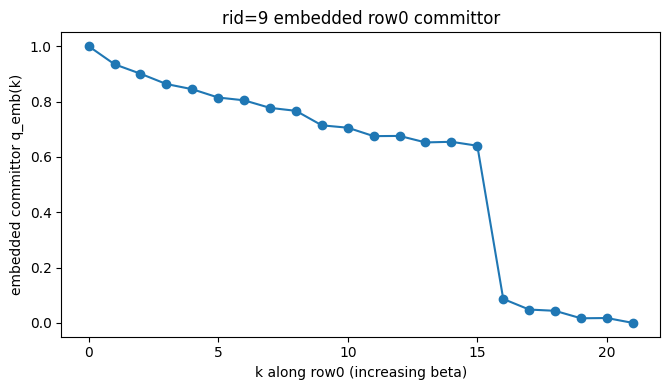

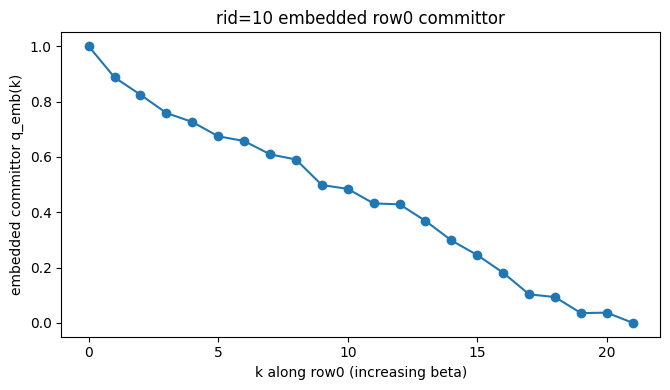

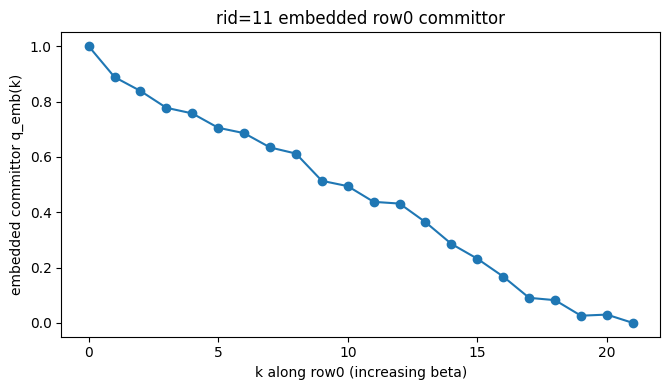

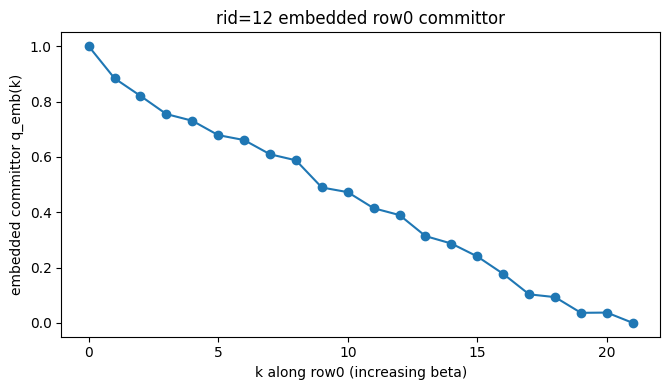

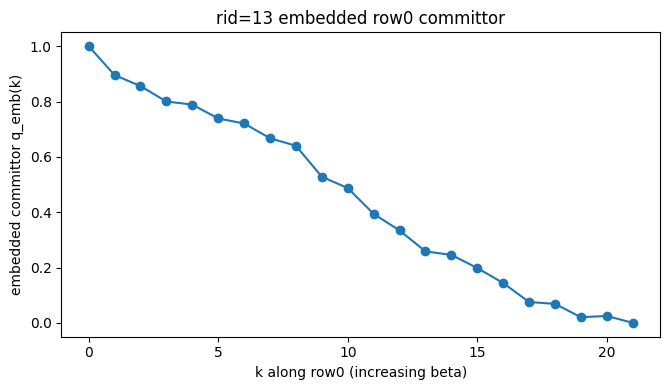

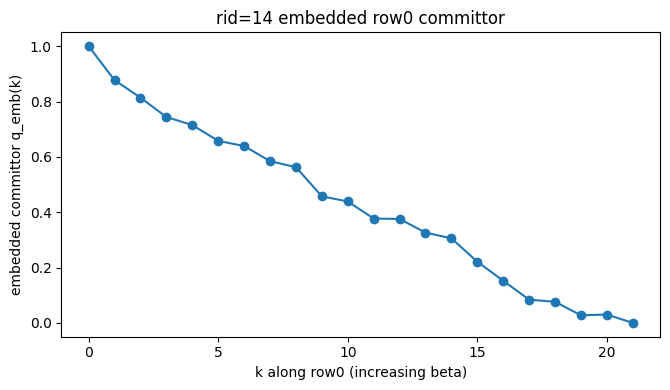

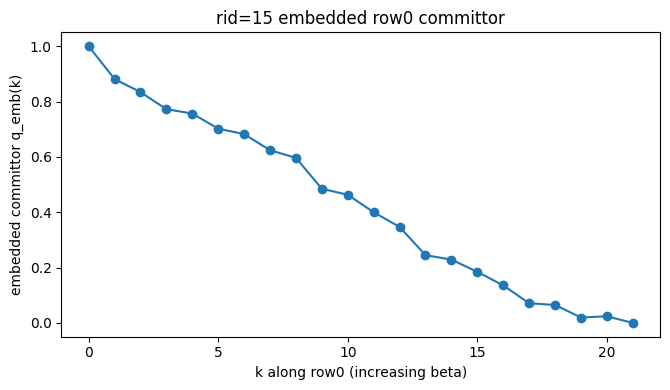

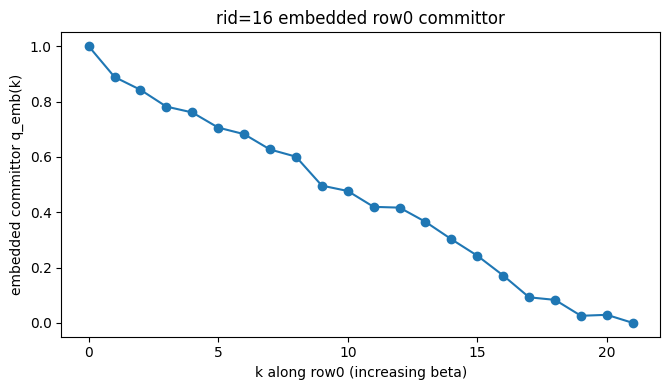

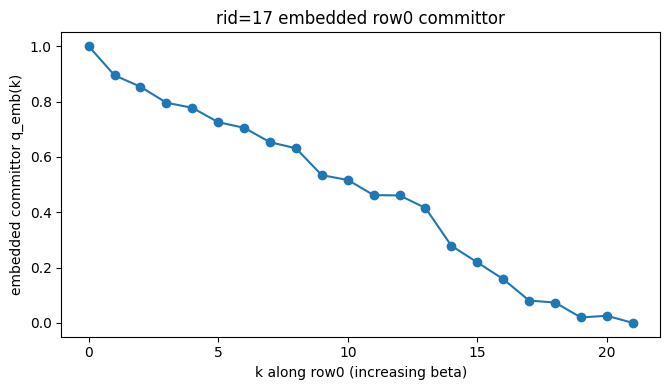

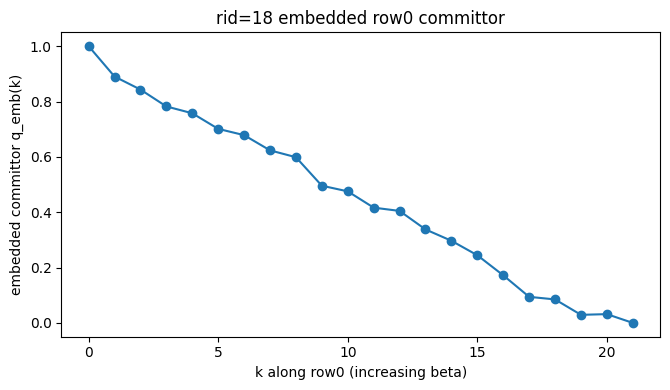

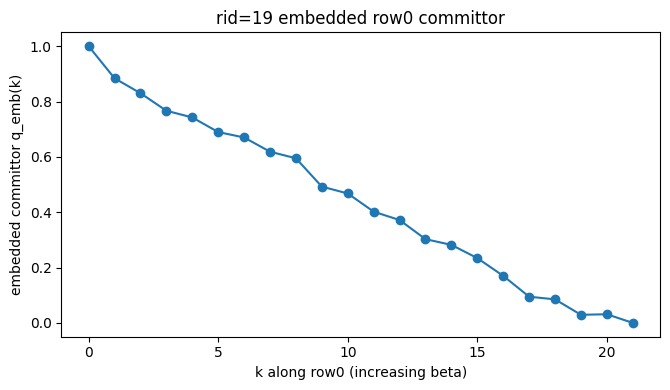

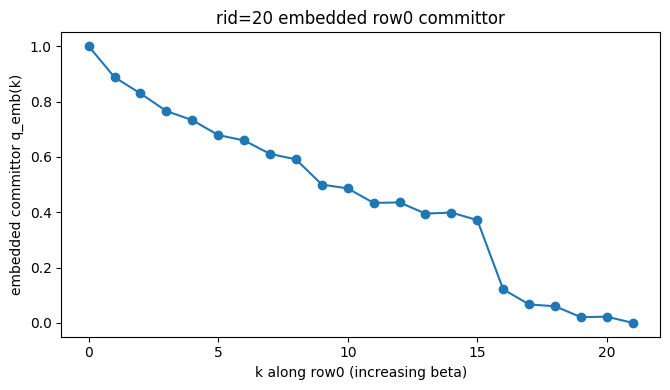

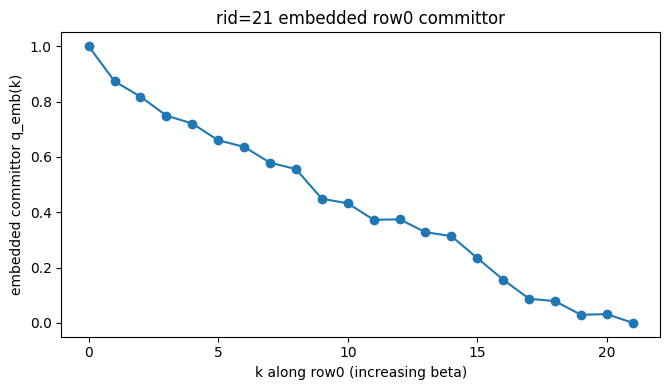

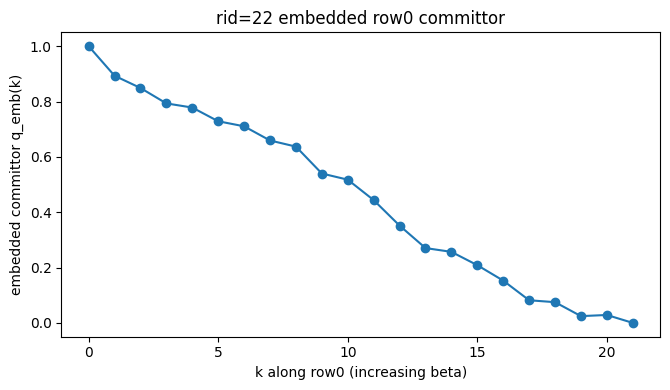

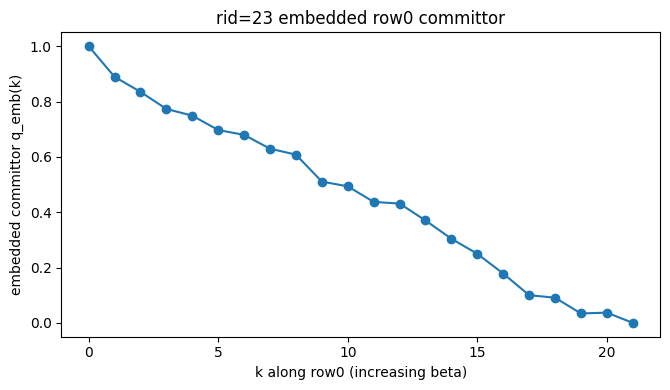

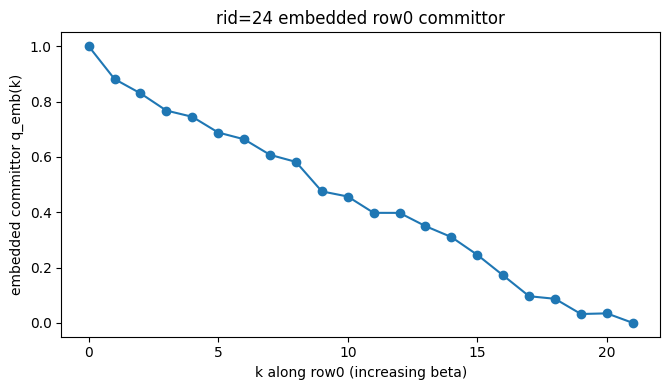

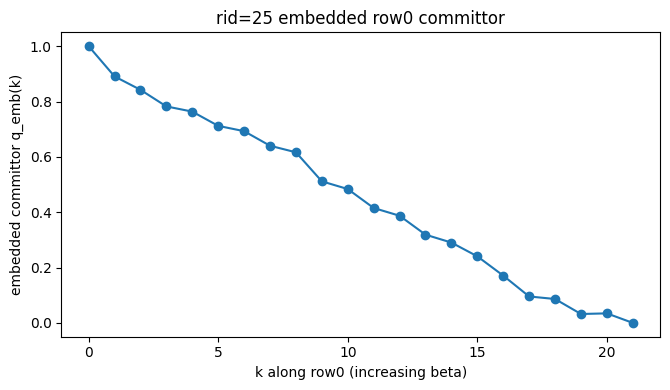

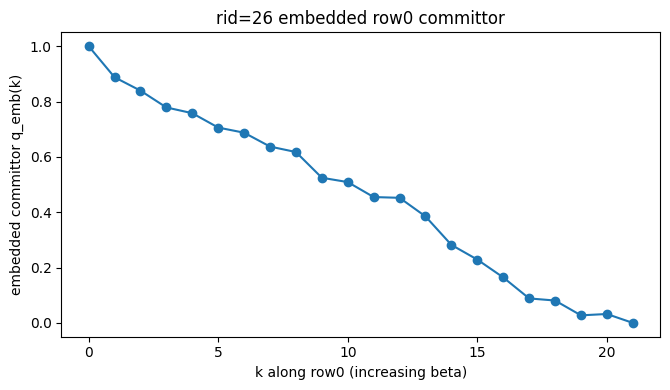

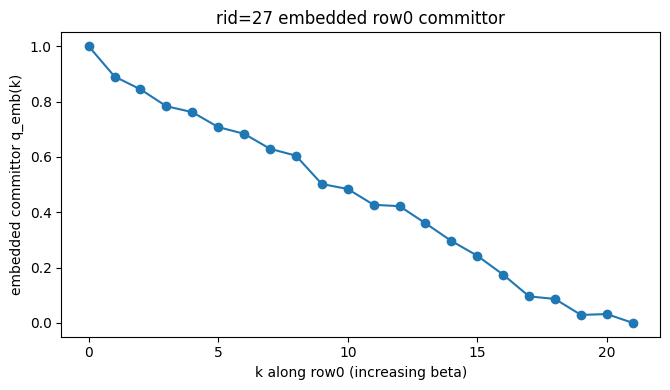

In [32]:
for rid in range(28):
    res = next(r for r in results if r.rid == rid)
    a=plot_row0_committor_embedded(res, sys2, burn_in=0.0, stride=3)


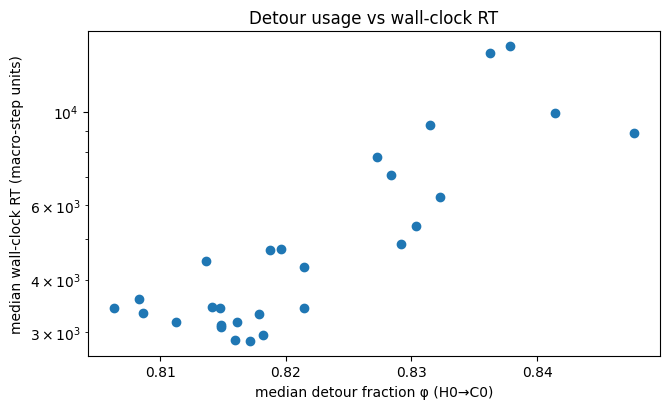

In [22]:
plot_detour_phi_vs_rt(S)